In [2]:
import pandas as pd
from scipy.stats import kendalltau, pearsonr, spearmanr
import itertools
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os


# Analysis of All Catchments So Far

- currently provided with 466 catchment-worth of data, 24% less than 618 reported in Nienke's sample
- cross correlation 
['ndvi', 'evi', 'nbr', 'ndmi', 'gndvi', 'ndbi', 'BRIGHTNESS','GREENNESS', 'WETNESS']
                                                    VS
['AI', 'EI', 'SI', 'ST', 'T', 'is_dur', 'omega']

and their respective pairs to find the highest corresponding pairs

In [31]:
abs_path = 'C:/users/creeb/ThesisGit/Thesis_Git_MOH'

dataset = 'all'
folder = 'SR_Corr_old' 

if not os.path.exists(f'../Outputs/{dataset}/{folder}/'):
    print('created')
    os.makedirs(f'../Outputs/{dataset}/{folder}/')

path = f'../Outputs/{dataset}/{folder}/'

meuse = pd.read_excel(f'{abs_path}/meuse/meuse_all_decadal_indices_combined_1.xlsx')#, index_col='system_index')
meuse_delta = pd.read_excel(f'{abs_path}/meuse/meuse_all_decadal_delta_1.xlsx')#, index_col='system_index')

#ThesisGit/Thesis_Git_MOH/meuse/meuse_all_decadal_indices_combined_1.xlsx

GB = pd.read_excel(f'{abs_path}/camels_GB/camels_GB_all_decadal_indices_combined_1.xlsx')#, index_col='system_index')
GB_delta = pd.read_excel(f'{abs_path}/camels_GB/camels_GB_all_decadal_delta_1.xlsx')#, index_col='system_index')


USA = pd.read_excel(f'{abs_path}/camels_USA/camels_USA_all_decadal_indices_combined_1.xlsx')#, index_col='system_index')
USA_delta = pd.read_excel(f'{abs_path}/camels_USA/camels_USA_all_decadal_delta_1.xlsx')#, index_col='system_index')

SR_indices = meuse.keys()[14:23]
SR_delta_indices = meuse_delta.keys()[14:23]
SR_exclude = meuse.keys()[0:23]
SR_delta_exclude =  meuse_delta.keys()[0:23]

meuse.loc[meuse.catchment_name=='La Bar Cheveuges ', ['decade_ending', 'AI']]


decade_ending        AI
2            1995  0.600242
10           2005  0.620756
18           2015  0.661387

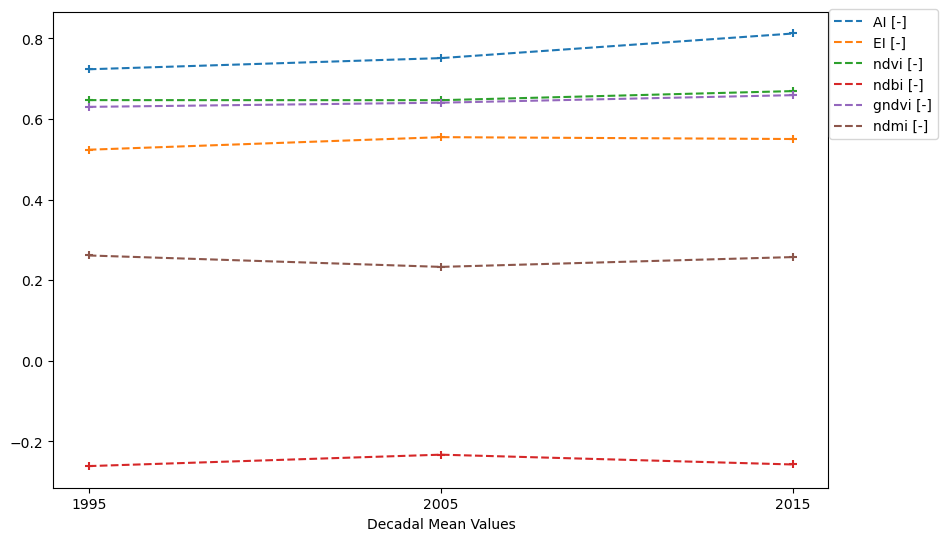

In [14]:
meuse_grouped = meuse.groupby('system_index')

label = ['AI', 'EI', 'ndvi', 'ndbi', 'gndvi', 'ndmi']


plt.figure(figsize=(10, 6.18))

for i, (group, data) in enumerate(meuse_grouped):
    if group == '00000000000000000027':
        for j in label:
            plt.plot(data.decade_ending, data.loc[:, j], ls='--', label=f'{j} [-]')
            plt.scatter(data.decade_ending, data.loc[:, j], marker='+')
            plt.xticks(data.decade_ending)
            plt.xlabel(f'Decadal Mean Values')
            plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1.02))
        #display(data)

In [15]:
def key_intersection(df1, df2, df3):
    k1 , k2, k3 = set(df1.keys().values), set(df2.keys().values), set(df3.keys().values)
    intersection = k1.intersection(k2).intersection(k3)
    return intersection

def kendall_pval(x,y):
    return kendalltau(x,y)[1]

def pearsonr_pval(x,y):
    return pearsonr(x,y)[1]

def spearmanr_pval(x,y):
    return spearmanr(x,y)[1]


In [16]:
keys = key_intersection(meuse, GB, USA).symmetric_difference(SR_indices)
d_keys = key_intersection(meuse_delta, GB_delta, USA_delta)#.symmetric_difference(SR_delta_indices)

WB_keys = {'LT_AI', 'LT_EI', 'LT_SR', 'AI', 'EI', 'SI', 'ST', 'T', 'is_dur', 'omega'}

keys


{'AI',
 'B1',
 'B2',
 'B3',
 'B4',
 'B5',
 'B7',
 'EI',
 'LT_AI',
 'LT_EI',
 'LT_SR',
 'SI',
 'ST',
 'T',
 'Unnamed: 0',
 'catchment_name',
 'country_code',
 'decade_ending',
 'is_dur',
 'omega',
 'system_index'}

In [17]:
def create_combined_table(df1, df2, df3, keys):
    combo = pd.DataFrame()
    for key in keys:
        a = df1.loc[:, key]
        b = df2.loc[:, key]
        c = df3.loc[:, key]
        
        combo_col = list(itertools.chain(*(a.to_list(),
                                                 b.to_list(),
                                                c.to_list(),))) 
        
        combo[key] = combo_col
    
    prs_r = combo.corr()
    
    p = combo.corr(method=pearsonr_pval)
    
    return [combo, prs_r, p]
        

In [23]:
combo, prs_r, p = create_combined_table(meuse, GB, USA, keys)
d_combo, d_r, d_p = create_combined_table(meuse_delta, GB_delta, USA_delta, d_keys)

d_combo.to_excel('../Outputs/all/old_d_combo.xlsx', index=0)

C:\Users\creeb\AppData\Local\Temp\ipykernel_39336\357330673.py:14: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  prs_r = combo.corr()
C:\Users\creeb\AppData\Local\Temp\ipykernel_39336\357330673.py:16: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  p = combo.corr(method=pearsonr_pval)
C:\Users\creeb\AppData\Local\Temp\ipykernel_39336\357330673.py:14: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  prs_r = combo.corr()
C:\Users\creeb\AppData\Local\Temp\ipykernel_39336\357330673.py:

In [19]:
def sorted_p(p):
    p.replace(1, np.nan)
    sorted_p = pd.DataFrame()

    for i in p.keys()[:]:
        sort = pd.DataFrame(p.loc[:, i].sort_values(ascending=False))
        sorted_p[f'{i}_vs'] = sort.index
        sorted_p[f'{i}_p'] = sort.values
    return sorted_p

In [20]:
sort_p = sorted_p(p)
sort_dp = sorted_p(d_p)

In [21]:
def plot_descending_P(SR_index:[], df_all, sorted_p, prs_r, exclude, delta=False, plot=False, savefig=False, color_by=str, levels=[]):
    '''
    The function loops through the list of Surface Reflectance indices passed. The plotting returns scatters in descending
    order from   to:  1 > p-value > 0.01 
    '''
    ls = []
    
    for i in SR_index:
        
        if delta==True:
            i = f'd_{i}'

        high_to_low_id = sorted_p.loc[:, f'{i}_vs']
        high_to_low_p = sorted_p.loc[:, f'{i}_p']
        
        for j in zip(high_to_low_id, high_to_low_p):
            if j[1] < 0.1 and j[0] not in exclude:
                
                
                r = prs_r.loc[i, j[0]]
                ls.append((i, j[0], j[1], r))
                
                
                if plot == True:
                    plt.figure(figsize=(10, 6.18))
                    
                    
                    
                    x = df_all.loc[:, i] 

                    y = df_all.loc[:, j[0]]


                    plt.suptitle(f'$p$: {j[1]:.3e}, $r$= {r:.3e}, $n$ = {len(x)}')
        
                    plt.xlabel(i)

                    plt.ylabel(j[0])
                
                
                if delta==True and plot == True:
                    
                    plt.title(f'$\Delta$ {i[2:]}  vs $\Delta$ {j[0][2:]}')
                    
                    plt.scatter(x, y, c=df_all.loc[:,  color_by], alpha=0.6)
    
                    plt.colorbar(ticks=levels, label=f'All Time Aridity Index $AI$')
                    
                    plt.xlabel(f'$\Delta${i[2:]}')

                    plt.ylabel(f'$\Delta${j[0][2:]}')
        
                    if savefig == True:
                        folder = 'SR_delta_correlations'
                        if not os.path.exists(f'{path}/{folder}/'):
                            os.makedirs(f'{path}/{folder}/')
                        
                        plt.savefig(f'{path}SR_delta_correlations/{i}_{j[0]}_{color_by}')

                elif delta==False and plot == True:    
                    

                    plt.title(f'{i} vs  {j[0]}')
                    
                    plt.scatter(x, y, c=df_all.loc[:,  color_by], alpha=0.6)
                    
                    plt.colorbar(ticks=levels, label=f'All Time Aridity Index $AI$')
                    
                    if savefig == True:
                        folder = 'SR_correlations'
                        if not os.path.exists(f'{path}/{folder}/'):
                            os.makedirs(f'{path}/{folder}/')
                        
                        plt.savefig(f'{path}SR_correlations/{i}_{j[0]}_{color_by}')
                
                ##if j[1] <= 0.1:
                    #break
                
            else:
                None
        
    return ls

## Here we plot and save all the tables
The Plot names and lables are a little confusing, would be useful to code a table of tranlastion so its not so cryptic

In [22]:
#SR_indices
years_levels = [1989, 1999, 2009, 2015]
AI_levels = [0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6, 1.8, 2]
AI_levels_used = [0.2, 0.4, 0.6, 0.8, 1, 1.2]

 
#ranking = plot_descending_P(SR_indices, combo, sort_p, prs_r, SR_exclude, delta=False, plot=True, savefig=False, color_by='decade_ending', levels = years_levels)
ranking = plot_descending_P(SR_indices, combo, sort_p, prs_r, SR_exclude, delta=False, plot=False, savefig=True, color_by='LT_AI', levels = AI_levels)

#sort_p.keys()

KeyError: 'ndvi_vs'

In [13]:
df_ranking = pd.DataFrame(ranking, columns= ['SR_ind', 'WB_Clim_ind', 'prs_P', 'prs_R']).sort_values('prs_P')
df_ranking.to_excel(f'{path}SR_correlations/ranking_correlatons.xlsx')
df_ranking

SR_ind WB_Clim_ind         prs_P     prs_R
36        ndbi      is_dur  1.216660e-43  0.582255
23        ndmi      is_dur  1.216660e-43 -0.582255
55     WETNESS      is_dur  1.451799e-40 -0.564460
35        ndbi          AI  8.293767e-35  0.527972
22        ndmi          AI  8.293767e-35 -0.527972
16         nbr      is_dur  1.269822e-32 -0.512868
54     WETNESS          ST  4.333393e-32 -0.509065
15         nbr          AI  1.263753e-31 -0.505710
53     WETNESS          AI  7.796047e-31 -0.499919
34        ndbi          ST  4.870574e-27  0.470450
21        ndmi          ST  4.870574e-27 -0.470450
48   GREENNESS          AI  1.051997e-22 -0.432874
47   GREENNESS      is_dur  4.405111e-22 -0.427077
14         nbr          ST  4.650041e-22 -0.426856
33        ndbi          EI  1.024464e-18  0.393580
20        ndmi          EI  1.024464e-18 -0.393580
52     WETNESS          SI  5.384258e-18 -0.385889
19        ndmi          SI  1.825643e-16 -0.368847
32        ndbi          SI  1.825643e-16  0.368847
13         nbr          EI  2.368440e-16 -0.367548
51     WETNESS          EI  1.794814e-15 -0.357228
46   GREENNESS          EI  6.509212e-15 -0.350462
6         ndvi          AI  3.555036e-13 -0.328344
41  BRIGHTNESS           T  2.805509e-12 -0.316182
12         nbr          SI  8.626971e-11 -0.294698
40  BRIGHTNESS       omega  3.444118e-10 -0.285485
29       gndvi          AI  2.277611e-09 -0.272344
5         ndvi      is_dur  3.041504e-09 -0.270269
45   GREENNESS       omega  2.309157e-08 -0.255204
28       gndvi      is_dur  1.203528e-06 -0.222674
4         ndvi          ST  1.874914e-06 -0.218711
3         ndvi          EI  5.231594e-06 -0.209241
44   GREENNESS          ST  1.094873e-05 -0.202148
27       gndvi          ST  2.710019e-05 -0.193088
39  BRIGHTNESS          EI  3.458991e-05 -0.190576
31        ndbi       omega  4.078433e-05  0.188861
18        ndmi       omega  4.078433e-05 -0.188861
43   GREENNESS          SI  1.698162e-04 -0.173331
11         nbr       omega  2.547977e-04 -0.168663
38  BRIGHTNESS      is_dur  3.352977e-04 -0.165434
50     WETNESS           T  5.826847e-04 -0.158749
26       gndvi          EI  6.172192e-04 -0.158037
30        ndbi           T  1.543258e-03  0.146285
17        ndmi           T  1.543258e-03 -0.146285
25       gndvi          SI  3.532427e-03 -0.134879
24       gndvi           T  4.880704e-03  0.130188
2         ndvi          SI  5.358025e-03 -0.128806
1         ndvi           T  9.365656e-03  0.120255
49     WETNESS       omega  1.010378e-02 -0.119053
10         evi           T  1.016317e-02  0.118960
42   GREENNESS           T  1.330926e-02 -0.114600
9          evi      is_dur  3.658112e-02  0.096869
37  BRIGHTNESS          AI  4.290022e-02 -0.093836
8          evi          AI  5.184472e-02  0.090132
7          evi          EI  5.973413e-02  0.087285
0         ndvi       omega  6.290043e-02 -0.086229

C:\Users\creeb\AppData\Local\Temp\ipykernel_27144\3518792086.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(10, 6.18))


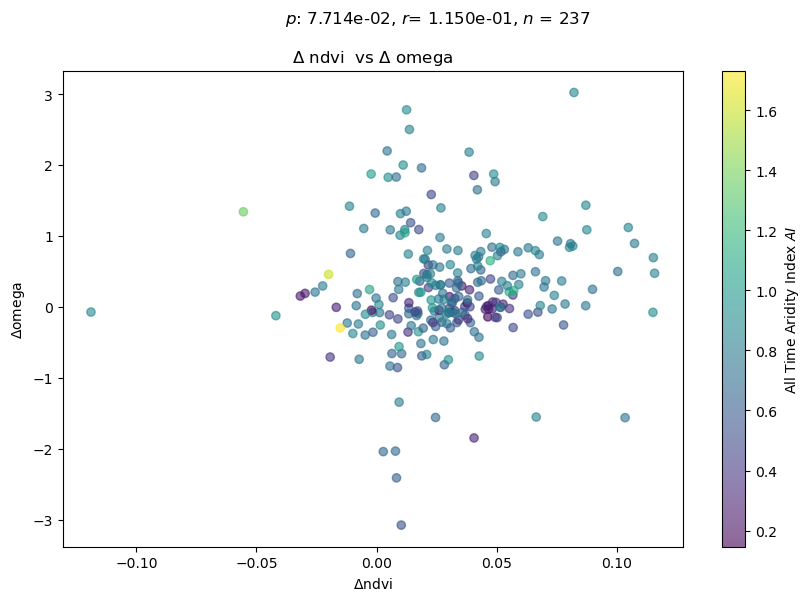

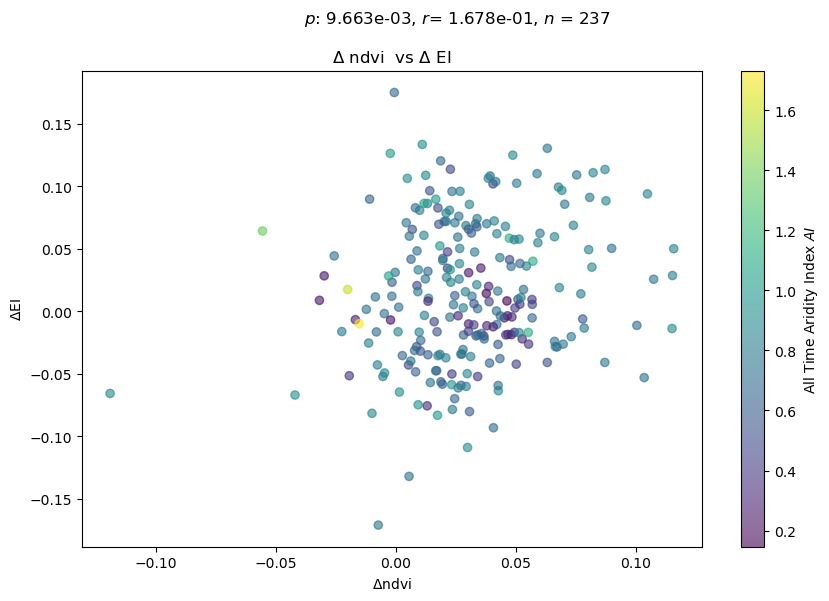

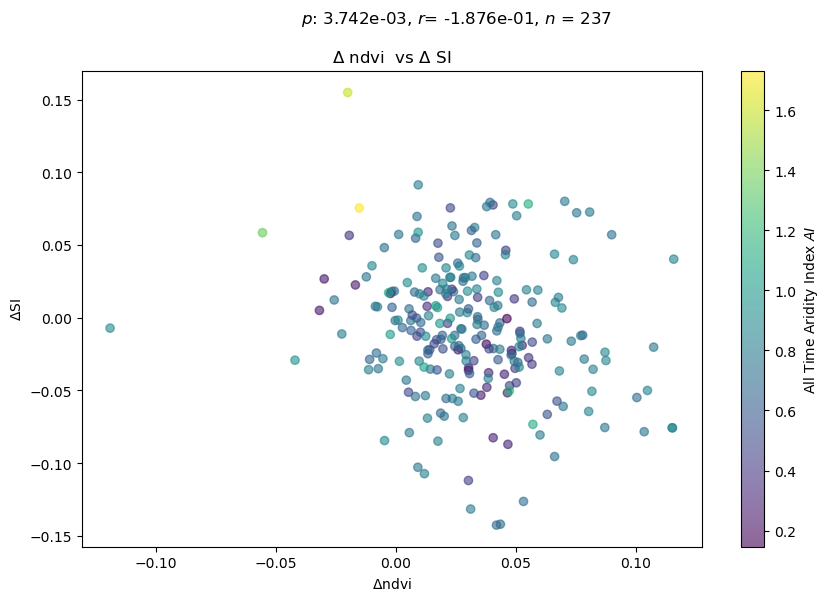

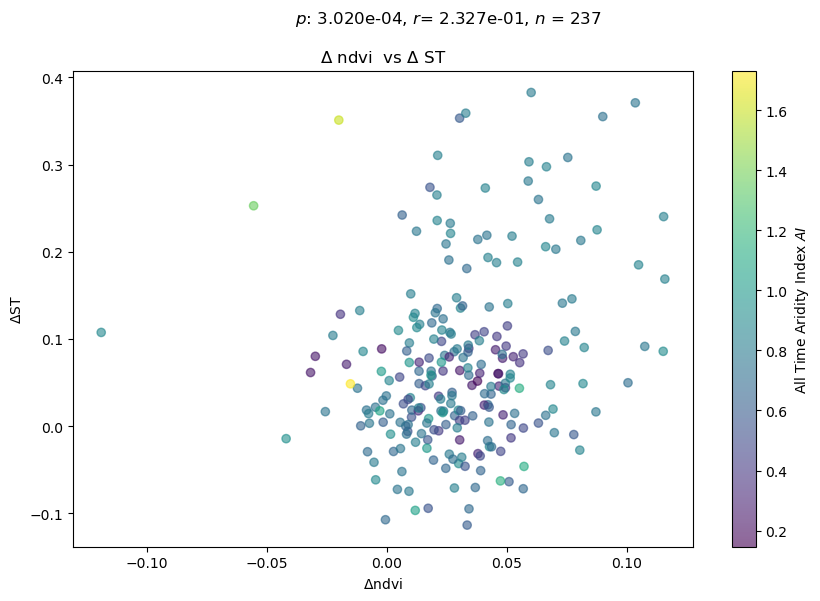

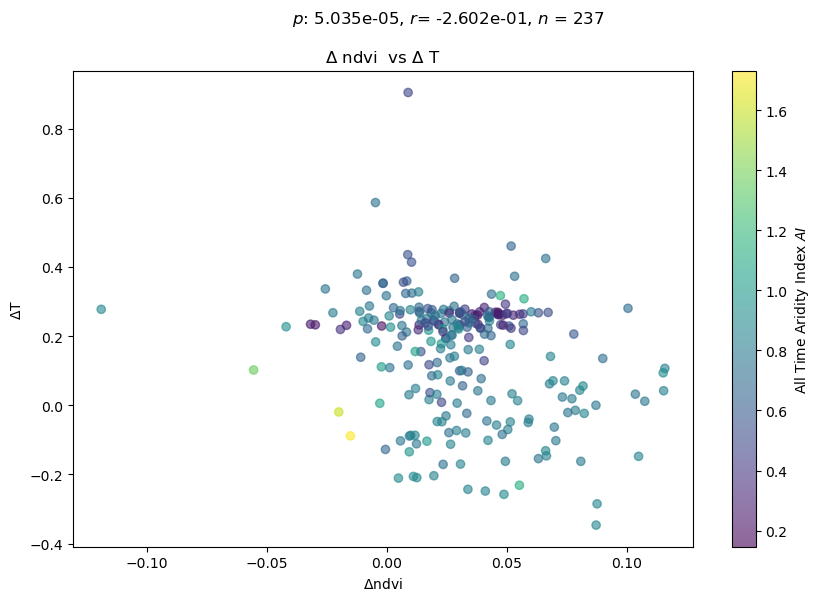

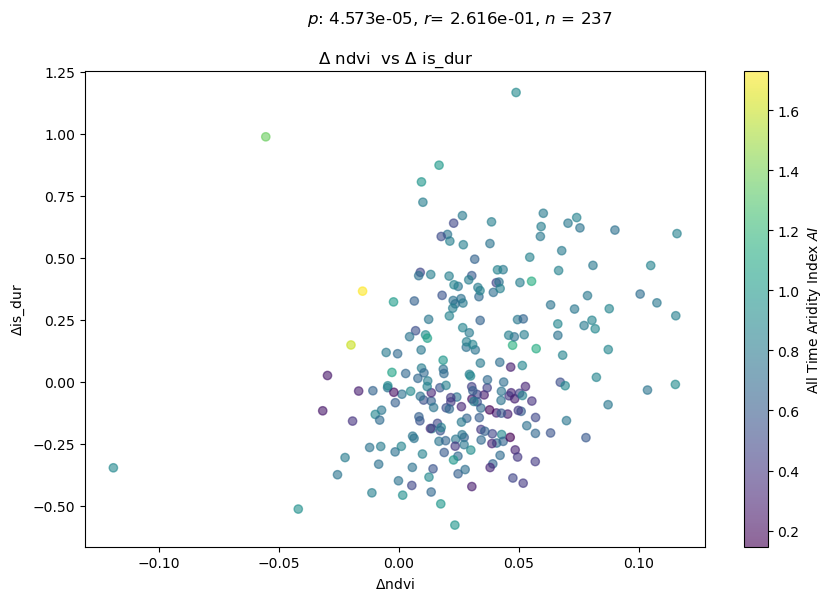

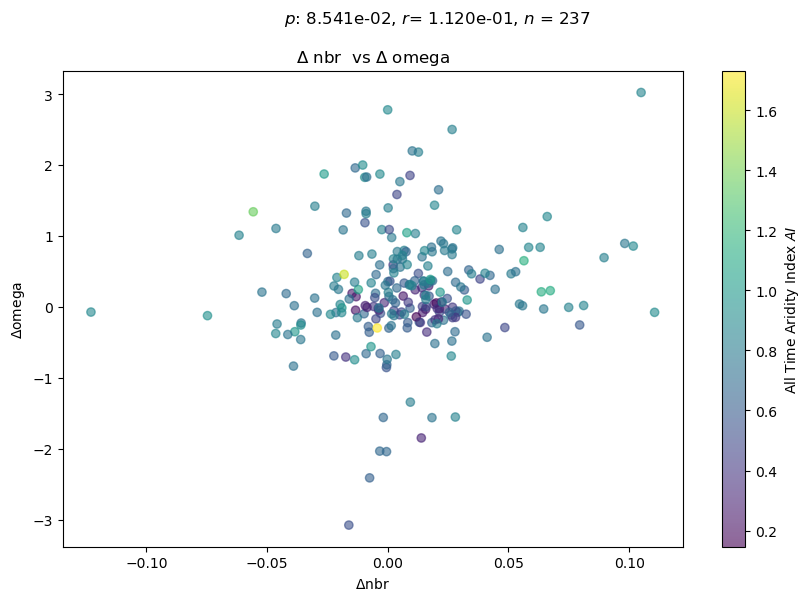

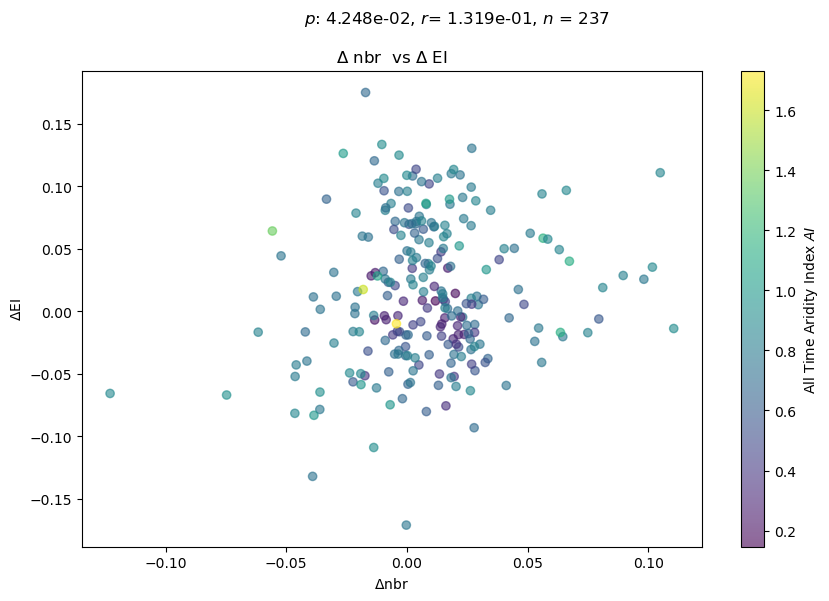

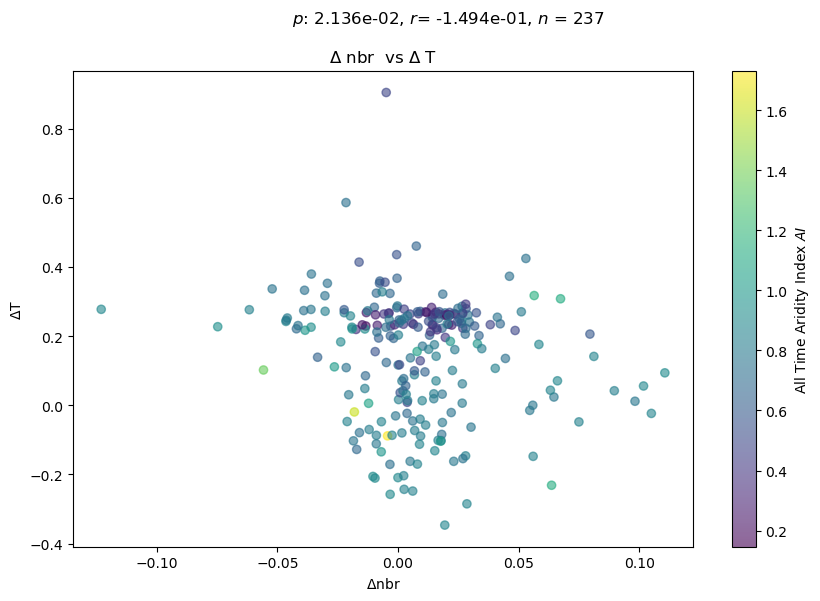

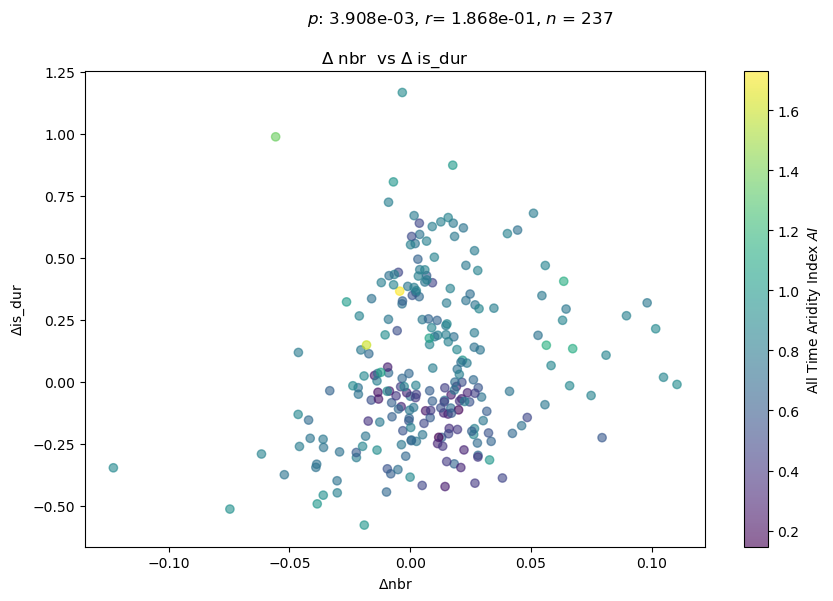

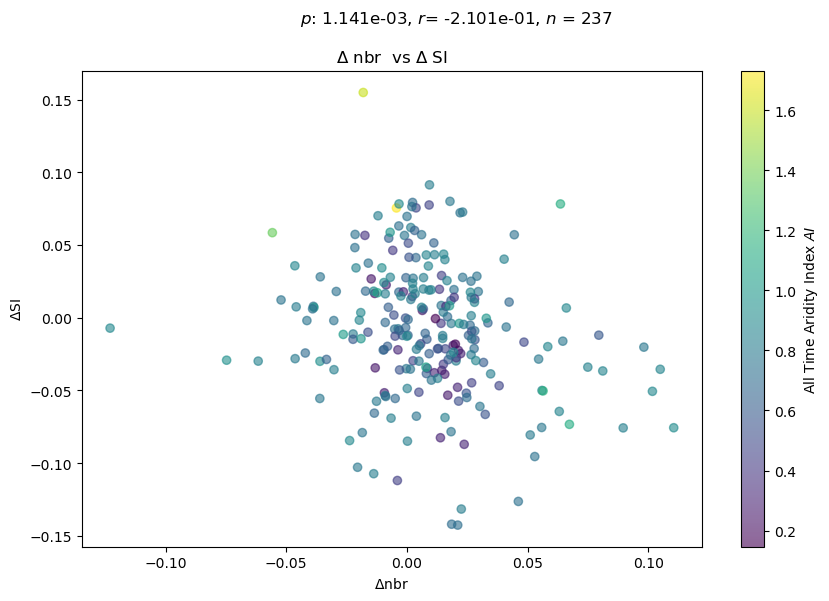

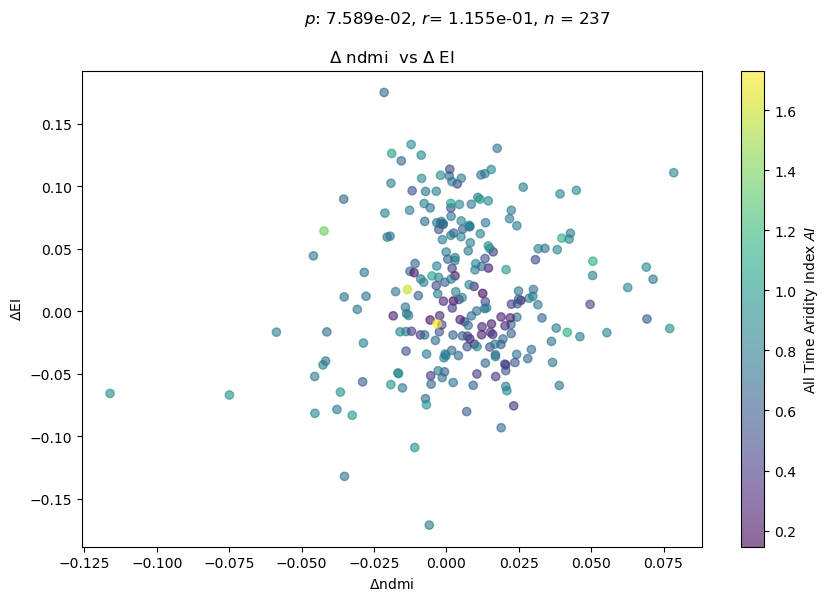

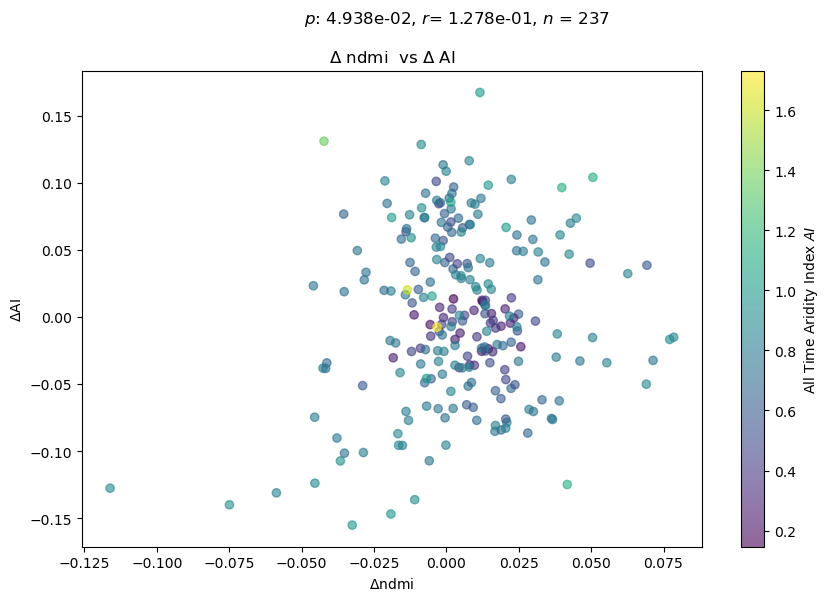

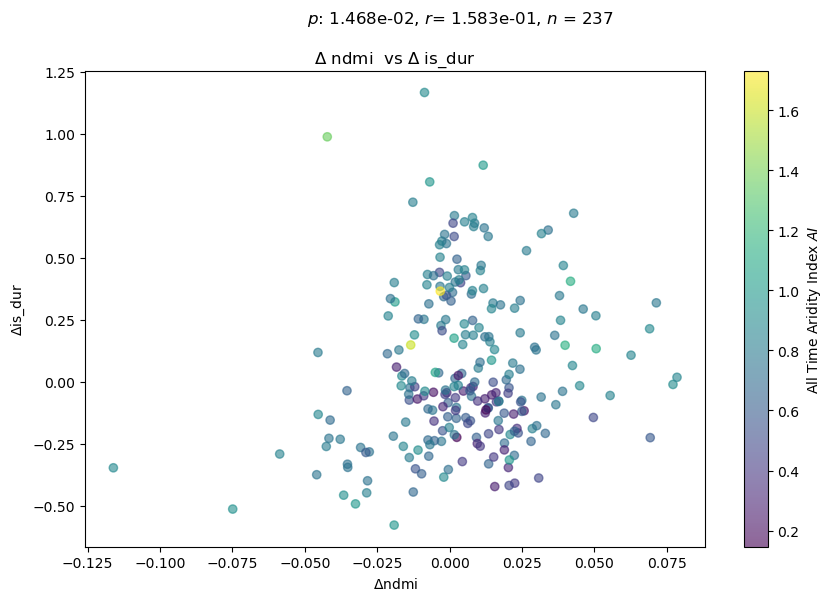

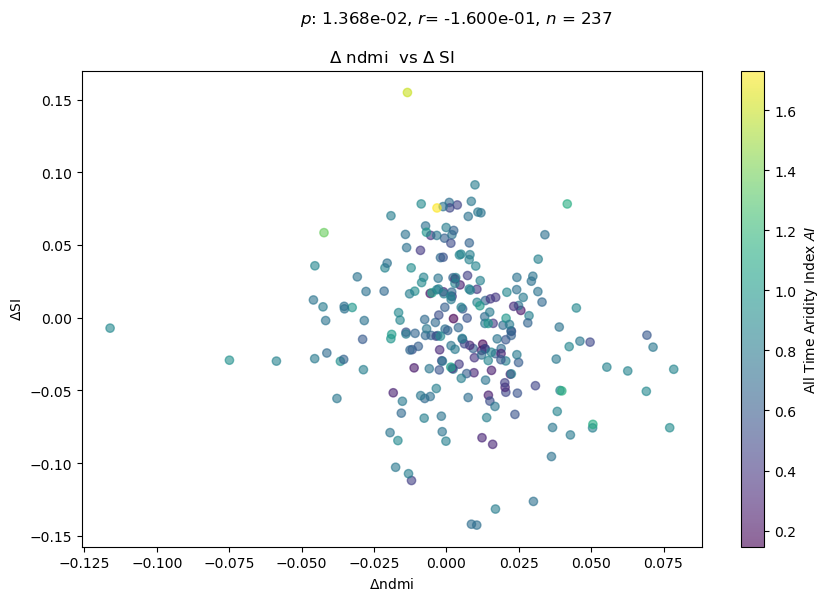

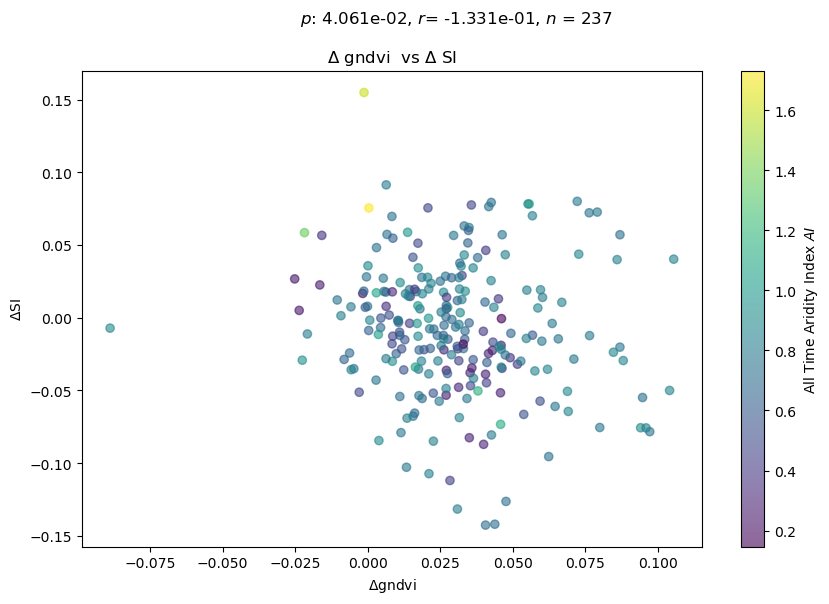

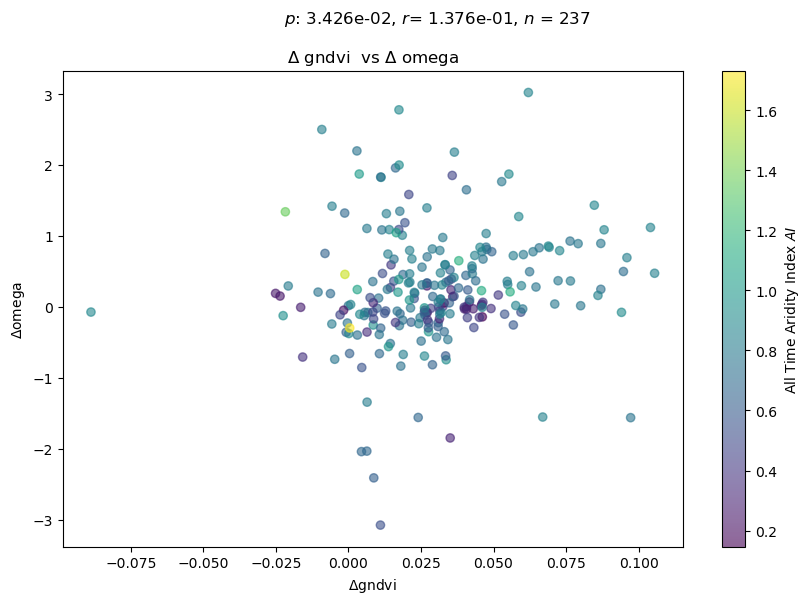

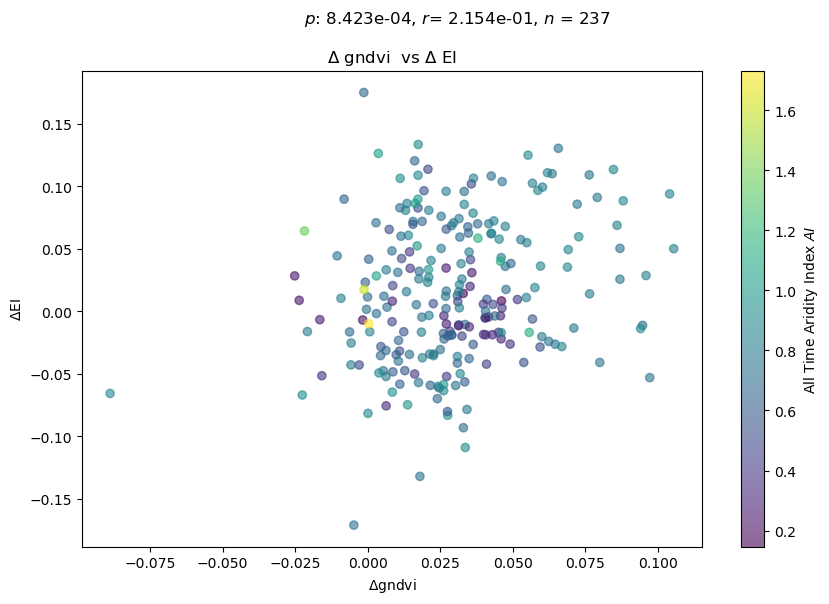

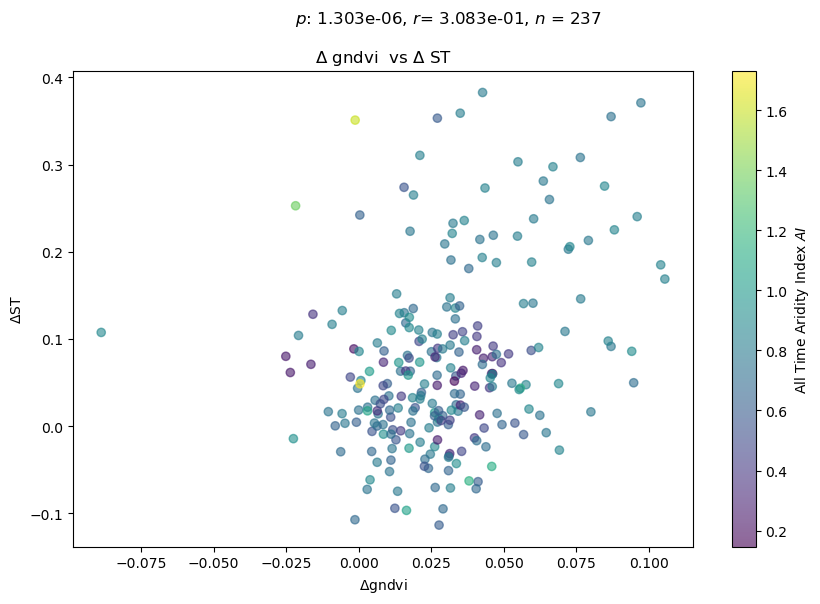

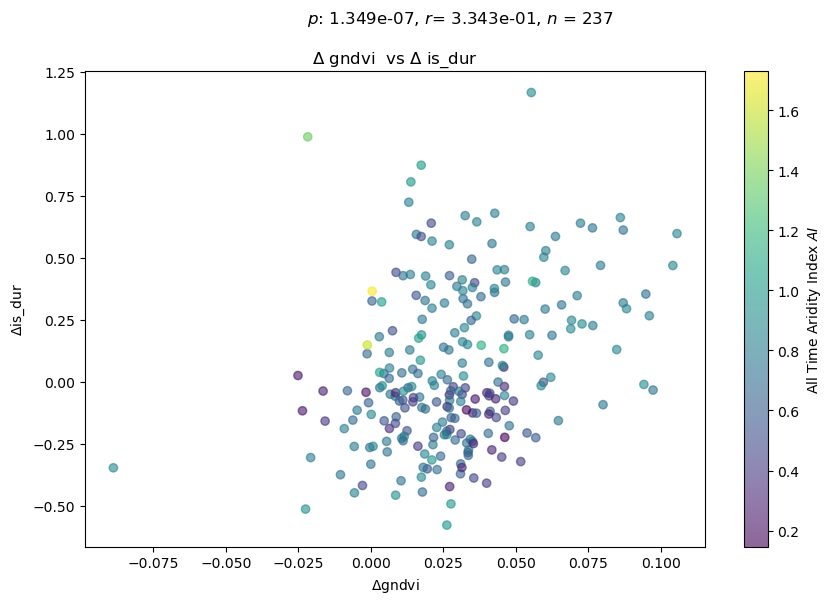

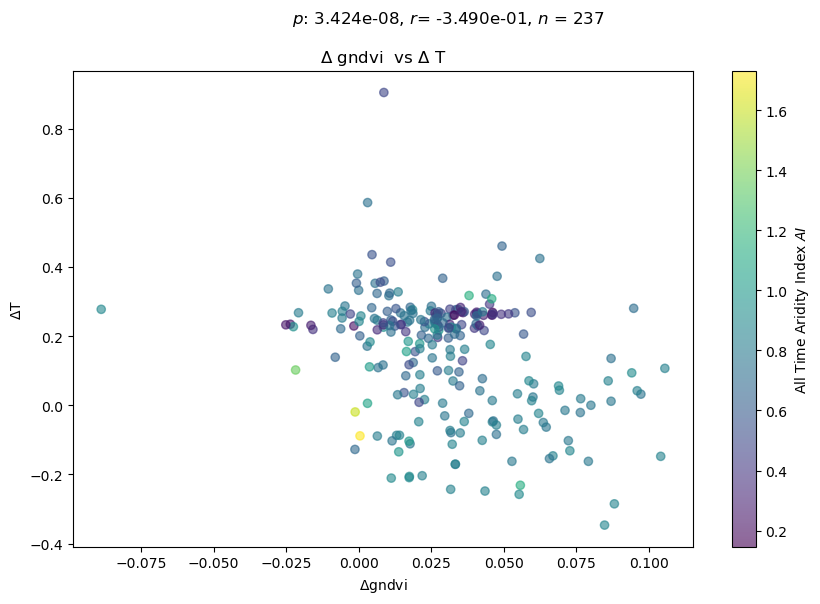

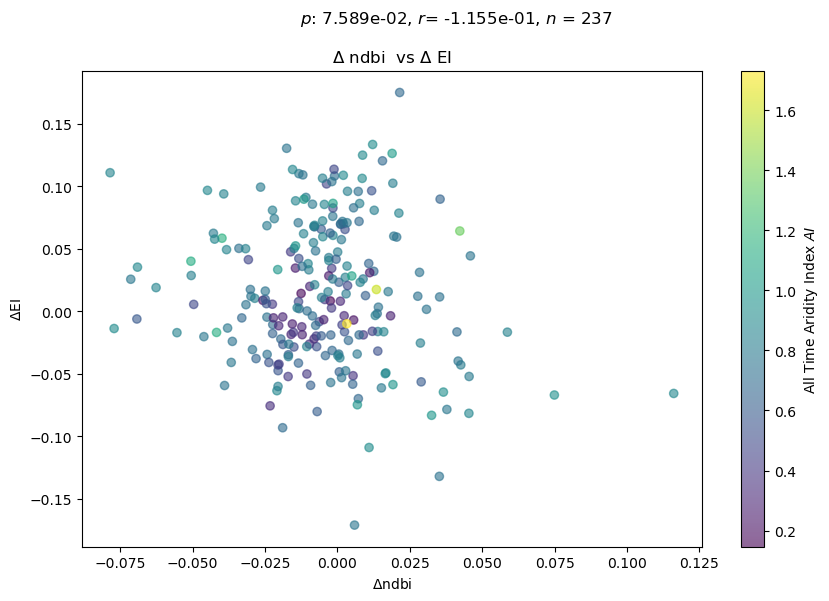

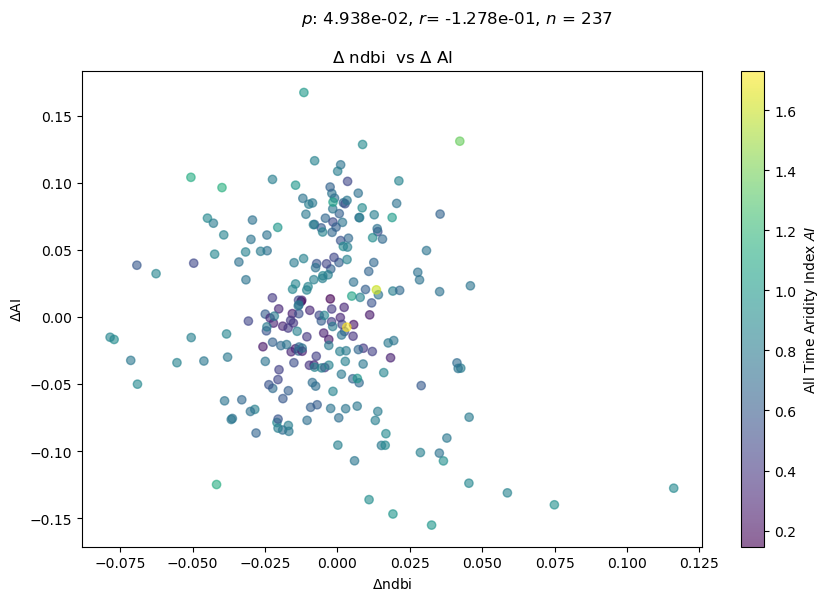

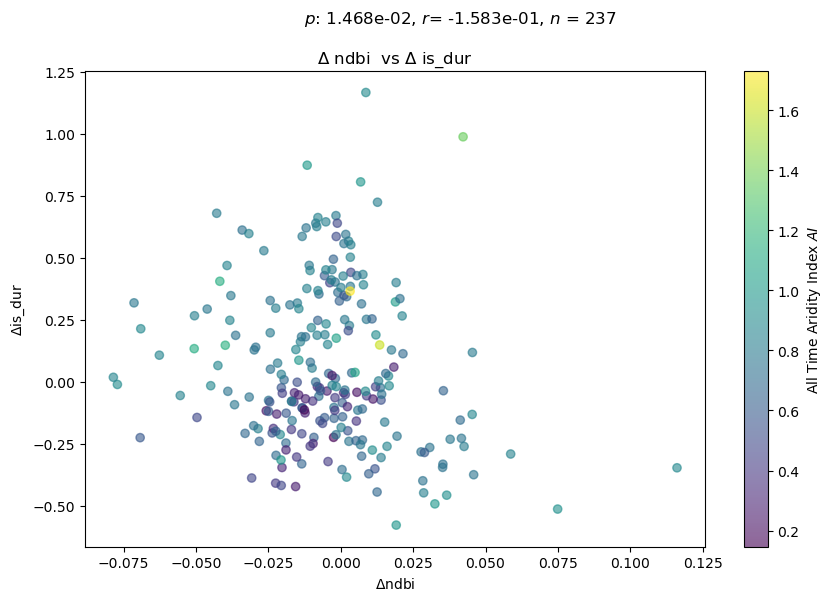

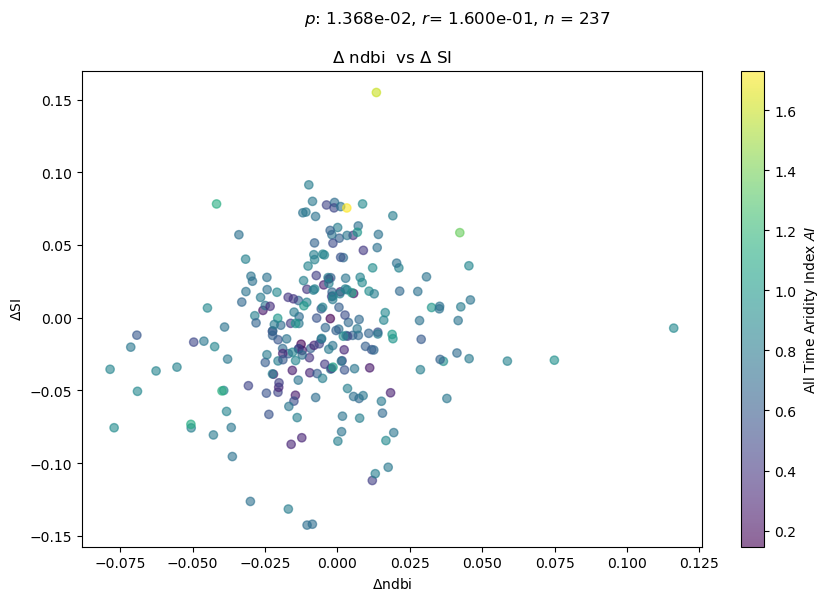

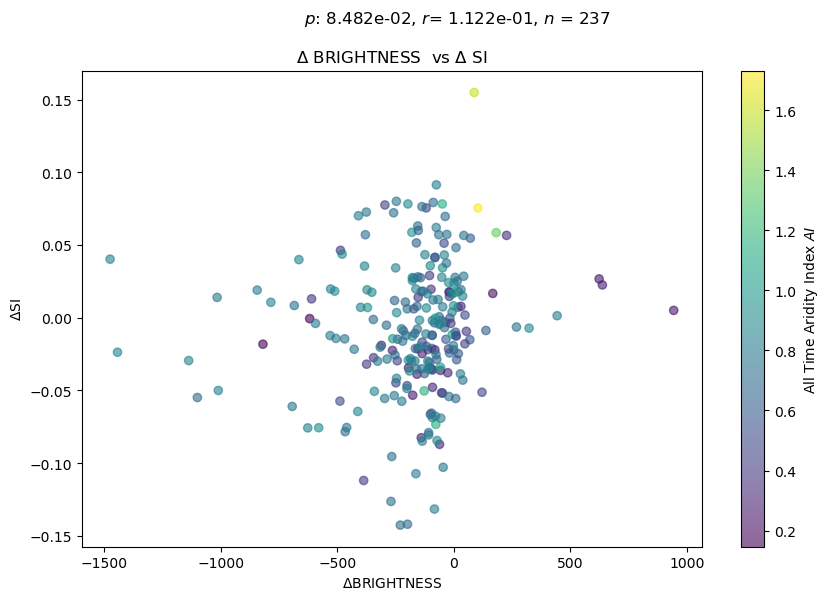

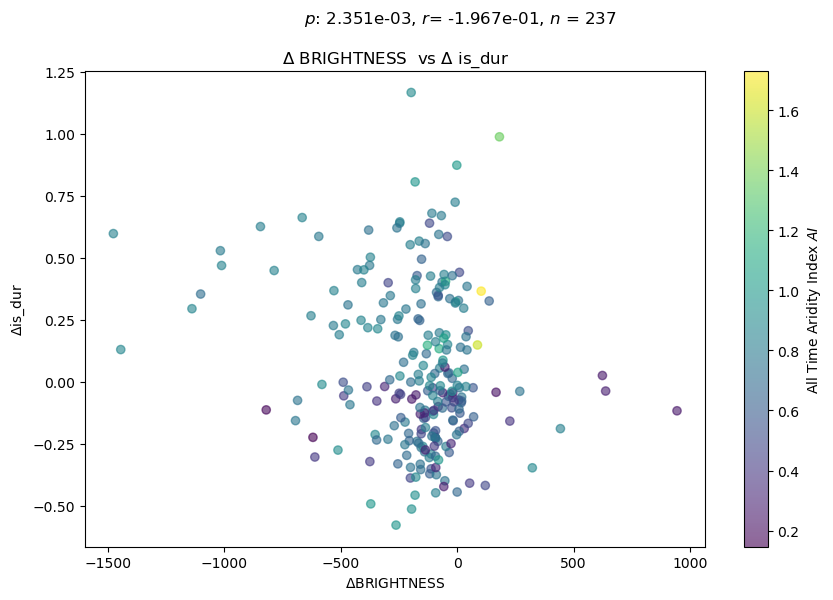

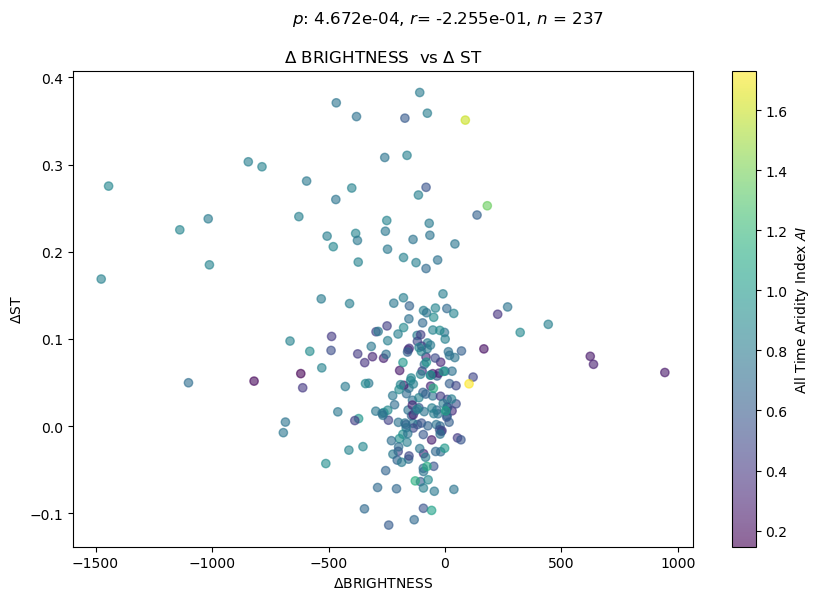

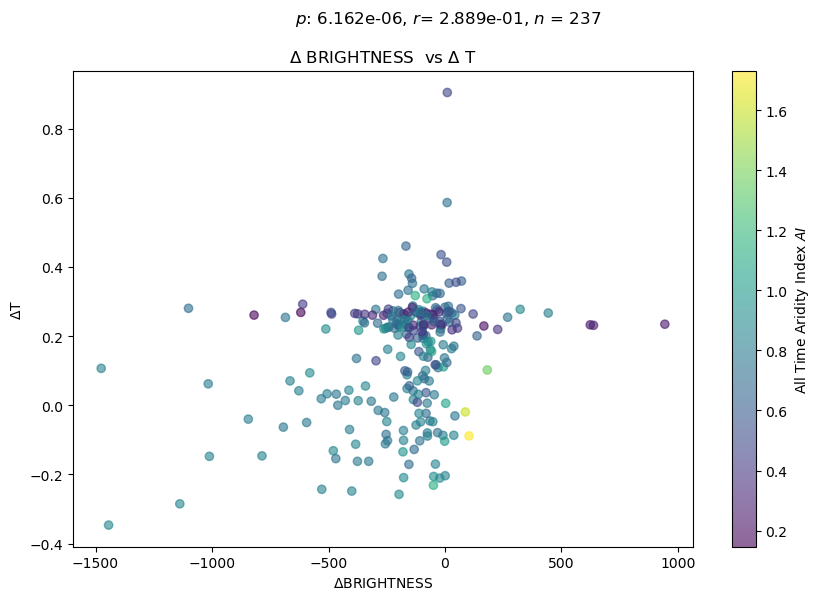

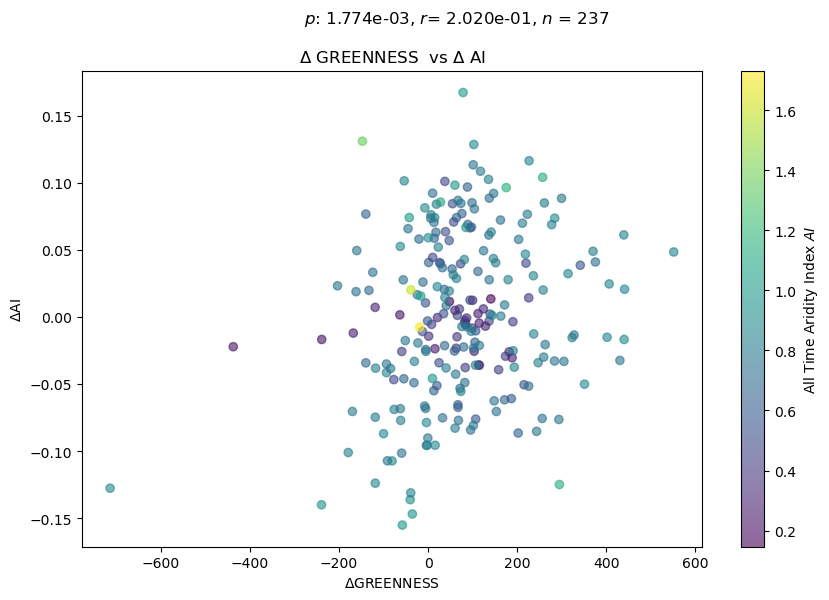

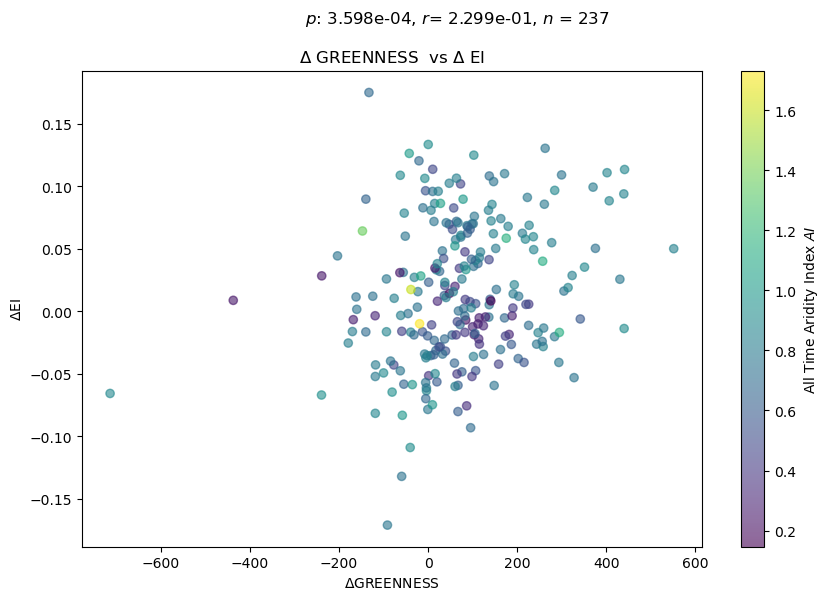

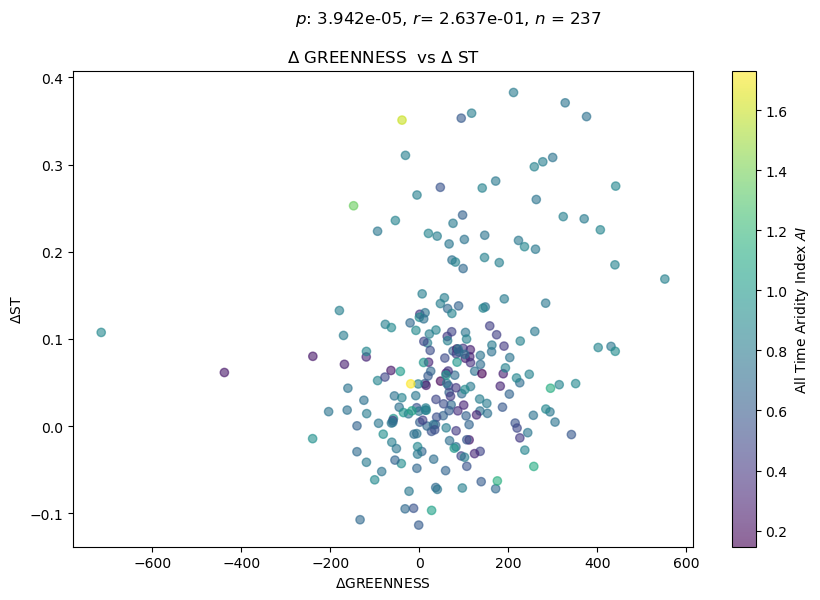

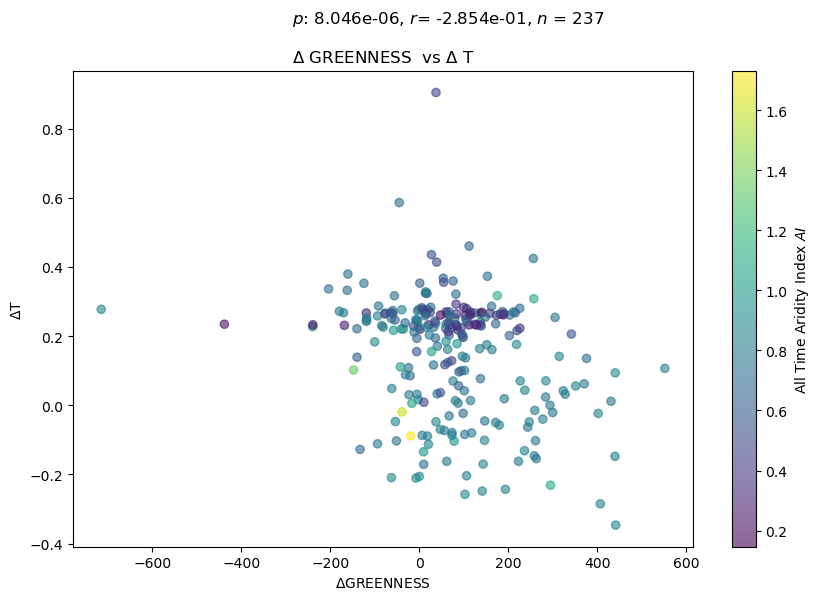

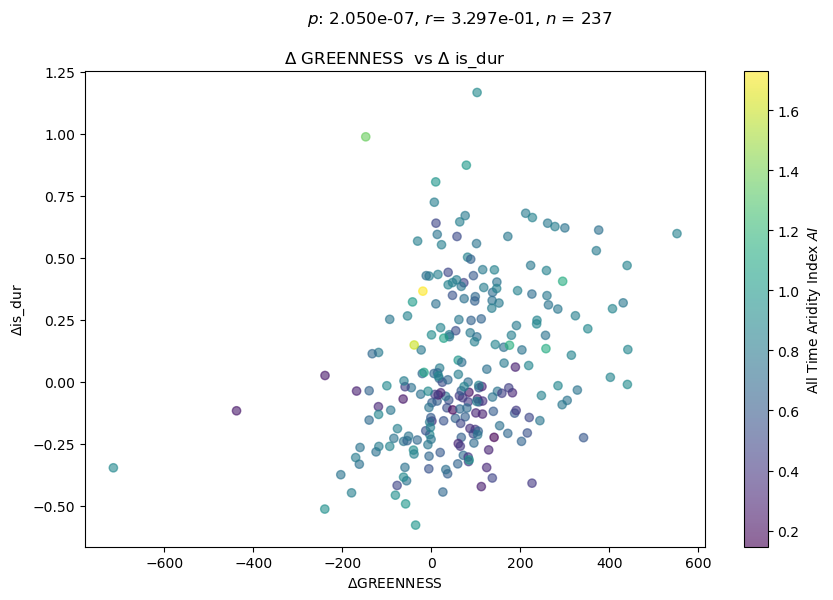

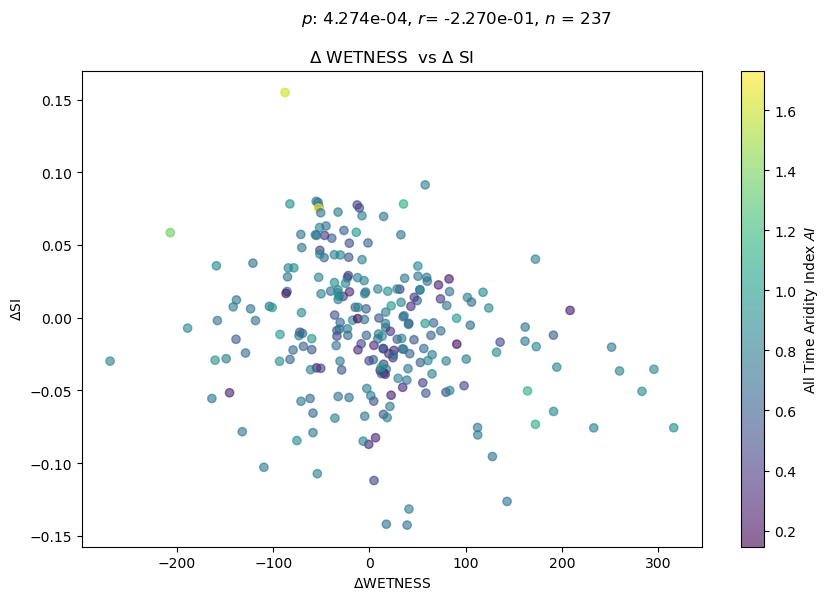

In [14]:
delta_years_levels = [1995, 1999, 2009, 2015]

delta_ranking = plot_descending_P(SR_indices, d_combo, sort_dp, d_r, SR_delta_exclude, delta=True, plot=True, savefig=True, color_by='LT_AI', levels = AI_levels)

In [365]:
df_ranked_delta = pd.DataFrame(delta_ranking, columns= ['SR_ind', 'WB_Clim_ind', 'prs_P', 'prs_R']).sort_values('prs_P')
df_ranked_delta.to_excel(f'{path}SR_delta_correlations/ranking_delta_correlatons.xlsx')
df_ranked_delta

SR_ind WB_Clim_ind         prs_P     prs_R
20       d_gndvi         d_T  3.424052e-08 -0.348962
19       d_gndvi    d_is_dur  1.348645e-07  0.334323
33   d_GREENNESS    d_is_dur  2.050014e-07  0.329696
18       d_gndvi        d_ST  1.302789e-06  0.308288
28  d_BRIGHTNESS         d_T  6.161913e-06  0.288896
32   d_GREENNESS         d_T  8.046405e-06 -0.285419
31   d_GREENNESS        d_ST  3.941898e-05  0.263682
5         d_ndvi    d_is_dur  4.572550e-05  0.261554
4         d_ndvi         d_T  5.035324e-05 -0.260161
3         d_ndvi        d_ST  3.019763e-04  0.232728
30   d_GREENNESS        d_EI  3.597752e-04  0.229868
34     d_WETNESS        d_SI  4.273671e-04 -0.227022
27  d_BRIGHTNESS        d_ST  4.671932e-04 -0.225535
17       d_gndvi        d_EI  8.423113e-04  0.215446
10         d_nbr        d_SI  1.141205e-03 -0.210065
29   d_GREENNESS        d_AI  1.773672e-03  0.202008
26  d_BRIGHTNESS    d_is_dur  2.350620e-03 -0.196701
2         d_ndvi        d_SI  3.742488e-03 -0.187633
9          d_nbr    d_is_dur  3.907881e-03  0.186769
1         d_ndvi        d_EI  9.662918e-03  0.167781
14        d_ndmi        d_SI  1.368433e-02 -0.159961
24        d_ndbi        d_SI  1.368433e-02  0.159961
23        d_ndbi    d_is_dur  1.467744e-02 -0.158347
13        d_ndmi    d_is_dur  1.467744e-02  0.158347
8          d_nbr         d_T  2.136452e-02 -0.149447
16       d_gndvi     d_omega  3.425544e-02  0.137590
15       d_gndvi        d_SI  4.060725e-02 -0.133112
7          d_nbr        d_EI  4.247704e-02  0.131907
22        d_ndbi        d_AI  4.937900e-02 -0.127812
12        d_ndmi        d_AI  4.937900e-02  0.127812
11        d_ndmi        d_EI  7.589393e-02  0.115525
21        d_ndbi        d_EI  7.589393e-02 -0.115525
0         d_ndvi     d_omega  7.714207e-02  0.115039
25  d_BRIGHTNESS        d_SI  8.482013e-02  0.112185
6          d_nbr     d_omega  8.541377e-02  0.111973

# Grouping Delta Table by Aridity

 - first gather the aridity classes per index
 - Adapt the function of plotting the aridity classes as defined by nienke

In [366]:
combo

catchment_name        AI          T        EI     gndvi  \
0               La Meuse Stenay   0.723527   9.929822  0.523830  0.630203   
1      La Vence la Francheville   0.538129   9.312353  0.409847  0.669060   
2              La Bar Cheveuges   0.600242   9.625349  0.580658  0.656230   
3    Le Loison Han-lÃ©s-Juvigny   0.638256   9.875898  0.617702  0.655333   
4         La Meuse Saint-Mihiel   0.745344   9.950750  0.515176  0.657088   
..                           ...       ...        ...       ...       ...   
342                      6918460  0.789386  13.327879  0.649748  0.661745   
343                      2408540  0.713759  16.410315  0.616032  0.691274   
345                      6814000  1.011441  11.266149  0.783979  0.603448   
347                      8086290  1.529400  17.934081  0.938728  0.465112   
348                      3366500  0.722301  12.095231  0.620866  0.677658   

           SI          B1           B4      ndvi    is_dur  ...      ndbi  \
0    0.130338  500.667264  3505.870580  0.646986  4.209709  ... -0.261393   
1    0.222241  473.134882  3854.445260  0.706225  4.320080  ... -0.279797   
2    0.190065  480.667394  3689.468405  0.688455  4.293069  ... -0.281666   
3    0.181241  451.629263  3548.118212  0.682117  4.365462  ... -0.273264   
4    0.125189  461.019370  3645.584904  0.679064  4.304854  ... -0.266628   
..        ...         ...          ...       ...       ...  ...       ...   
342  0.324501  423.576431  3541.974049  0.691508  4.960526  ... -0.209105   
343  0.246640  425.274563  3318.558560  0.759770  4.340716  ... -0.346872   
345  0.439232  460.490084  3074.025147  0.621653  5.782341  ... -0.118995   
347  0.201453  624.630277  2610.546573  0.427434  8.708571  ...  0.018127   
348  0.264864  476.026306  4033.556752  0.726509  4.174129  ... -0.290058   

         WETNESS     LT_EI          system_index       evi  country_code  \
0   -1101.055802  0.491502  00000000000000000027 -0.197836            FR   
1   -1135.365148  0.454026  0000000000000000001c -0.211074            FR   
2   -1070.187065  0.584906  00000000000000000023 -0.212935            FR   
3   -1075.027378  0.606348  00000000000000000026 -0.205451            FR   
4   -1129.484224  0.537656  00000000000000000028 -0.196861            FR   
..           ...       ...                   ...       ...           ...   
342 -1345.241732  0.681816  00000000000000000189 -0.162092           USA   
343  -704.426552  0.654095  000000000000000000ae -0.251613           USA   
345 -1582.225969  0.818152  00000000000000000179 -0.098348           USA   
347 -1926.127866  0.947938  000000000000000001c5  0.029353           USA   
348 -1180.786503  0.631306  000000000000000000eb -0.214086           USA   

              B7           B5  Unnamed: 0     LT_AI  
0    1080.063217  2075.404309           0  0.740743  
1    1059.051313  2176.186161           1  0.557612  
2    1021.925823  2084.878494           2  0.622561  
3    1013.352084  2045.911644           3  0.671355  
4    1068.602832  2117.114887           4  0.756448  
..           ...          ...         ...       ...  
342  1124.870352  2325.578170         110  0.822800  
343   677.754251  1617.640465         111  0.726084  
345  1332.083668  2418.954823         113  1.055390  
347  1691.418472  2716.352334         115  1.600147  
348  1105.150512  2240.138401         116  0.715600  

[205 rows x 30 columns]

In [367]:
labels=[f'{int(AI_levels[0])}-{int(AI_levels[1])}',
         f'{int(AI_levels[1])}-{int(AI_levels[2])}',
         f'{int(AI_levels[2])}-{int(AI_levels[3])}',
         f'{int(AI_levels[3])}-{int(AI_levels[4])}',
         f'{int(AI_levels[4])}-{int(AI_levels[5])}',
         f'{int(AI_levels[5])}-{int(AI_levels[6])}',
         f'{int(AI_levels[6])}-{int(AI_levels[7])}',
         f'{int(AI_levels[7])}-{int(AI_levels[8])}',
         f'{int(AI_levels[8])}-{int(AI_levels[9])}',]
print(labels)

['0-0', '0-0', '0-0', '0-1', '1-1', '1-1', '1-1', '1-1', '1-2']


Group: 0.2-0.4, indice: 22
Group: 0.4-0.6, indice: 34
Group: 0.6-0.8, indice: 78
Group: 0.8-1.0, indice: 61
Group: 1.0-1.2, indice: 5
Group: 1.2-1.4, indice: 1
Group: 1.4-1.6, indice: 0
Group: 1.6-1.8, indice: 2
Group: 1.8-2.0, indice: 0


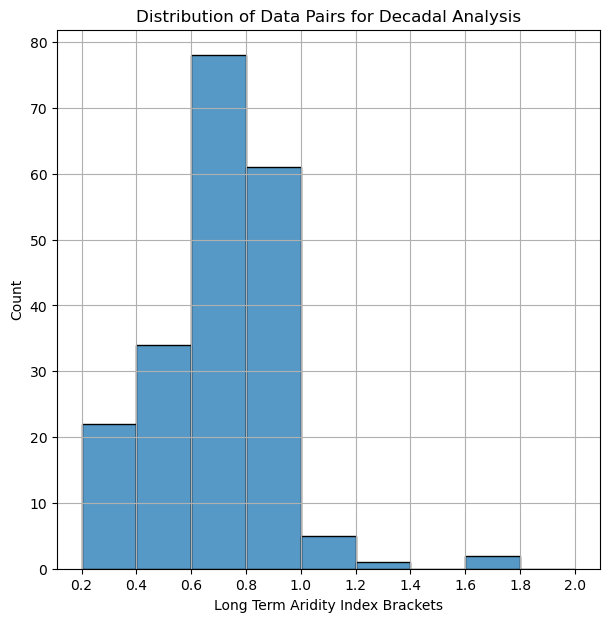

In [368]:
aridity_table1 = combo.set_index('system_index').sort_values('LT_AI')
aridity_table1['AI_group_narrow'] = pd.cut(aridity_table1['LT_AI'], AI_levels, labels=[f'{float(AI_levels[0])}-{float(AI_levels[1])}',
                                                                                     f'{float(AI_levels[1])}-{float(AI_levels[2])}',
                                                                                     f'{float(AI_levels[2])}-{float(AI_levels[3])}',
                                                                                     f'{float(AI_levels[3])}-{float(AI_levels[4])}',
                                                                                     f'{float(AI_levels[4])}-{float(AI_levels[5])}',
                                                                                     f'{float(AI_levels[5])}-{float(AI_levels[6])}',
                                                                                     f'{float(AI_levels[6])}-{float(AI_levels[7])}',
                                                                                     f'{float(AI_levels[7])}-{float(AI_levels[8])}',
                                                                                     f'{float(AI_levels[8])}-{float(AI_levels[9])}',], ordered=True)
grouped1 = aridity_table1.groupby('AI_group_narrow')
colors9 = ['#FFFFFF','#009B77', '#6CC24A','#FFB81C', '#EC6842', '#A50034', '#222222', '#222222', '#222222']
palette_9 = sns.color_palette(colors9)
dist = []

for group, indices in grouped1.indices.items():
    
    print(f"Group: {group}, indice: {len(indices)}")
    dist.append(len(indices))

colors5 = ['#009B77', '#6CC24A','#FFB81C', '#EC6842', '#A50034']

#222222
fig = plt.figure(figsize=(7, 7))
sns.histplot(aridity_table1.LT_AI, bins=AI_levels)
plt.xticks(AI_levels)
plt.xlabel('Long Term Aridity Index Brackets')
plt.grid()
plt.title('Distribution of Data Pairs for Decadal Analysis');

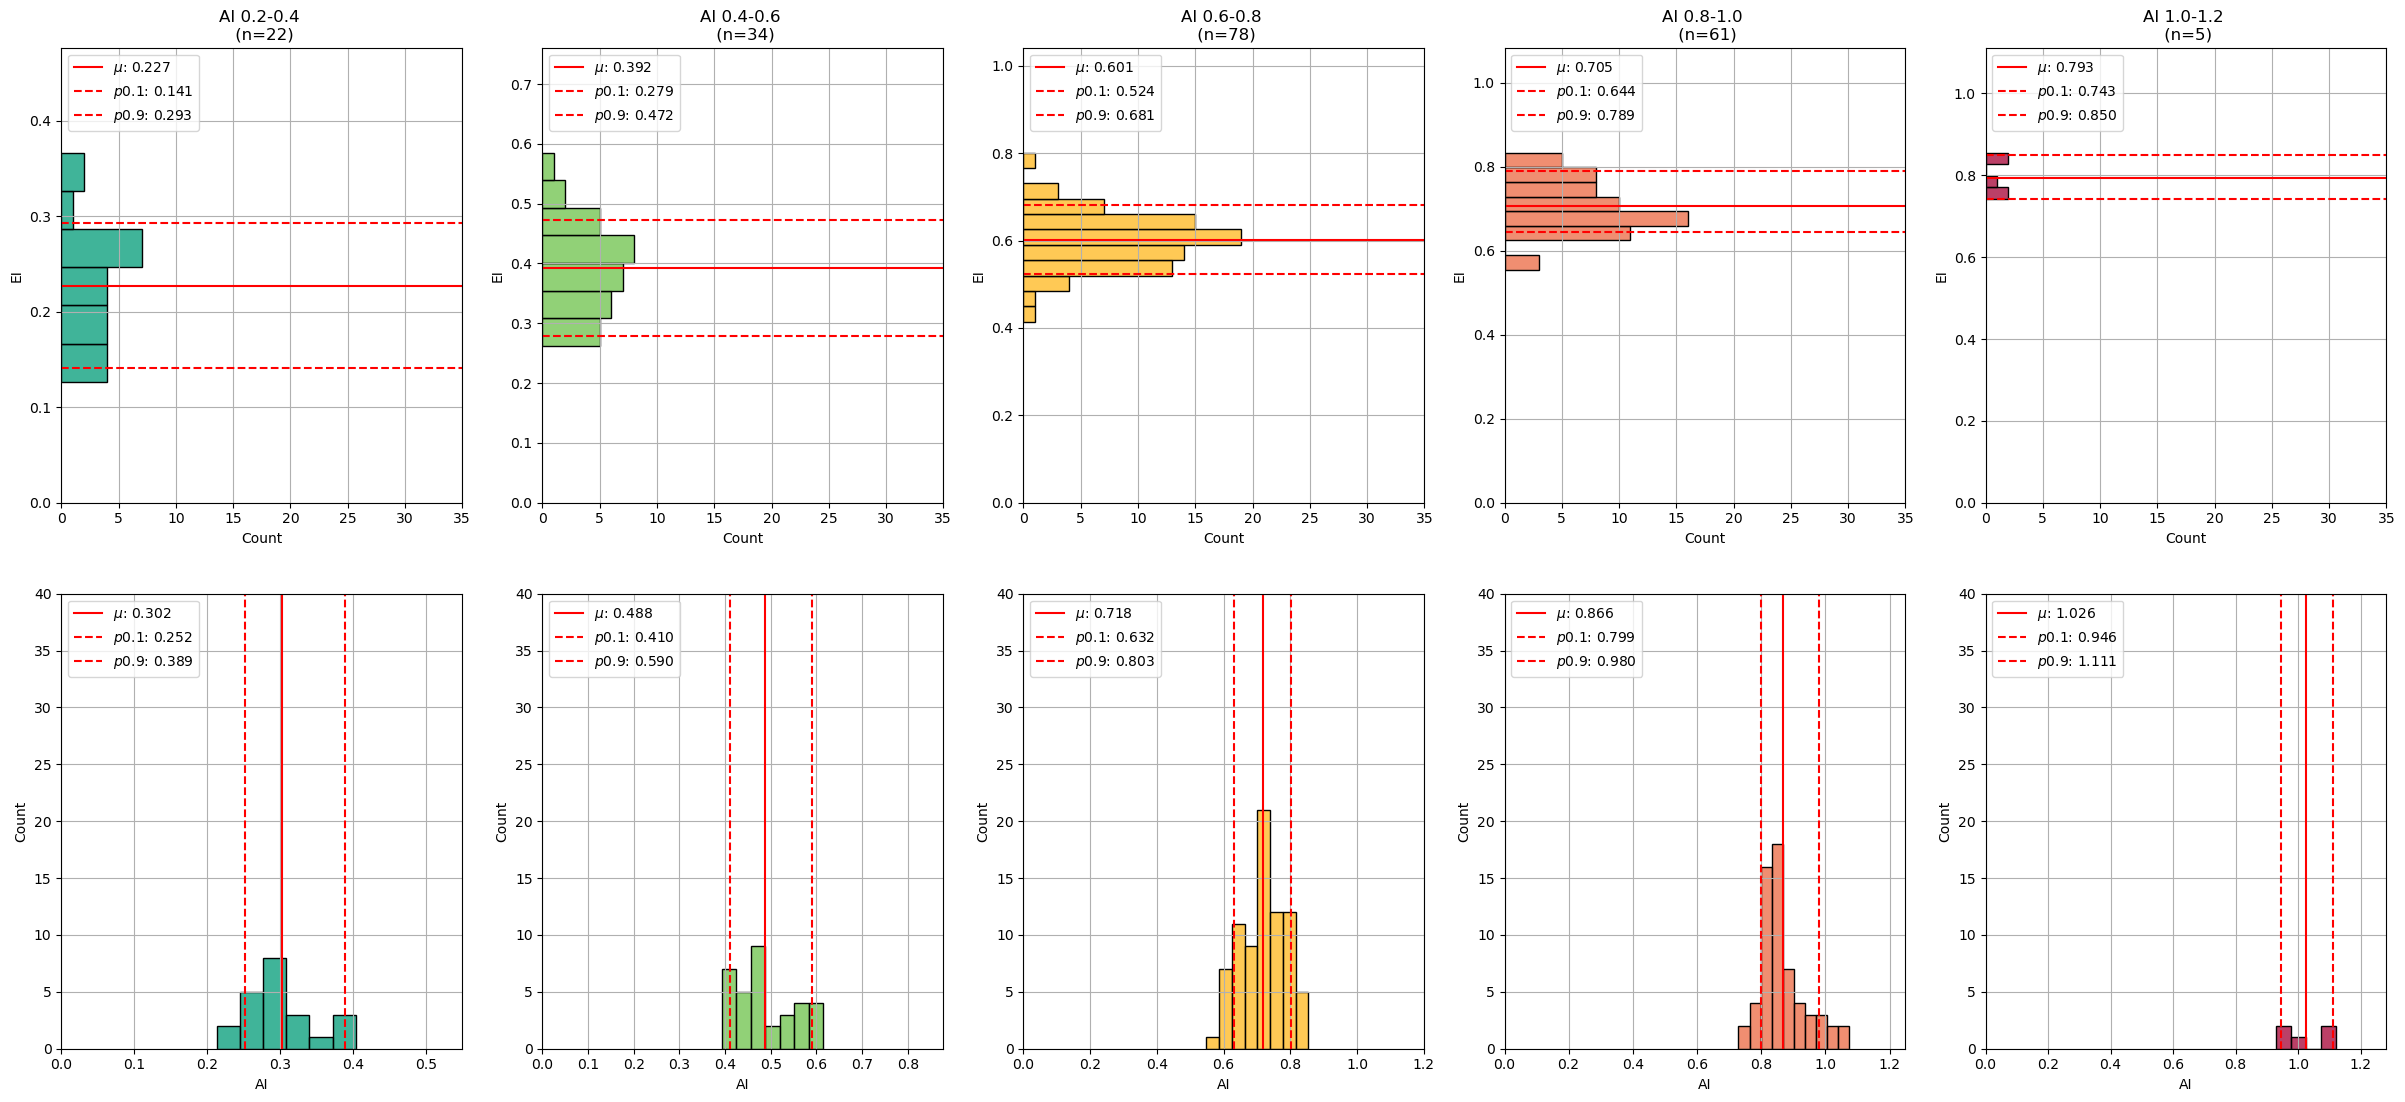

In [369]:
fig, ax = plt.subplots(2, 5, figsize=(30, 13))

n = []

index = np.arange(0, 6)


for i, (group, data) in enumerate(grouped1):
    #if group is not None:
    #    print(data)
    #    break
    
    # lim = np.max(abs(aridity_table.iloc[int(indice[0]):int(indice[-1])].loc[:, 'd_EI']))
    lim = np.max(abs(data.loc[:, 'EI']))
    
    
    if len(data) >0 and lim <1 and i <5:  
        n=0
        
        x1 = data.EI
        #x1.plot.hist(ax=ax[n,i], alpha=0.5, label=group, color='lime')#, sharey=True)
        sns.histplot(y=x1, ax=ax[0,i], color = colors5[i], orientation='horizontal')
        #x = aridity_table.iloc[int(indice[0]):int(indice[-1])].loc[:, 'd_EI']
        
        mu = np.mean(x1)
        
        p10 = np.percentile(x1, 10)
        
        p90 = np.percentile(x1, 90)
        
        #x.plot.hist(alpha=0.5)#, label=f'{group}, n= {len(indice)}', edgecolor='black', linewidth=1.2, ax=ax1)
        
        ax[0,i].set_ylabel(f'EI')
        ax[0,i].set_title(f'AI {group} \n (n={len(data)})')
        #ax.axvline(np.mean(aridity_table.iloc[int(indice[0]):int(indice[-1])].loc[:, 'LT_EI']))
        #plt.grid(visible=True, alpha=0.5)
        ax[0,i].axhline(mu, c='r', label=f'$\mu$: {mu:.3f}')
        ax[0,i].axhline(p10, c='r', ls='--', label=f'$p0.1$: {p10:.3f}')
        ax[0,i].axhline(p90, c='r', ls='--', label=f'$p0.9$: {p90:.3f}')
        ax[0,i].set_ylim(0, lim*1.3)
        ax[0,i].set_xlim(0, 35)
        ax[0,i].grid()
        ax[0,i].legend(loc='upper left')
        
    
    lim = np.max(abs(data.loc[:, 'EI']))
    
    if len(data) >0 and lim <1 and i <5:  
        n=2
        #ax[1,i].add_subplot(sharey=True)
        x1 = data.AI
        #x1.plot.hist(ax=ax[n,i], alpha=0.5, label=group)#, sharey=True)
        sns.histplot(x=x1, ax=ax[1, i], color = colors5[i])
        #x = aridity_table.iloc[int(indice[0]):int(indice[-1])].loc[:, 'd_EI']
        
        mu = np.mean(x1)
        
        p10 = np.percentile(x1, 10)
        
        p90 = np.percentile(x1, 90)
        
        ax[1,i].set_xlabel(f'AI')
        #ax[n,i].set_title(f'EI {group}')
        #ax.axvline(np.mean(aridity_table.iloc[int(indice[0]):int(indice[-1])].loc[:, 'LT_EI']))
        #plt.grid(visible=True, alpha=0.5)
        #ax[1,i].set_title(f'AI {group} \n (n={len(data)})')
        ax[1,i].axvline(mu, c='r', label=f'$\mu$: {mu:.3f}')
        ax[1,i].axvline(p10, c='r', ls='--', label=f'$p0.1$: {p10:.3f}')
        ax[1,i].axvline(p90, c='r', ls='--', label=f'$p0.9$: {p90:.3f}')
        ax[1,i].set_xlim(0, lim*1.5)
        ax[1,i].set_ylim(0, 40)
        ax[1,i].grid()
        ax[1,i].legend(loc='upper left')
    
    
    
    #gp +=1
        
    


Group: 0.2-0.4, indice: 22
Group: 0.4-0.6, indice: 37
Group: 0.6-0.8, indice: 97
Group: 0.8-1.0, indice: 69
Group: 1.0-1.2, indice: 7
Group: 1.2-1.4, indice: 1
Group: 1.4-1.6, indice: 0
Group: 1.6-1.8, indice: 2
Group: 1.8-2.0, indice: 0


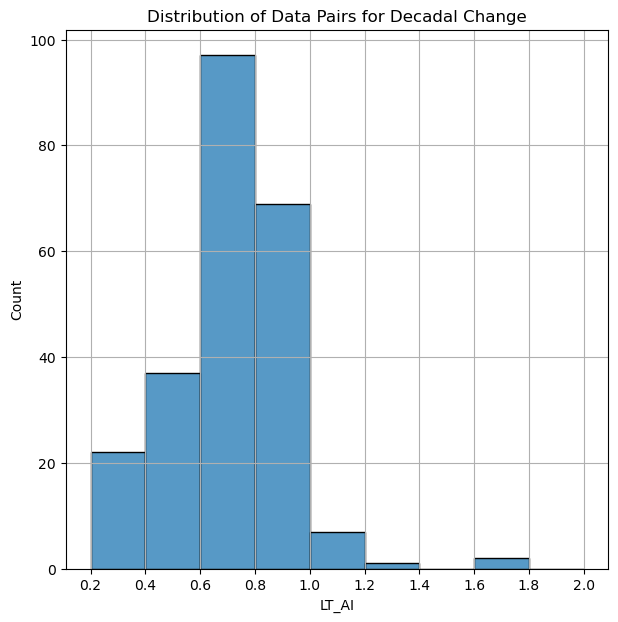

In [370]:
aridity_table = d_combo.set_index('system_index').sort_values('LT_AI')
aridity_table['AI_group_narrow'] = pd.cut(aridity_table['LT_AI'], AI_levels, labels=[f'{float(AI_levels[0])}-{float(AI_levels[1])}',
                                                                                     f'{float(AI_levels[1])}-{float(AI_levels[2])}',
                                                                                     f'{float(AI_levels[2])}-{float(AI_levels[3])}',
                                                                                     f'{float(AI_levels[3])}-{float(AI_levels[4])}',
                                                                                     f'{float(AI_levels[4])}-{float(AI_levels[5])}',
                                                                                     f'{float(AI_levels[5])}-{float(AI_levels[6])}',
                                                                                     f'{float(AI_levels[6])}-{float(AI_levels[7])}',
                                                                                     f'{float(AI_levels[7])}-{float(AI_levels[8])}',
                                                                                     f'{float(AI_levels[8])}-{float(AI_levels[9])}',], ordered=True)
grouped = aridity_table.groupby('AI_group_narrow')

dist = []

for group, indices in grouped.indices.items():
    
    print(f"Group: {group}, indice: {len(indices)}")
    dist.append(len(indices))

colors5 = ['#009B77', '#6CC24A','#FFB81C', '#EC6842', '#A50034']

#222222
fig = plt.figure(figsize=(7, 7))
sns.histplot(aridity_table.LT_AI, bins=AI_levels)
plt.xticks(AI_levels)
plt.grid()
plt.title('Distribution of Data Pairs for Decadal Change');

In [371]:
combo

catchment_name        AI          T        EI     gndvi  \
0               La Meuse Stenay   0.723527   9.929822  0.523830  0.630203   
1      La Vence la Francheville   0.538129   9.312353  0.409847  0.669060   
2              La Bar Cheveuges   0.600242   9.625349  0.580658  0.656230   
3    Le Loison Han-lÃ©s-Juvigny   0.638256   9.875898  0.617702  0.655333   
4         La Meuse Saint-Mihiel   0.745344   9.950750  0.515176  0.657088   
..                           ...       ...        ...       ...       ...   
342                      6918460  0.789386  13.327879  0.649748  0.661745   
343                      2408540  0.713759  16.410315  0.616032  0.691274   
345                      6814000  1.011441  11.266149  0.783979  0.603448   
347                      8086290  1.529400  17.934081  0.938728  0.465112   
348                      3366500  0.722301  12.095231  0.620866  0.677658   

           SI          B1           B4      ndvi    is_dur  ...      ndbi  \
0    0.130338  500.667264  3505.870580  0.646986  4.209709  ... -0.261393   
1    0.222241  473.134882  3854.445260  0.706225  4.320080  ... -0.279797   
2    0.190065  480.667394  3689.468405  0.688455  4.293069  ... -0.281666   
3    0.181241  451.629263  3548.118212  0.682117  4.365462  ... -0.273264   
4    0.125189  461.019370  3645.584904  0.679064  4.304854  ... -0.266628   
..        ...         ...          ...       ...       ...  ...       ...   
342  0.324501  423.576431  3541.974049  0.691508  4.960526  ... -0.209105   
343  0.246640  425.274563  3318.558560  0.759770  4.340716  ... -0.346872   
345  0.439232  460.490084  3074.025147  0.621653  5.782341  ... -0.118995   
347  0.201453  624.630277  2610.546573  0.427434  8.708571  ...  0.018127   
348  0.264864  476.026306  4033.556752  0.726509  4.174129  ... -0.290058   

         WETNESS     LT_EI          system_index       evi  country_code  \
0   -1101.055802  0.491502  00000000000000000027 -0.197836            FR   
1   -1135.365148  0.454026  0000000000000000001c -0.211074            FR   
2   -1070.187065  0.584906  00000000000000000023 -0.212935            FR   
3   -1075.027378  0.606348  00000000000000000026 -0.205451            FR   
4   -1129.484224  0.537656  00000000000000000028 -0.196861            FR   
..           ...       ...                   ...       ...           ...   
342 -1345.241732  0.681816  00000000000000000189 -0.162092           USA   
343  -704.426552  0.654095  000000000000000000ae -0.251613           USA   
345 -1582.225969  0.818152  00000000000000000179 -0.098348           USA   
347 -1926.127866  0.947938  000000000000000001c5  0.029353           USA   
348 -1180.786503  0.631306  000000000000000000eb -0.214086           USA   

              B7           B5  Unnamed: 0     LT_AI  
0    1080.063217  2075.404309           0  0.740743  
1    1059.051313  2176.186161           1  0.557612  
2    1021.925823  2084.878494           2  0.622561  
3    1013.352084  2045.911644           3  0.671355  
4    1068.602832  2117.114887           4  0.756448  
..           ...          ...         ...       ...  
342  1124.870352  2325.578170         110  0.822800  
343   677.754251  1617.640465         111  0.726084  
345  1332.083668  2418.954823         113  1.055390  
347  1691.418472  2716.352334         115  1.600147  
348  1105.150512  2240.138401         116  0.715600  

[205 rows x 30 columns]

In [372]:
def w_function(AI, w):
    EI = 1 + AI - (1 + (AI**w))**(1/w)
    return EI

plt.figure(99)
def many_w_curves():
    for i, (group, indices) in enumerate(grouped1):
        ls_EI = []
        ls_AI = []
        if i <=4:
            AI = np.linspace(AI_levels[i], AI_levels[i+1], 150)
            w = grouped1.mean()['omega'][i]
            EI_curve = w_function(AI, w)
            plt.plot(AI, EI_curve, linewidth=2, c=colors5[i], label=f'mean $\omega$ ={w:.3f}, AI: {group}')
            ls_EI.append(EI_curve)
            ls_AI.append(AI)
         
        else:
            break
    return [ls_EI, ls_AI]

#def fill_between_curves():

<Figure size 640x480 with 0 Axes>

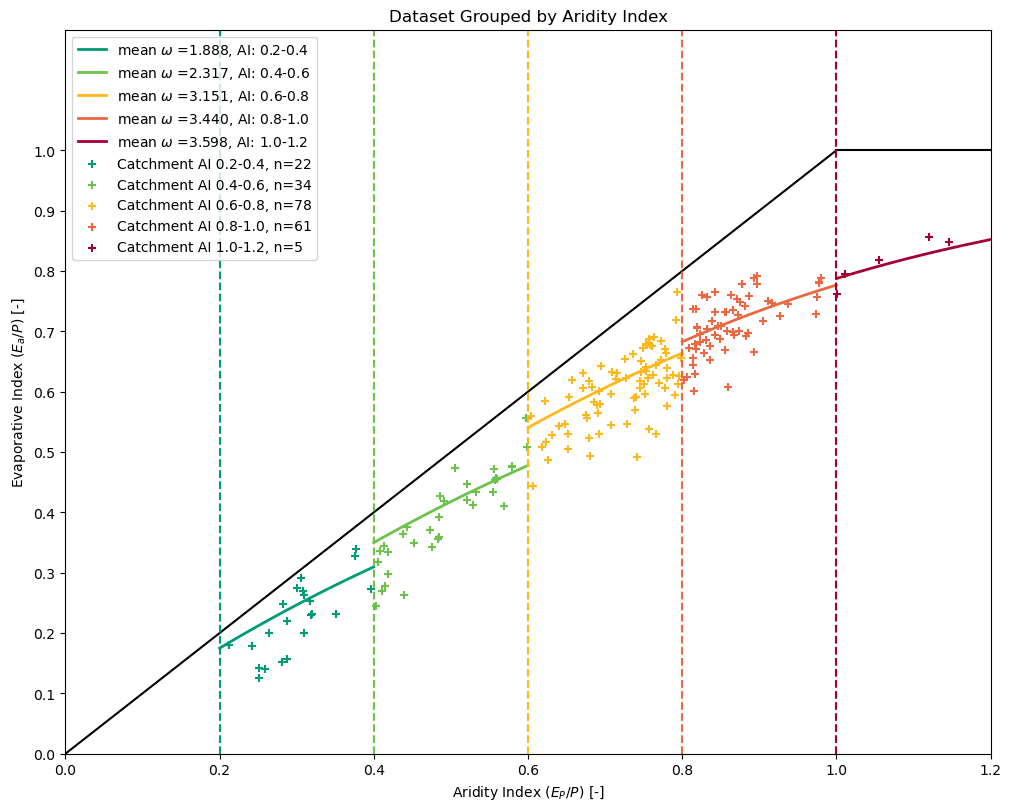

In [413]:
from matplotlib.colors import ListedColormap
from itertools  import chain

colors5 = ['#009B77', '#6CC24A','#FFB81C', '#EC6842', '#A50034']
colors9 = ['#FFFFFF','#009B77', '#6CC24A','#FFB81C', '#EC6842', '#A50034', '#222222', '#222222', '#222222']

budyko_curve_x = np.arange(1, 2, 0.05)
energy_limit_x = np.arange(0, 1.0001, 0.05)
x = np.arange(0, 1.0001, 0.05)
water_limit_y = 1 + budyko_curve_x*0
energy_limit_y = energy_limit_x
y = 1 + x*0

levels = [0, 0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6, 1.8, 2]

fig, ax = plt.subplots(1, constrained_layout=True, figsize=(10,8))

plt.ylabel(f"Evaporative Index ($E_a/P$) [-]")
plt.xlabel(f"Aridity Index ($E_P/P$) [-]")

plt.ylim(0, 1.2)

plt.plot(energy_limit_x, energy_limit_y, c='k')
plt.plot(budyko_curve_x, water_limit_y,c='k')
plt.plot()

plt.yticks([0,0.1,0.2,0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.xticks([0,0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0]);

ls_EI, ls_AI = many_w_curves()

combo = combo.drop_duplicates(subset='system_index', keep='first')

for i in range(len(colors5)):
    mask = (combo['LT_AI'] >= AI_levels[i]) & (combo['LT_AI'] <= AI_levels[i+1])
    masked = combo[mask]
    scatter1 = ax.scatter(masked.LT_AI, masked.LT_EI, c = colors5[i], label=f'Catchment AI {list(grouped1.groups.keys())[i]}, n={len(list(grouped1.groups.values())[i])}', marker='+')

for i, level in enumerate(levels[1:6]):
    plt.axvline(level, ymax=1, linestyle='dashed', color=colors5[i])


#cbar.set_ticks(AI_levels)
#cbar.set_ticklabels(colors9)

plt.title('Dataset Grouped by Aridity Index')
plt.xlim(0,1.2)

plt.legend()



In [414]:
from scipy.stats import linregress

[0.5093313170903254, 0.4937858380512148, 0.483530068021867, 0.40172306951312875, 0.29766824758779503]


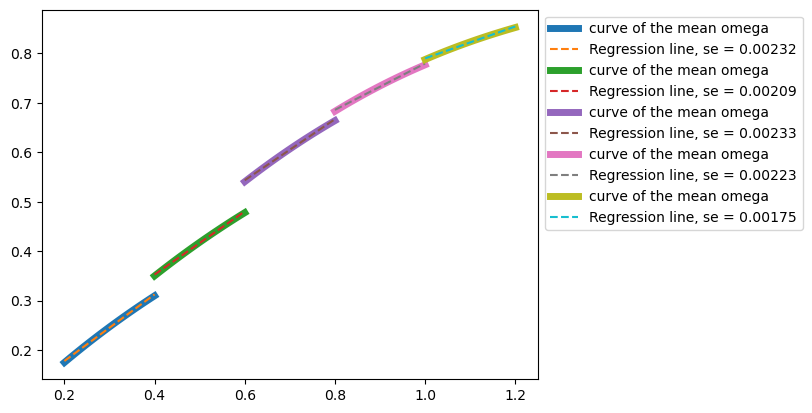

In [415]:
n = []

mean_w = []
w_slope = []
w_slope_rad = []

for i, (group, data) in enumerate(grouped1):
    w = grouped1.mean()['omega'][i]
    x0 = AI_levels[i]
    x1 = AI_levels[i+1]
    x = np.linspace(x0, x1, 100)
    y = w_function(x, w)
    slope, intercept, r, p, se = linregress(x, y)
    slope_radians = np.arctan(slope / np.sqrt(1 + slope**2))
    w_slope_rad.append(slope_radians)
    
    plt.plot(x, y, linewidth=5, label='curve of the mean omega')
    plt.plot(x, slope*x + intercept, linestyle='dashed', label=f'Regression line, se = {se:.5f}')

    if i == 4:
        break

plt.legend(bbox_to_anchor=(1,1))

print(w_slope_rad)

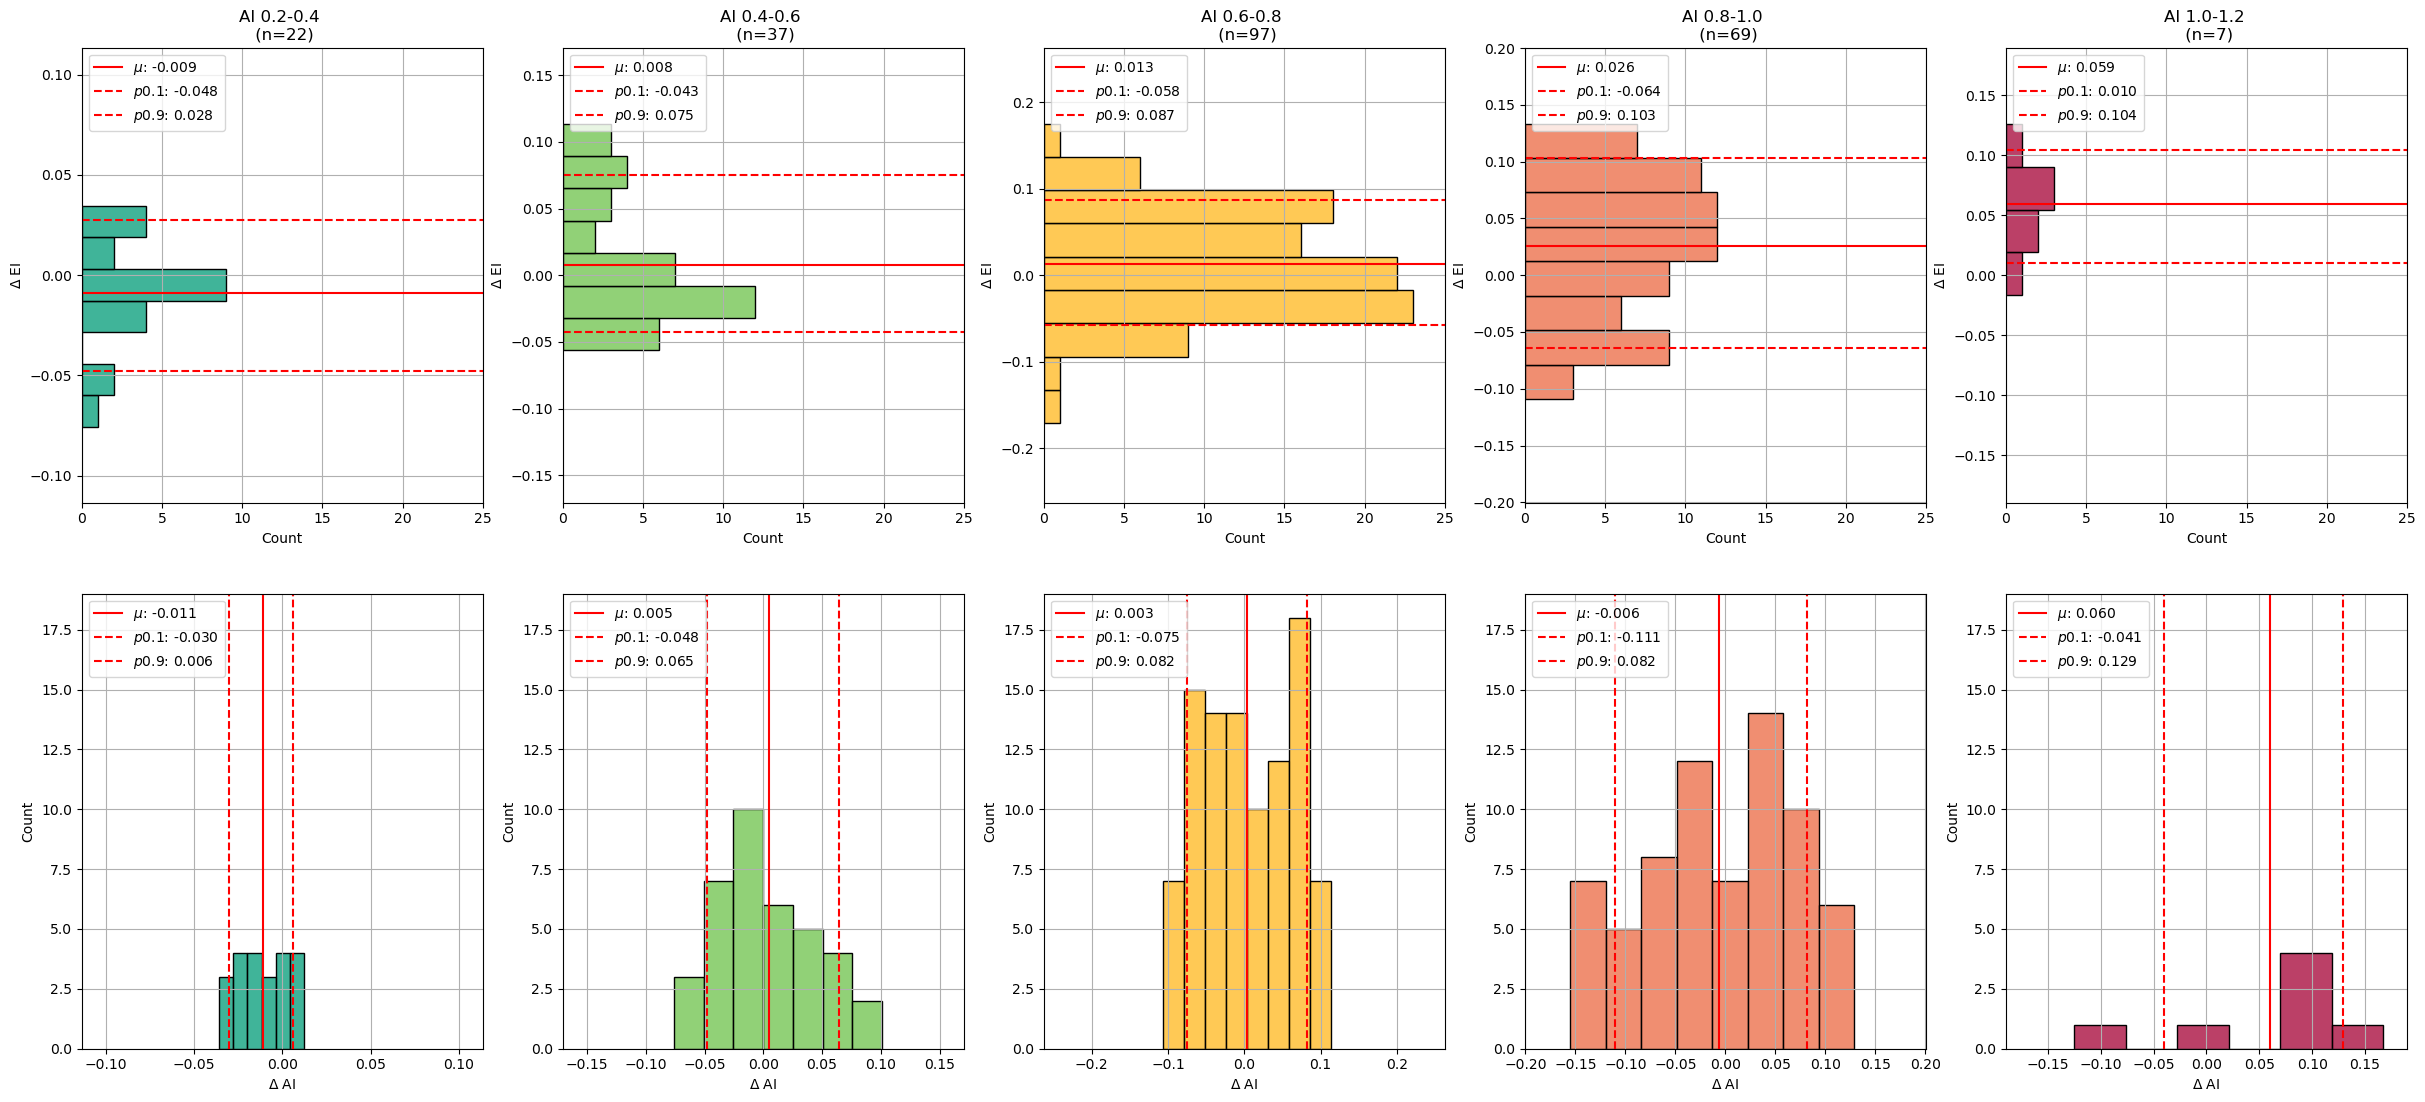

In [416]:
fig, ax = plt.subplots(2, 5, figsize=(30, 13))
for i, (group, data) in enumerate(grouped):
    #if group is not None:
    #    print(data)
    #    break
    
    # lim = np.max(abs(aridity_table.iloc[int(indice[0]):int(indice[-1])].loc[:, 'd_EI']))
    lim = np.max(abs(data.loc[:, 'd_EI']))
    
    
    if len(data) >0 and lim <1 and i <5:  
        n=0
        
        x1 = data.d_EI
        #x1.plot.hist(ax=ax[n,i], alpha=0.5, label=group, color='lime')#, sharey=True)
        sns.histplot(y=x1, ax=ax[0,i], color = colors5[i], orientation='horizontal')
        #x = aridity_table.iloc[int(indice[0]):int(indice[-1])].loc[:, 'd_EI']
        
        mu = np.mean(x1)
        
        p10 = np.percentile(x1, 10)
        
        p90 = np.percentile(x1, 90)
        
        #x.plot.hist(alpha=0.5)#, label=f'{group}, n= {len(indice)}', edgecolor='black', linewidth=1.2, ax=ax1)
        
        ax[0,i].set_ylabel(f'$\Delta$ EI')
        ax[0,i].set_title(f'AI {group} \n (n={len(data)})')
        #ax.axvline(np.mean(aridity_table.iloc[int(indice[0]):int(indice[-1])].loc[:, 'LT_EI']))
        #plt.grid(visible=True, alpha=0.5)
        ax[0,i].axhline(mu, c='r', label=f'$\mu$: {mu:.3f}')
        ax[0,i].axhline(p10, c='r', ls='--', label=f'$p0.1$: {p10:.3f}')
        ax[0,i].axhline(p90, c='r', ls='--', label=f'$p0.9$: {p90:.3f}')
        ax[0,i].set_ylim(-lim*1.5, lim*1.5)
        ax[0,i].set_xlim(0, 25)
        ax[0,i].grid()
        ax[0,i].legend(loc='upper left')
        
    
    lim = np.max(abs(data.loc[:, 'd_EI']))
    
    if len(data) >0 and lim <1 and i <5:  
        n=2
        #ax[1,i].add_subplot(sharey=True)
        x1 = data.d_AI
        #x1.plot.hist(ax=ax[n,i], alpha=0.5, label=group)#, sharey=True)
        sns.histplot(x=x1, ax=ax[1, i], color = colors5[i])
        #x = aridity_table.iloc[int(indice[0]):int(indice[-1])].loc[:, 'd_EI']
        
        mu = np.mean(x1)
        
        p10 = np.percentile(x1, 10)
        
        p90 = np.percentile(x1, 90)
        
        ax[1,i].set_xlabel(f'$\Delta$ AI')
        #ax[n,i].set_title(f'EI {group}')
        #ax.axvline(np.mean(aridity_table.iloc[int(indice[0]):int(indice[-1])].loc[:, 'LT_EI']))
        #plt.grid(visible=True, alpha=0.5)
        #ax[1,i].set_title(f'AI {group} \n (n={len(data)})')
        ax[1,i].axvline(mu, c='r', label=f'$\mu$: {mu:.3f}')
        ax[1,i].axvline(p10, c='r', ls='--', label=f'$p0.1$: {p10:.3f}')
        ax[1,i].axvline(p90, c='r', ls='--', label=f'$p0.9$: {p90:.3f}')
        ax[1,i].set_xlim(-lim*1.5, lim*1.5)
        ax[1,i].set_ylim(0, 19)
        ax[1,i].grid()
        ax[1,i].legend(loc='upper left')
    
    
    
    #gp +=1
        
    

C:\Users\creeb\AppData\Local\Temp\ipykernel_27144\3953526894.py:11: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  hist, _ = np.histogram(angles, bins=bins, normed=True)


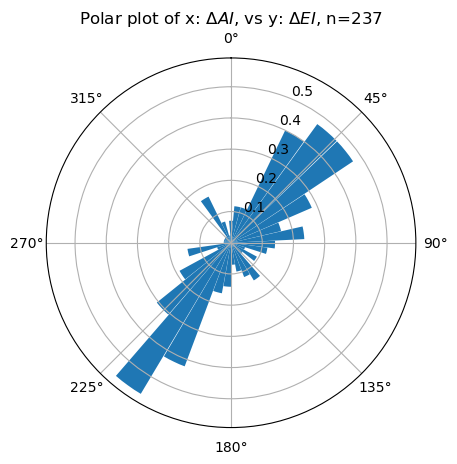

In [417]:
df = d_combo

# Get the angle and magnitude of each data point
angles = np.arctan2(df['d_EI'], df['d_AI'])
magnitudes = np.sqrt(df['d_AI']**2 + df['d_EI']**2)

# Create bins for the angles
bins = np.linspace(-np.pi, np.pi, num=36)

# Create a histogram of the angles
hist, _ = np.histogram(angles, bins=bins, normed=True)

# Plot the rose diagram
ax = plt.subplot(projection='polar')
ax.bar(bins[:-1], hist, width=2*np.pi/36, align='edge', bottom=0)
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.set_title(f"Polar plot of x: $\Delta AI$, vs y: $\Delta EI$, n={len(d_combo)}")
plt.show()

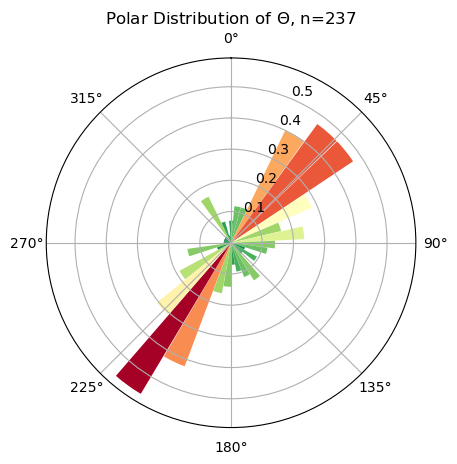

In [418]:
df = d_combo

# Get the angle and magnitude of each data point
angles = np.arctan2(df['d_EI'], df['d_AI'])
magnitudes = np.sqrt(df['d_AI']**2 + df['d_EI']**2)

# Create bins for the angles
bins = np.linspace(-np.pi, np.pi, num=36)

# Create a histogram of the angles
hist, _ = np.histogram(angles, bins=bins, density=True)
# Define the colormap
cmap = plt.cm.get_cmap('RdYlGn_r')

# Plot the rose diagram with colored bars
ax = plt.subplot(projection='polar')
bar_colors = cmap(hist / np.max(hist))
ax.bar(bins[:-1], hist, width=2*np.pi/36, align='edge', bottom=0, color=bar_colors)
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.set_title(f"Polar Distribution of $\Theta$, n={len(d_combo)}")
plt.show()

## Plotting polar distributions of movement within the budyko framework

magnitude = v = √((x2 – x1)^2 + (y2 – y1)^2)

direction and magnitude of movement within the framework

IndexError: index 5 is out of bounds for axis 0 with size 5

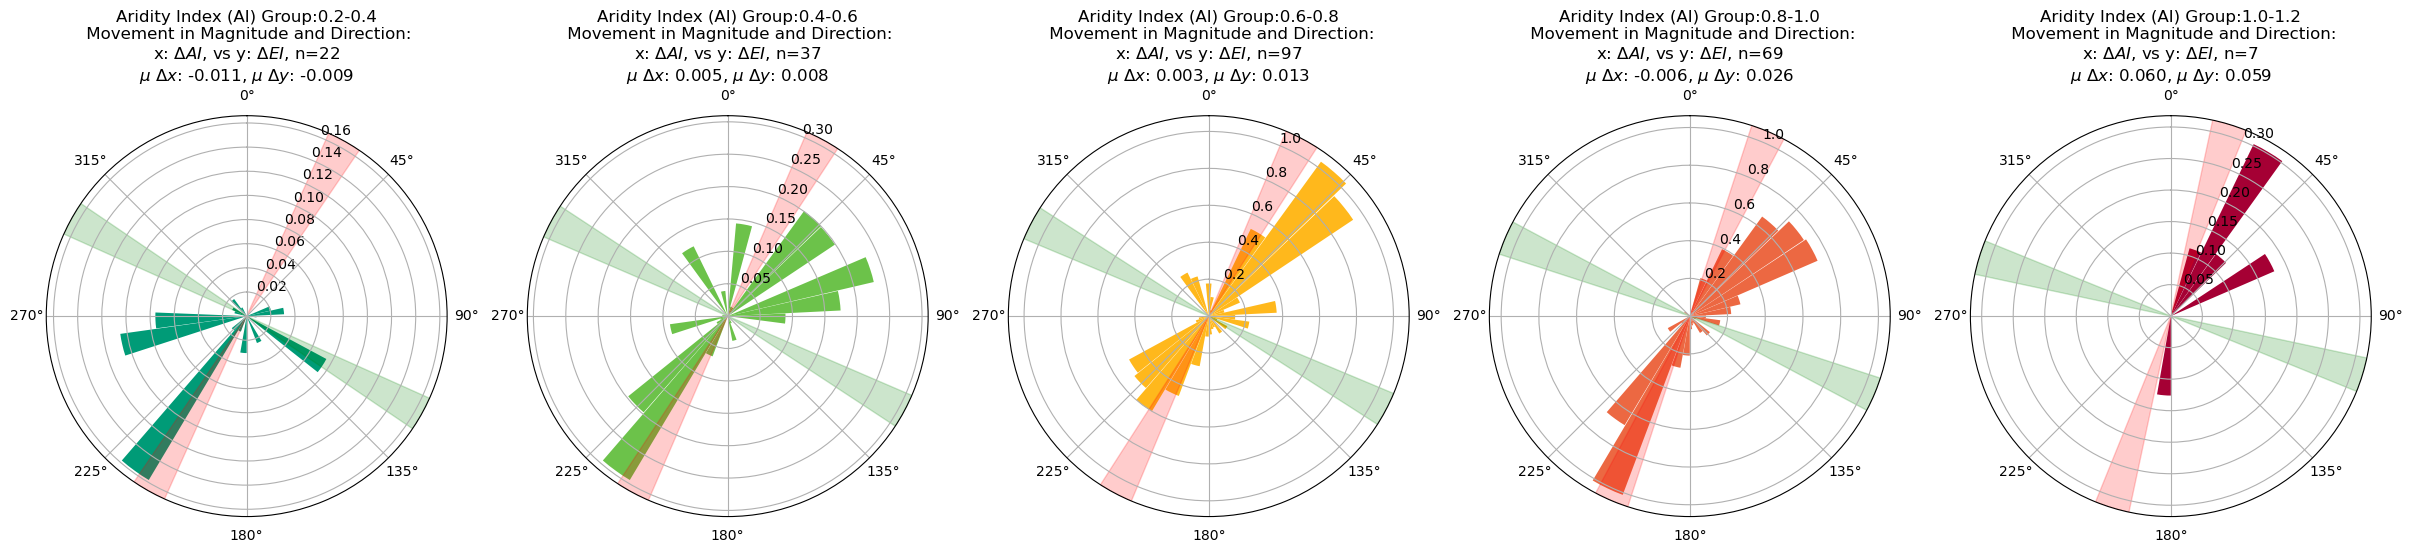

In [379]:
fig, ax = plt.subplots(1, 5, figsize=(30, 7.5))
n=0

index = np.arange(1,6)

for i, (group, df) in enumerate(grouped):
    if n <=5:
    
        y= df['d_EI']
        x=df['d_AI']

        mu_x = np.mean(x)
        mu_y = np.mean(y)

        # Get the angle and magnitude of each data point
        angles = np.arctan2(y,x)
        magnitudes = np.sqrt(x**2 + y**2)

        # Create bins for the angles
        bins = np.linspace(-np.pi, np.pi, num=36)

        # Create a histogram of the angles
        hist, _ = np.histogram(angles, bins=bins, weights=magnitudes)
        
        
        # Plot the rose diagram
        ax = plt.subplot(1,5, index[n], projection='polar')
        ax.bar(bins[:-1], hist, width=2*np.pi/36, align='edge', bottom=0, color=colors5[n])

        ax.axvspan(w_slope_rad[n] + (2*np.pi/72), w_slope_rad[n] - (2*np.pi/72), alpha=0.2, color='red')
            
        ax.axvspan(w_slope_rad[n] + np.pi/2 + (2*np.pi/72), w_slope_rad[n]+ np.pi/2 - (2*np.pi/72), alpha=0.2, color='green')
        
        ax.axvspan(w_slope_rad[n] - np.pi/2 + (2*np.pi/72), w_slope_rad[n]- np.pi/2 - (2*np.pi/72), alpha=0.2, color='green')

        ax.axvspan(w_slope_rad[n]-np.pi + (2*np.pi/72), w_slope_rad[n]-np.pi - (2*np.pi/72), alpha=0.2, color='red')
        
        #ax.set_ylim(0,1.1)
        ax.set_theta_zero_location("N")
        ax.set_theta_direction(-1)
        #ax.suptitle(f'AI group: {group}')
        ax.set_title(f"Aridity Index (AI) Group:{group}\n Movement in Magnitude and Direction:\nx: $\Delta AI$, vs y: $\Delta EI$, n={len(df)}\n$\mu$ $\Delta x$: {mu_x:.3f}, $\mu$ $\Delta y$: {mu_y:.3f}")
        n+=1
    else:
        break

IndexError: index 5 is out of bounds for axis 0 with size 5

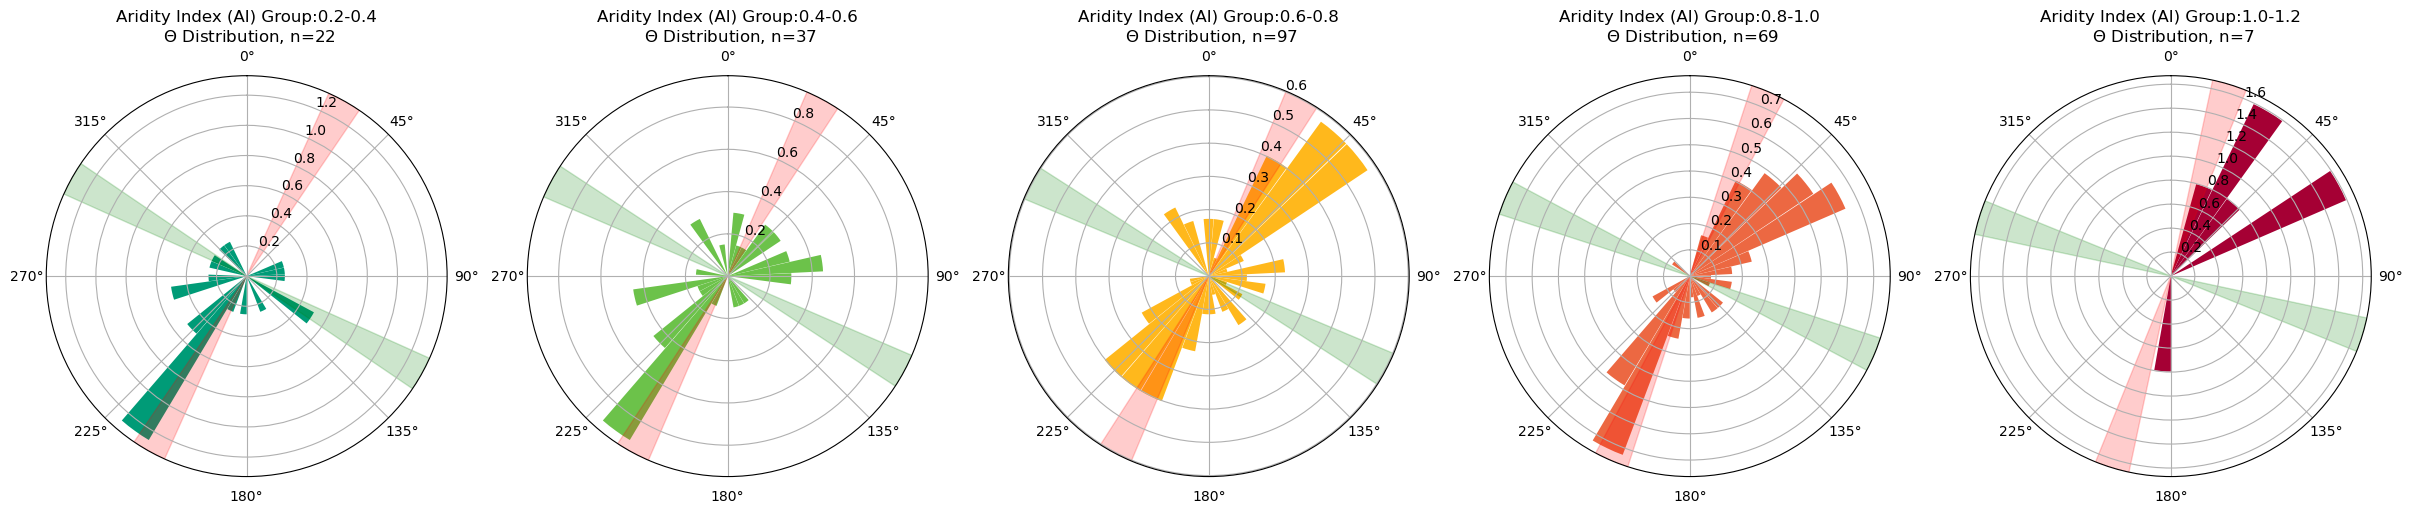

In [380]:
fig, ax = plt.subplots(1, 5, figsize=(30, 7.5))
n=0

index = np.arange(1,6)

for i, (group, df) in enumerate(grouped):
    if n <=5:
    
        y= df['d_EI']
        x=df['d_AI']

        mu_x = np.mean(x)
        mu_y = np.mean(y)

        # Get the angle and magnitude of each data point
        angles = np.arctan2(y,x)
        magnitudes = np.sqrt(x**2 + y**2)

        # Create bins for the angles
        bins = np.linspace(-np.pi, np.pi, num=36)

        # Create a histogram of the angles
        hist, _ = np.histogram(angles, bins=bins, density=True)
        
        
        # Plot the rose diagram
        ax = plt.subplot(1,5, index[n], projection='polar')
        ax.bar(bins[:-1], hist, width=2*np.pi/36, align='edge', bottom=0, color=colors5[n])

        ax.axvspan(w_slope_rad[n] + (2*np.pi/72), w_slope_rad[n] - (2*np.pi/72), alpha=0.2, color='red')
            
        ax.axvspan(w_slope_rad[n] + np.pi/2 + (2*np.pi/72), w_slope_rad[n]+ np.pi/2 - (2*np.pi/72), alpha=0.2, color='green')
        
        ax.axvspan(w_slope_rad[n] - np.pi/2 + (2*np.pi/72), w_slope_rad[n]- np.pi/2 - (2*np.pi/72), alpha=0.2, color='green')

        ax.axvspan(w_slope_rad[n]-np.pi + (2*np.pi/72), w_slope_rad[n]-np.pi - (2*np.pi/72), alpha=0.2, color='red')
        
        #ax.set_ylim(0,1.1)
        ax.set_theta_zero_location("N")
        ax.set_theta_direction(-1)
        #ax.suptitle(f'AI group: {group}')
        ax.set_title(f"Aridity Index (AI) Group:{group}\n $\Theta$ Distribution, n={len(df)}")
        n+=1
    else:
        break

IndexError: index 5 is out of bounds for axis 0 with size 5

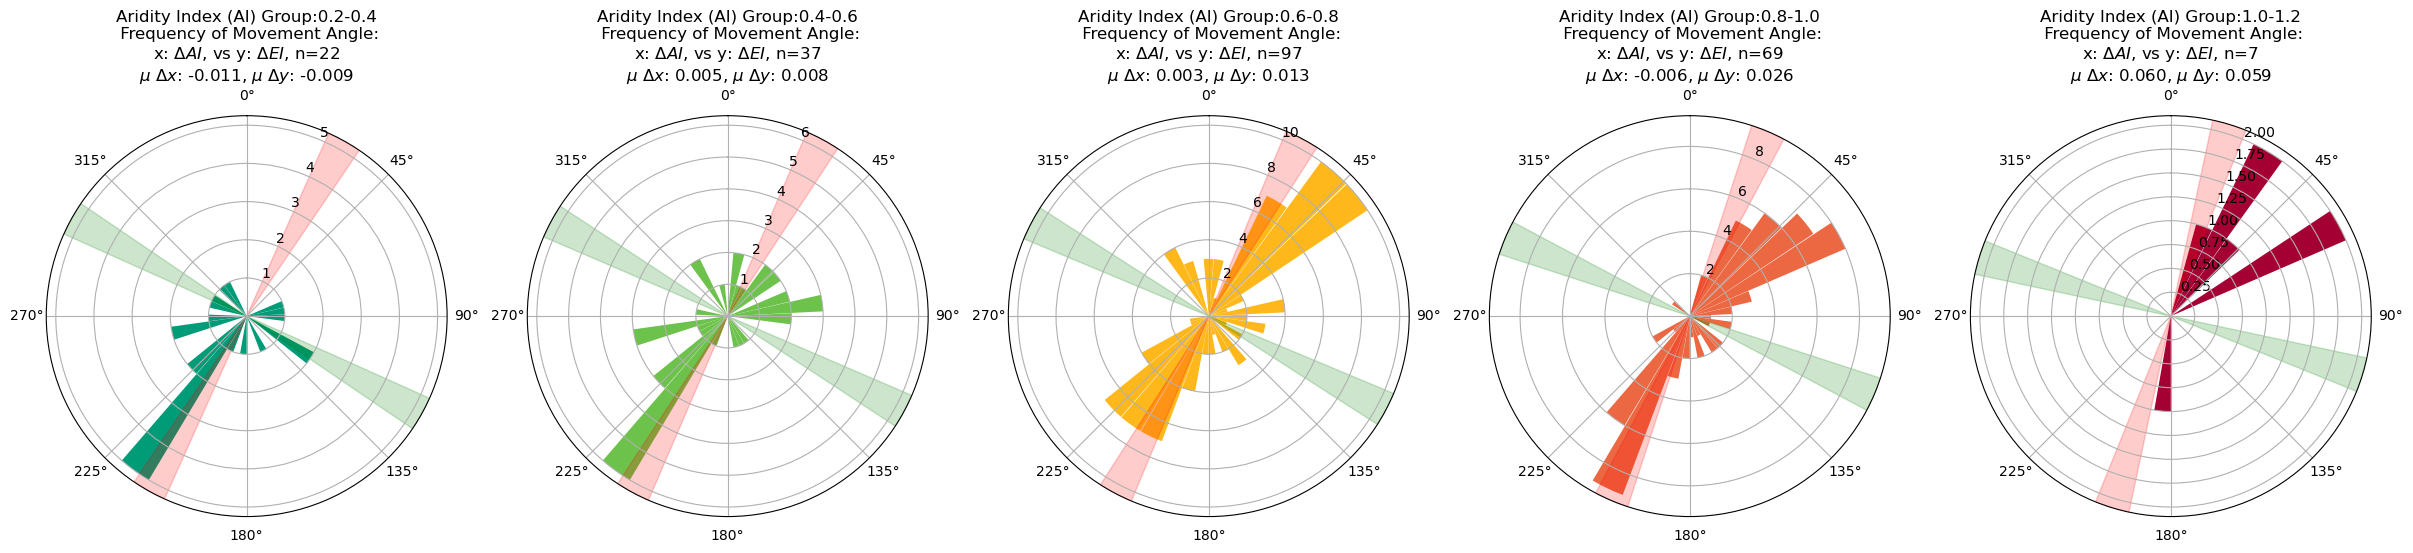

In [381]:
fig, ax = plt.subplots(2, 5, figsize=(30, 7.5), sharey=True)
n = 0
index = np.arange(1, 6)

for i, (group, df) in enumerate(grouped):
    if n <= 5:
        y = df['d_EI']
        x = df['d_AI']

        mu_x = np.mean(x)
        mu_y = np.mean(y)

        # Get the angle and magnitude of each data point
        angles = np.arctan2(y, x)
        magnitudes = np.sqrt(x**2 + y**2)

        # Create bins for the angles
        bins = np.linspace(-np.pi, np.pi, num=36)

        # Create a histogram of the angles
        hist, _ = np.histogram(angles, bins=bins)
        
        ax = plt.subplot(1,5, index[n], projection='polar')
        
        ax.bar(bins[:-1], hist, width=2*np.pi/36, align='edge', bottom=0, color=colors5[n])

        ax.axvspan(w_slope_rad[n] + (2*np.pi/72), w_slope_rad[n] - (2*np.pi/72), alpha=0.2, color='red')
            
        ax.axvspan(w_slope_rad[n] + np.pi/2 + (2*np.pi/72), w_slope_rad[n]+ np.pi/2 - (2*np.pi/72), alpha=0.2, color='green')
        
        ax.axvspan(w_slope_rad[n] - np.pi/2 + (2*np.pi/72), w_slope_rad[n]- np.pi/2 - (2*np.pi/72), alpha=0.2, color='green')

        ax.axvspan(w_slope_rad[n]-np.pi + (2*np.pi/72), w_slope_rad[n]-np.pi - (2*np.pi/72), alpha=0.2, color='red')

        #ax.set_ylim(0, 1.7)
        ax.set_theta_zero_location("N")
        ax.set_theta_direction(-1)
        ax.set_title(f"Aridity Index (AI) Group:{group}\n Frequency of Movement Angle:\nx: $\Delta AI$, vs y: $\Delta EI$, n={len(df)}\n$\mu$ $\Delta x$: {mu_x:.3f}, $\mu$ $\Delta y$: {mu_y:.3f}")

        n += 1
    else:
        break

What can we say about SR vs Tendencies in EI per AI

[0.25320105 0.         0.25320105 1.26600523 0.50640209 0.
 0.         0.50640209 0.25320105 0.         0.25320105 0.25320105
 0.         0.25320105 0.25320105 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.25320105 0.25320105 0.25320105 0.         0.         0.50640209
 0.         0.         0.25320105 0.         0.        ]
[0.         0.         0.15055197 0.90331184 0.45165592 0.15055197
 0.15055197 0.45165592 0.         0.15055197 0.         0.
 0.         0.         0.30110395 0.         0.15055197 0.
 0.30110395 0.15055197 0.15055197 0.30110395 0.30110395 0.
 0.30110395 0.45165592 0.30110395 0.         0.         0.
 0.         0.15055197 0.15055197 0.15055197 0.        ]
[0.11485408 0.22970817 0.40198929 0.40198929 0.40198929 0.22970817
 0.05742704 0.05742704 0.         0.         0.         0.
 0.         0.         0.22970817 0.17228112 0.         0.17228112
 0.17228112 0.05742704 0.40198929 0.57427041 0.57427041 0.11485408
 0.05742704 

IndexError: index 5 is out of bounds for axis 0 with size 5

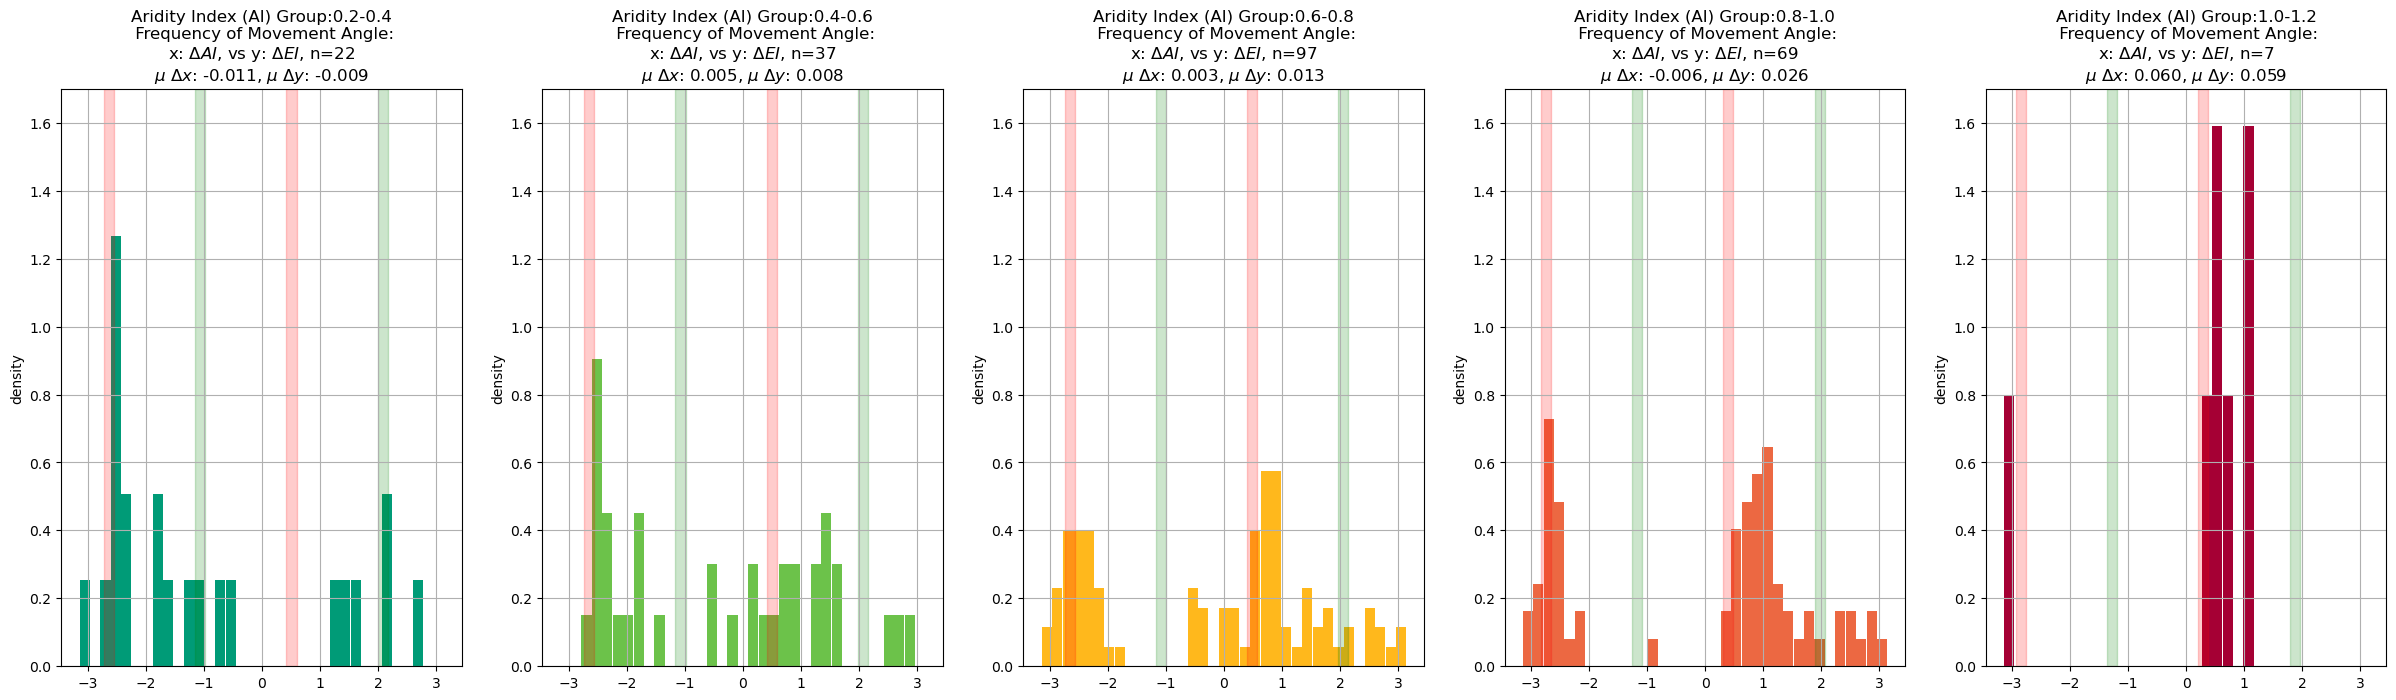

In [382]:
fig, ax = plt.subplots(2, 5, figsize=(30, 7.5), sharey=True)
n = 0
index = np.arange(1, 6)

for i, (group, df) in enumerate(grouped):
    if n <= 5:
        y = df['d_EI']
        x = df['d_AI']

        mu_x = np.mean(x)
        mu_y = np.mean(y)

        # Get the angle and magnitude of each data point
        angles = np.arctan2(y, x)
        magnitudes = np.sqrt(x**2 + y**2)

        # Create bins for the angles
        bins = np.linspace(-np.pi, np.pi, num=36)

        # Create a histogram of the angles
        hist, _ = np.histogram(angles, bins=bins, density=True)
        
        print(hist)
        
        ax = plt.subplot(1,5, index[n])
#         ax.bar(bins[:-1], hist, width=2*np.pi/36, align='edge', bottom=0, color=colors5[n])

#         ax.axvspan(w_slope_rad[n] + (2*np.pi/72), w_slope_rad[n] - (2*np.pi/72), alpha=0.5, color='red')
        

        
        ax.bar(bins[:-1], hist, width=2*np.pi/36, align='edge', bottom=0, color=colors5[n])

        ax.axvspan(w_slope_rad[n] + (2*np.pi/72), w_slope_rad[n] - (2*np.pi/72), alpha=0.2, color='red')
            
        ax.axvspan(w_slope_rad[n] + np.pi/2 + (2*np.pi/72), w_slope_rad[n]+ np.pi/2 - (2*np.pi/72), alpha=0.2, color='green')
        
        ax.axvspan(w_slope_rad[n] - np.pi/2 + (2*np.pi/72), w_slope_rad[n]- np.pi/2 - (2*np.pi/72), alpha=0.2, color='green')

        ax.axvspan(w_slope_rad[n]-np.pi + (2*np.pi/72), w_slope_rad[n]-np.pi - (2*np.pi/72), alpha=0.2, color='red')
        
        ax.set_ylim(0, 1.7)
        
        # ax.set_xlim(0)
        
        ax.set_ylabel('density')
        
        ax.set_title(f"Aridity Index (AI) Group:{group}\n Frequency of Movement Angle:\nx: $\Delta AI$, vs y: $\Delta EI$, n={len(df)}\n$\mu$ $\Delta x$: {mu_x:.3f}, $\mu$ $\Delta y$: {mu_y:.3f}")
        
        ax.grid()
        n += 1
    else:
        break


IndexError: index 5 is out of bounds for axis 0 with size 5

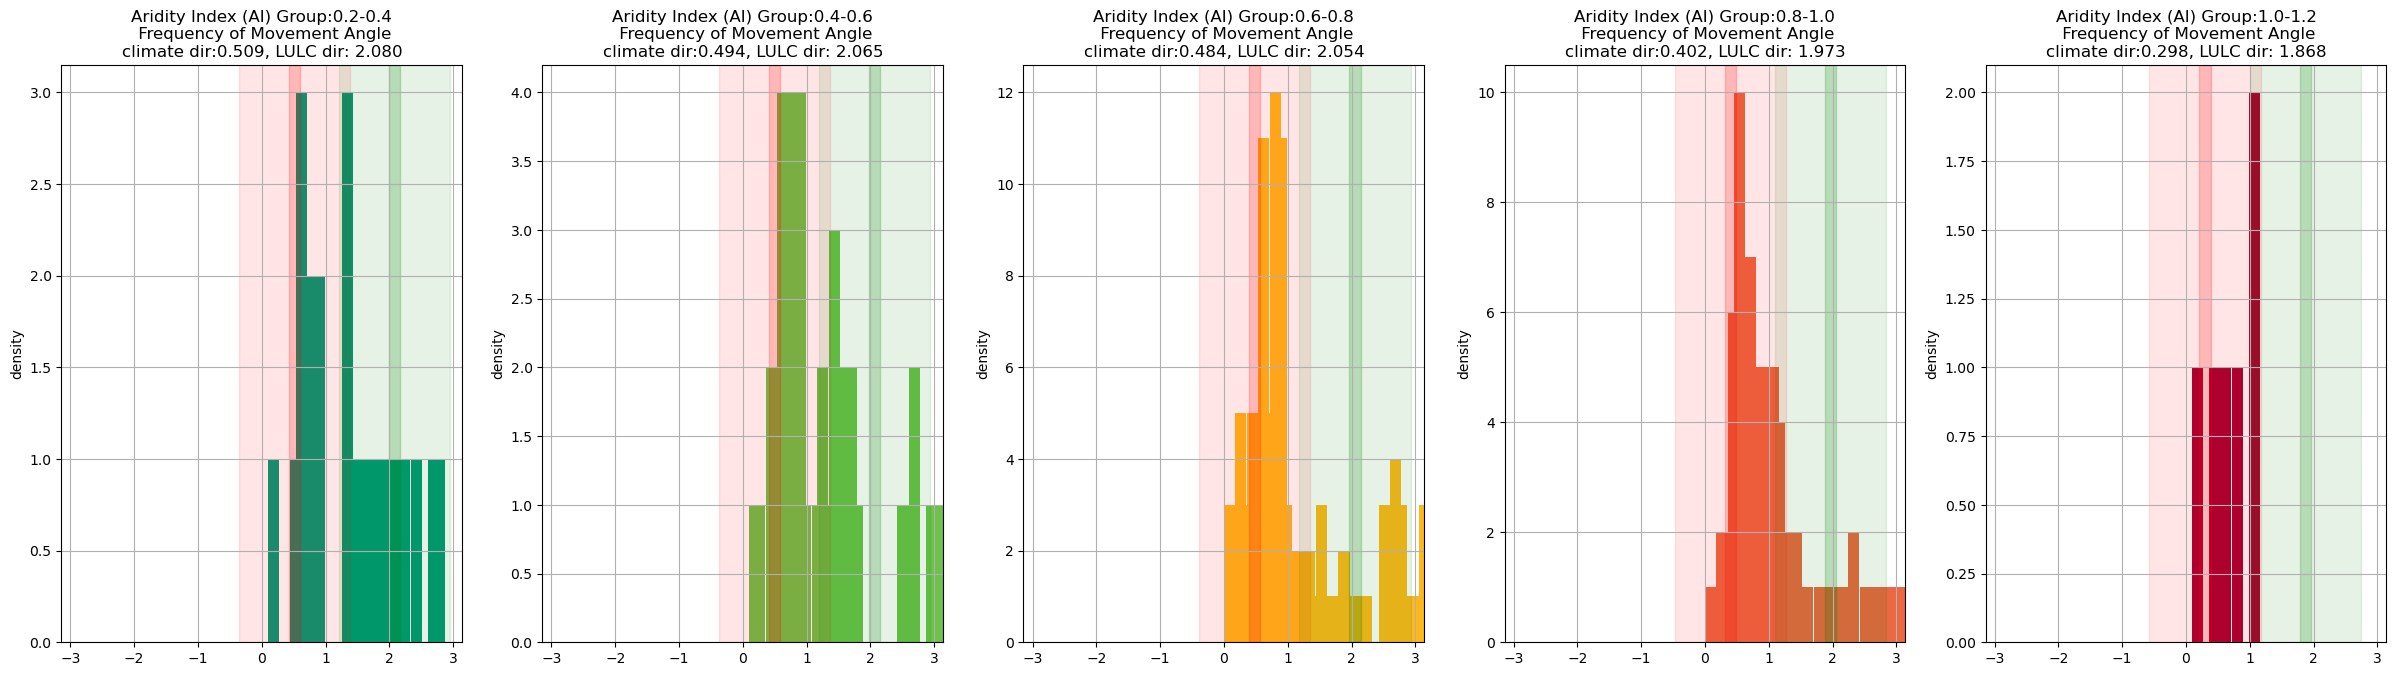

In [383]:
def positive_dir(angle):
    if angle < 0:
        return angle + np.pi
    else:
        return angle

fig, ax = plt.subplots(2, 5, figsize=(30, 7.5), sharey=True)
n = 0
index = np.arange(1, 6)

for i, (group, df) in enumerate(grouped):
    if n <= 5:
        y = df.loc[:, 'd_EI']
        x = df['d_AI']

        mu_x = np.mean(x)
        mu_y = np.mean(y)

        # Get the angle and magnitude of each data point
        angles = np.arctan2(y, x)
        magnitudes = np.sqrt(x**2 + y**2)
        
        #distribution of positive angles so that green and red (land and climate) directions are only two
        abs_angles = [positive_dir(angle) for angle in angles]

        # Create bins for the angles
        bins = np.linspace(0, np.pi, num=36)

        # Create a histogram of the angles
        hist, _ = np.histogram(abs_angles, bins=bins)
        
        ax = plt.subplot(1,5, index[n])
        
        ax.bar(bins[:-1], hist, width=2*np.pi/36, align='edge', bottom=0, color=colors5[n])

#         ax.axvspan(w_slope_rad[n] + (2*np.pi/72), w_slope_rad[n] - (2*np.pi/72), alpha=0.5, color='red')
        

        
        ax.bar(bins[:-1], hist, width=2*np.pi/36, align='edge', bottom=0, color=colors5[n])

        ax.axvspan(w_slope_rad[n] + (2*np.pi/72), w_slope_rad[n] - (2*np.pi/72), alpha=0.2, color='red', label = 'climatic shift')
            
        ax.axvspan(w_slope_rad[n] + np.pi/2 + (2*np.pi/72), w_slope_rad[n]+ np.pi/2 - (2*np.pi/72), alpha=0.2, color='green', label='land change shift')
        
        ax.axvspan(w_slope_rad[n] + (20*np.pi/72), w_slope_rad[n] - (20*np.pi/72), alpha=0.1, color='red')
            
        ax.axvspan(w_slope_rad[n] + np.pi/2 + (20*np.pi/72), w_slope_rad[n]+ np.pi/2 - (20*np.pi/72), alpha=0.1, color='green')
        
        #ax.axvspan(w_slope_rad[n] - np.pi/2 + (2*np.pi/72), w_slope_rad[n]- np.pi/2 - (2*np.pi/72), alpha=0.2, color='green')

        #ax.axvspan(w_slope_rad[n]-np.pi + (2*np.pi/72), w_slope_rad[n]-np.pi - (2*np.pi/72), alpha=0.2, color='red')
        
        #ax.set_ylim(0, 3.5)
        
        ax.set_xlim(-np.pi, np.pi)
        
        ax.set_ylabel('density')
        
        ax.set_title(f"Aridity Index (AI) Group:{group}\n Frequency of Movement Angle\nclimate dir:{w_slope_rad[n]:.3f}, LULC dir: {w_slope_rad[n]+np.pi/2:.3f}")
        
        ax.grid() 
        
        n += 1
    else:
        break
plt.legend()

### if we calculate percentage contribution

we might be able to do that by distance:
record the catchment, 
record the decade ending, 
record whether the movement was positive or negative


percentage contribution will be a normalised difference from the climate angle (by pi/2) 

In [384]:
print(np.pi/4)

0.7853981633974483


No angles are plotting out of range: True
Median climatic contribution fraction, group 0.2-0.4 = 0.49
No angles are plotting out of range: True
Median climatic contribution fraction, group 0.4-0.6 = 0.69
No angles are plotting out of range: True
Median climatic contribution fraction, group 0.6-0.8 = 0.77
No angles are plotting out of range: True
Median climatic contribution fraction, group 0.8-1.0 = 0.72
No angles are plotting out of range: True
Median climatic contribution fraction, group 1.0-1.2 = 0.84


IndexError: list index out of range

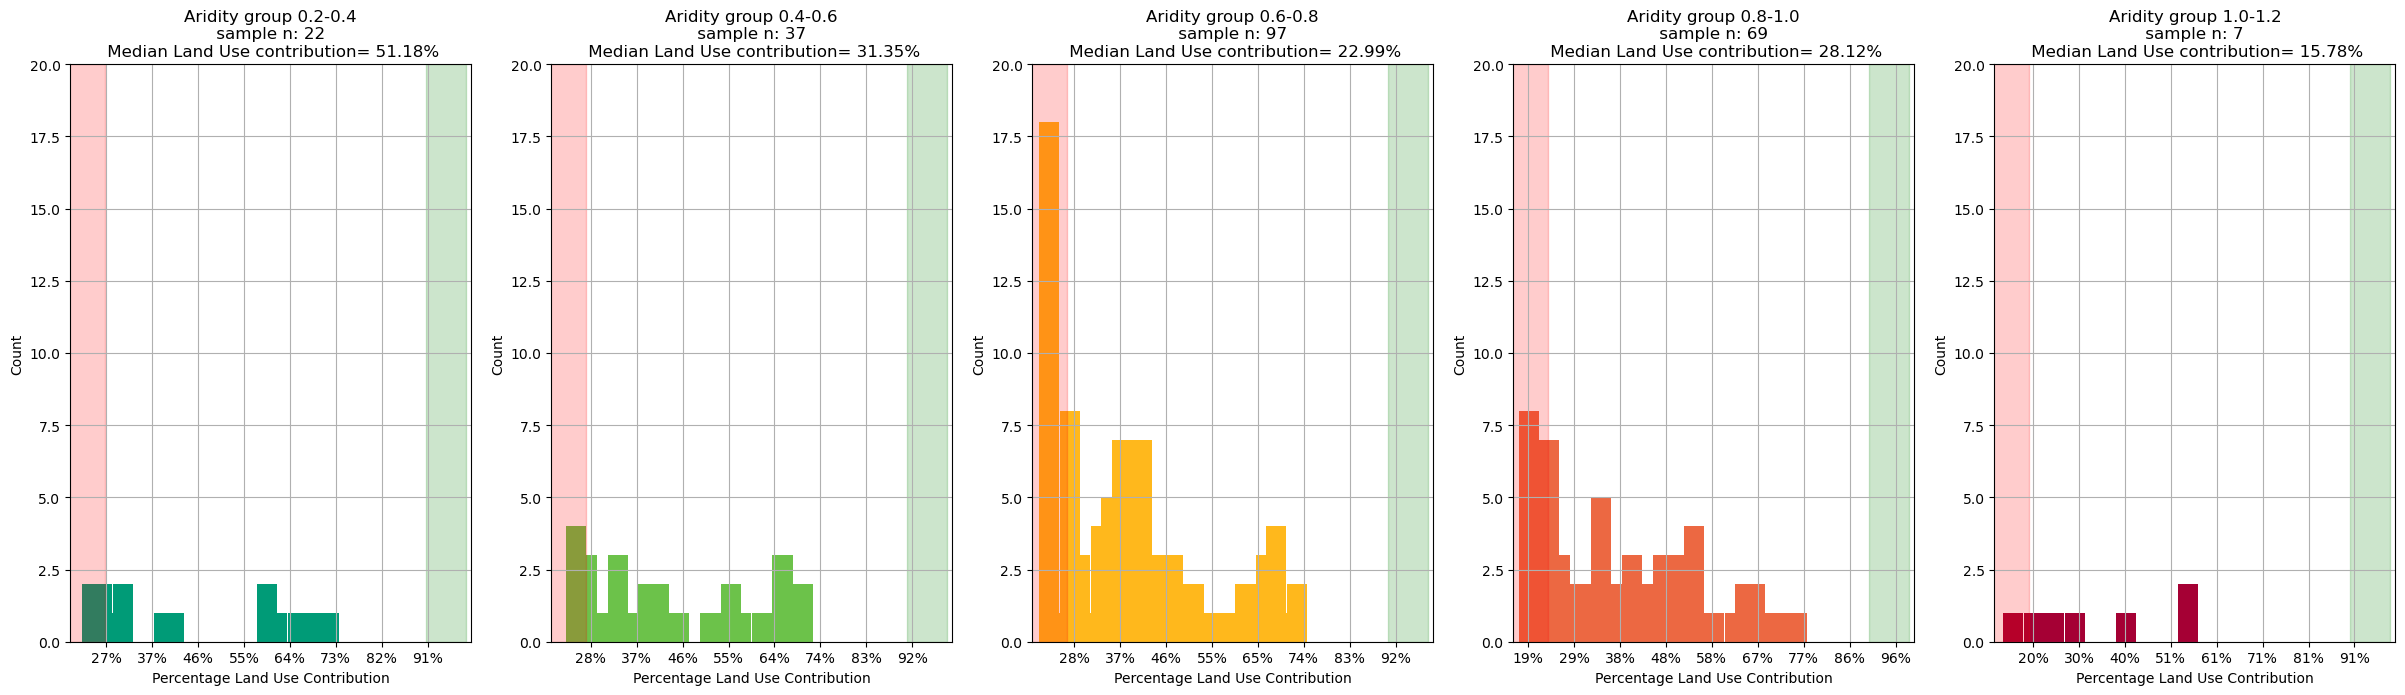

In [412]:
import matplotlib.ticker as mtick

n = 0
index = np.arange(1, 6)

dfs = []

fig, ax = plt.subplots(2, 5, figsize=(30, 7.5), sharey=True)


# def narrow_range(angle, clim_angle, lulc_angle):
#     if angle < clim_angle:
#         return angle +np.pi/4
#     elif angle > lulc_angle:
#         return angle - np.pi/4
#     else:
#         return angle
def narrow_range(angle, clim_angle, lulc_angle):  # narrow range, where we want to know what 
    if angle < clim_angle:
        return angle + (clim_angle - angle)
    elif angle > lulc_angle:
        return lulc_angle - (angle - lulc_angle)
    else:
        return angle
    
def check(angle, clim_angle, lulc_angle):
    return angle >= clim_angle and angle <= lulc_angle


for i, (group, df) in enumerate(grouped):

    y = df['d_EI']
    x = df['d_AI']

    catch = df['catchment_name']
    dec = df['decade_ending']

    mu_x = np.mean(x)
    mu_y = np.mean(y)

    # Get the angle and magnitude of each data point
    angles = np.arctan2(y, x)
    magnitudes = np.sqrt(x**2 + y**2)

    clim_angle = w_slope_rad[n] 
    lulc_angle = w_slope_rad[n] + np.pi/2

    abs_angles = [positive_dir(angle) for angle in angles]
    narrow_angles = [narrow_range(angle, clim_angle, lulc_angle) for angle in abs_angles]

    checking = [check(angle, clim_angle, lulc_angle) for angle in narrow_angles]
    
    lulc_pct = (narrow_angles - clim_angle)/(lulc_angle - clim_angle) #absolute angle difference equivalent to 45 degrees is equal contribution
    clim_pct = (lulc_angle - narrow_angles)/(lulc_angle - clim_angle) #absolute angle difference equivalent to 45 degrees is equal contribution
    
    df['clim_pct_con'] = clim_pct
    df['lulc_pct_con'] = lulc_pct
    
    # Create bins for the angles
    bins = np.linspace(0, np.pi/2, num=36)
    
    hist, _ = np.histogram(narrow_angles, bins=bins)
        
    ax = plt.subplot(1,5, index[n])

    ax.bar(bins[:-1], hist, width=2*np.pi/36/2, align='edge', bottom=0, color=colors5[n])
    
    ax.axvspan(w_slope_rad[n] + (2*np.pi/72), w_slope_rad[n] - (2*np.pi/72), alpha=0.2, color='red', label = 'climatic shift')
            
    ax.axvspan(w_slope_rad[n] + np.pi/2 + (2*np.pi/72), w_slope_rad[n]+ np.pi/2 - (2*np.pi/72), alpha=0.2, color='green', label='land change shift')
    
    ax.set_ylim(0, 20)
    
    ax.set_xlim(w_slope_rad[n] - (2*np.pi/72) * 0.75, w_slope_rad[n] + np.pi/2 + (2*np.pi/72) *1.25)
    
    ax.set_title(f'Aridity group {group}\n sample n: {len(df)} \n Median Land Use contribution= {np.median(lulc_pct)*100:.2f}%')
    
    ax.grid()
    
    dfs.append(df)
    
    ax.set_ylabel('Count')
    
    ax.set_xlabel('Percentage Land Use Contribution')
    
    ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax= w_slope_rad[n] + np.pi/2 + (2*np.pi/72) *1.25))
    
    #ax.set_xticks(np.linspace(w_slope_rad[n] - (2*np.pi/72) * 0.75, w_slope_rad[n] + np.pi/2 + (2*np.pi/72) *1.25, 1))
    
    #ax.set_xticklabels(np.linspace(0, 100, 20)[:-1])# + np.pi/2)
    
    
    #display(df.corr().loc[:, 'clim_pct_con'].sort_values())
    
    print('No angles are plotting out of range:', np.any(checking is not False))
    print(f'Median climatic contribution fraction, group {group} = {np.median(clim_pct):.2f}')
    
    n+=1

In [403]:
table=pd.concat(dfs)
table.describe()

d_BRIGHTNESS     d_omega        d_AI     d_gndvi       d_nbr  \
count    232.000000  232.000000  232.000000  232.000000  232.000000   
mean    -170.769033    0.247487    0.000809    0.030030    0.008968   
std      268.624554    0.799346    0.061485    0.026080    0.029732   
min    -1475.758422   -3.077244   -0.155145   -0.088744   -0.122972   
25%     -246.190668   -0.103864   -0.038013    0.013554   -0.006893   
50%     -119.157870    0.157079   -0.002745    0.027571    0.007746   
75%      -41.839230    0.672901    0.049095    0.043065    0.022353   
max      943.736876    3.023078    0.167379    0.105514    0.110550   

             d_B3        d_B4        d_B7         d_B1        d_B2  ...  \
count  232.000000  232.000000  232.000000   232.000000  232.000000  ...   
mean  -101.556427  -35.096041  -47.065295  -119.322272  -99.412507  ...   
std    152.411892  137.008508   93.223438   215.484401  129.415467  ...   
min   -837.738090 -450.402942 -399.720491 -1187.159932 -661.281180  ...   
25%   -142.748808 -138.372884  -86.351701  -144.618508 -130.492073  ...   
50%    -79.291631  -19.972345  -35.374393   -79.400835  -81.055962  ...   
75%    -29.518065   62.358189    7.224722   -26.684337  -35.762809  ...   
max    682.946862  300.619168  223.977545   775.300836  494.813297  ...   

            LT_AI       LT_EI      d_ndmi        d_EI  Unnamed: 0   d_WETNESS  \
count  232.000000  232.000000  232.000000  232.000000  232.000000  232.000000   
mean     0.698357    0.571912    0.005377    0.015009   47.969828    6.951045   
std      0.191641    0.165646    0.024527    0.056825   32.332471   87.079637   
min      0.212182    0.125027   -0.116115   -0.171110    0.000000 -269.509851   
25%      0.598275    0.490526   -0.006951   -0.025577   19.000000  -47.845502   
50%      0.751636    0.613916    0.004901    0.009556   45.000000    2.727537   
75%      0.824124    0.689327    0.018851    0.059855   75.000000   46.390588   
max      1.146249    0.857161    0.078509    0.175202  116.000000  316.244007   

         d_is_dur         d_T  clim_pct_con  lulc_pct_con  
count  232.000000  232.000000    232.000000    232.000000  
mean     0.051890    0.148287      0.678985      0.321015  
std      0.311339    0.172798      0.277810      0.277810  
min     -0.578495   -0.346616      0.014662      0.000000  
25%     -0.185671    0.031292      0.445619      0.062792  
50%     -0.020054    0.218748      0.747874      0.252126  
75%      0.293400    0.263921      0.937208      0.554381  
max      1.166623    0.904567      1.000000      0.985338  

[8 rows x 29 columns]

In [404]:
table.corr().loc['clim_pct_con'].sort_values(ascending=False)[:5]

clim_pct_con    1.000000
d_T             0.218991
LT_EI           0.170581
d_ndbi          0.154324
LT_AI           0.149019
Name: clim_pct_con, dtype: float64

In [405]:
table.corr().loc['lulc_pct_con'].sort_values(ascending=False)[:5]

lulc_pct_con    1.000000
d_EI            0.249479
d_WETNESS       0.161261
d_ndmi          0.154324
d_omega         0.150216
Name: lulc_pct_con, dtype: float64

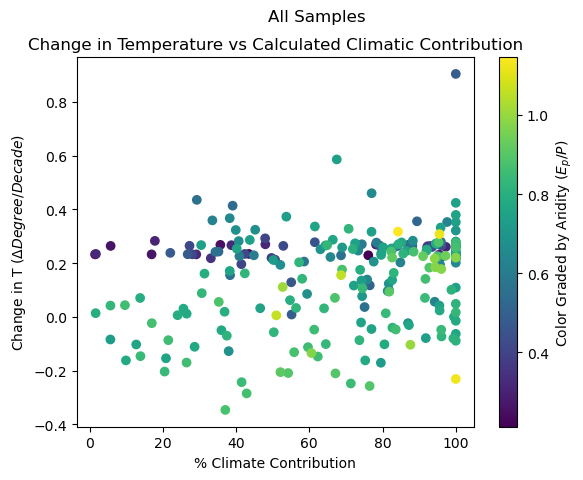

In [406]:
y = table.d_T
x = table.clim_pct_con *100
plt.scatter(x, y, c=table.LT_AI)
plt.suptitle(f'All Samples')
plt.ylabel('Change in T ($\Delta Degree/ Decade$)')
plt.xlabel('% Climate Contribution')
plt.title('Change in Temperature vs Calculated Climatic Contribution')
plt.colorbar(label= 'Color Graded by Aridity ($E_p/P$)')

In [ ]:
y = table.d_WETNESS
x = table.lulc_pct_con *100
plt.scatter(x, y, c=table.LT_AI)
plt.suptitle(f'All Samples')
plt.ylabel('Change in Tasselecd Cap Wetness ($\Delta [-]/ Decade$)')
plt.xlabel('% LULC Contribution')
plt.title('Change in Tasseled Cap Wetness vs Calculated LULC Contribution')
plt.colorbar(label= 'Color Graded by Aridity ($E_p/P$)')

In [ ]:
names = table[table.lulc_pct_con > 0.5].catchment_name
names

In [ ]:
for i, (group, df) in enumerate(table.groupby('AI_group_narrow')):
    if i == 5:
        break
    plt.figure()
    df_subset = df
    y = df_subset.d_T
    x = df_subset.clim_pct_con
    plt.scatter(x, y, c=df_subset.LT_AI)
    plt.suptitle(f'Aridity Group: {group}')
    plt.ylabel('Change in T ($\Delta Degree/ Decade$)')
    plt.xlabel('% Climate Contribution')
    plt.title('Change in Temperature vs Calculated Climatic Contribution')
    plt.colorbar(label= 'Color Graded by Aridity ($E_p/P$)')
    display(df_subset.corr().loc['clim_pct_con'].sort_values(ascending=False)[:5])

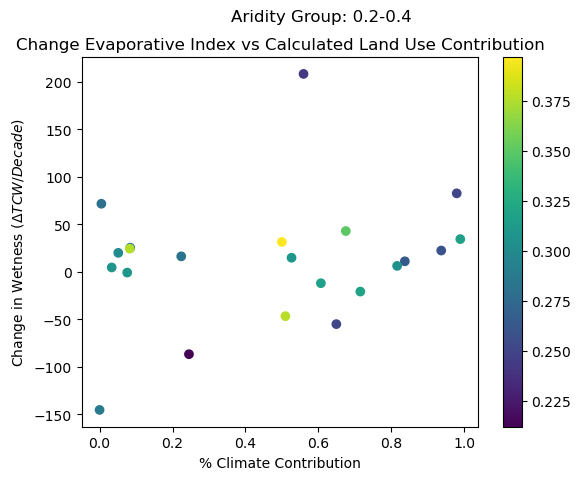

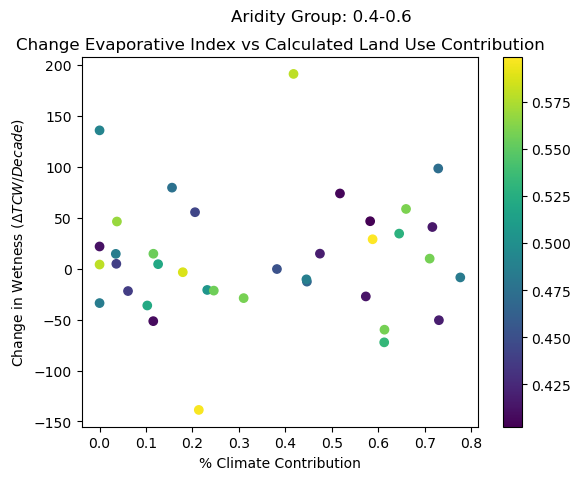

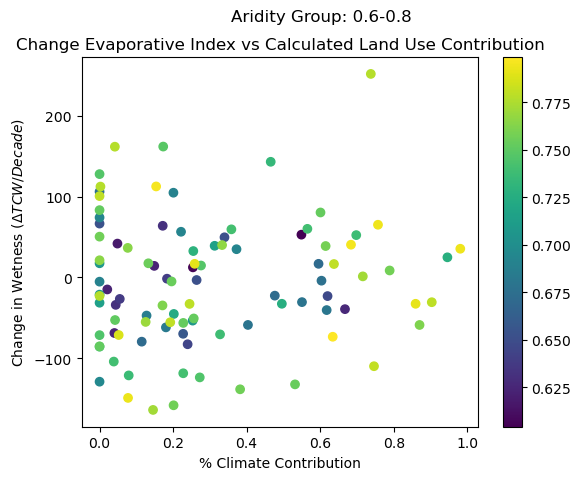

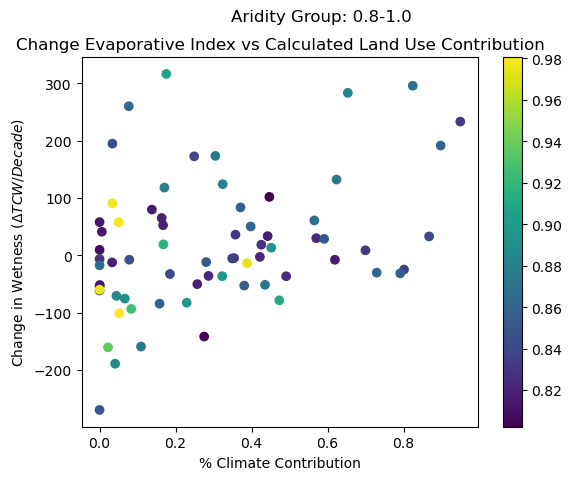

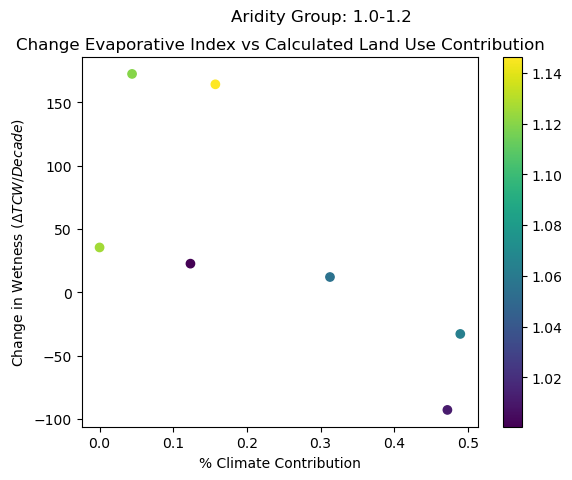

In [121]:
for i, (group, df) in enumerate(table.groupby('AI_group_narrow')):
    if i == 5:
        break
    plt.figure()
    y = df.d_WETNESS
    x = df.lulc_pct_con
    plt.scatter(x, y, c=df.LT_AI)
    plt.suptitle(f'Aridity Group: {group}')
    plt.ylabel('Change in Wetness ($\Delta TCW/ Decade$)')
    plt.xlabel('% Climate Contribution')
    plt.title('Change Evaporative Index vs Calculated Land Use Contribution')
    plt.colorbar()

[0.         0.11111111 0.22222222 0.33333333 0.44444444 0.55555556
 0.66666667 0.77777778 0.88888889 1.        ]


(-0.01, 1.0)

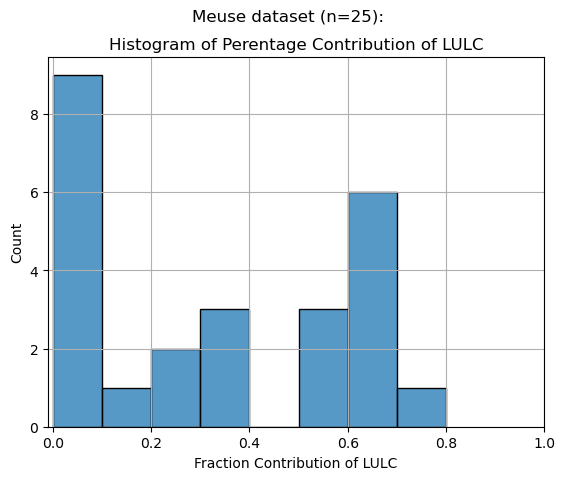

In [362]:
x=[]
bins = np.linspace(0, 1, num=10)
print(bins)


for i, (group, df) in enumerate(table.groupby('country_code')):
    if group=='FR' or group == 'BE':
        x.append(df)
        # df.lulc_pct_con.plot(kind='hist', label=group)
y = pd.concat(x)
n = len(y)
sns.histplot(y.lulc_pct_con, binwidth=0.1)
plt.suptitle(f'Meuse dataset (n={n}):')
plt.title('Histogram of Perentage Contribution of LULC')
plt.xlabel('Fraction Contribution of LULC')

y.describe()
plt.grid()
plt.xlim(-0.01, 1)

In [234]:
dfs = []
for i, (group, df) in enumerate(y.groupby('catchment_name')):
    if len(df)>1:
        z = (df.catchment_name.values[0],df.lulc_pct_con.max())
    else:
        z=(df.catchment_name.values[0],df.lulc_pct_con.values[0])
    dfs.append(z)
dfs2 = pd.DataFrame(dfs)
dfs2.to_csv('mean_contributions.csv')
dfs2

0             1
0                                      Amay   6.036040e-01
1                                     Chooz   5.505574e-01
2                                   Hastiere  3.533950e-17
3                                 Huccorgne   0.000000e+00
4                                   Jemelle   6.675116e-01
5                          La Bar Cheveuges   4.035940e-02
6                          La Meuse Goncourt  0.000000e+00
7                     La Meuse Saint-Mihiel   3.823018e-01
8                           La Meuse Stenay   3.585592e-01
9                  La Vence la Francheville   7.106629e-01
10               Le Loison Han-lÃ©s-Juvigny   5.956148e-01
11  Le Mouzon Circourt-sur-Mouzon [Villars]   6.981654e-01
12      Le Vair Soulosse-sous-Saint-Ã‰lophe   5.652504e-01
13                              Membre Pont   6.127780e-01
14                                 Treignes   6.201213e-01
15                                  Warnant   2.759530e-01
16                                 Wiheries   3.277275e-01

[0.         0.11111111 0.22222222 0.33333333 0.44444444 0.55555556
 0.66666667 0.77777778 0.88888889 1.        ]


d_BRIGHTNESS    d_omega       d_AI    d_gndvi      d_nbr        d_B3  \
count     93.000000  93.000000  93.000000  93.000000  93.000000   93.000000   
mean    -110.601286  -0.031659  -0.041836   0.021497   0.002702  -60.713616   
std      235.484393   0.512437   0.043299   0.022258   0.028898  143.927647   
min     -685.056320  -1.848513  -0.155145  -0.088744  -0.122972 -494.254035   
25%     -216.482158  -0.222430  -0.068352   0.010621  -0.012589 -127.355985   
50%     -126.337042  -0.046976  -0.034094   0.027017   0.008487  -80.559118   
75%      -47.948257   0.146085  -0.005665   0.035069   0.020990  -28.408803   
max      943.736876   2.501387   0.040132   0.059448   0.079509  682.946862   

             d_B4        d_B7        d_B1        d_B2  ...      LT_AI  \
count   93.000000   93.000000   93.000000   93.000000  ...  93.000000   
mean   -43.014297  -22.485867  -53.045593  -59.487124  ...   0.574775   
std    146.467837   73.195109  165.435183  116.214161  ...   0.211416   
min   -417.159798 -178.534205 -428.933576 -268.714357  ...   0.212182   
25%   -145.594708  -65.628107 -123.145778 -111.944129  ...   0.405524   
50%    -31.965356  -36.443811  -73.637370  -80.492937  ...   0.579229   
75%     60.393869    6.991907  -14.808574  -33.730983  ...   0.755438   
max    298.319198  223.977545  775.300836  494.813297  ...   0.980588   

           LT_EI     d_ndmi       d_EI  Unnamed: 0   d_WETNESS   d_is_dur  \
count  93.000000  93.000000  93.000000   93.000000   93.000000  93.000000   
mean    0.466601   0.001590  -0.027719   46.505376   -0.335074  -0.182102   
std     0.192826   0.026890   0.037684   27.565978   83.755031   0.140358   
min     0.125027  -0.116115  -0.171110    0.000000 -269.509851  -0.578495   
25%     0.290875  -0.008943  -0.052134   23.000000  -31.211200  -0.261275   
50%     0.475321   0.007315  -0.019636   46.000000   14.546440  -0.168099   
75%     0.627375   0.019557  -0.005205   70.000000   46.316848  -0.069979   
max     0.788253   0.069261   0.047630   94.000000  208.513186   0.117880   

             d_T  clim_pct_con  lulc_pct_con  
count  93.000000     93.000000     93.000000  
mean    0.245765      0.721732      0.278268  
std     0.023144      0.278266      0.278266  
min     0.193503      0.010965      0.000000  
25%     0.228919      0.490495      0.044376  
50%     0.245724      0.828229      0.171771  
75%     0.265725      0.955624      0.509505  
max     0.292321      1.000000      0.989035  

[8 rows x 29 columns]

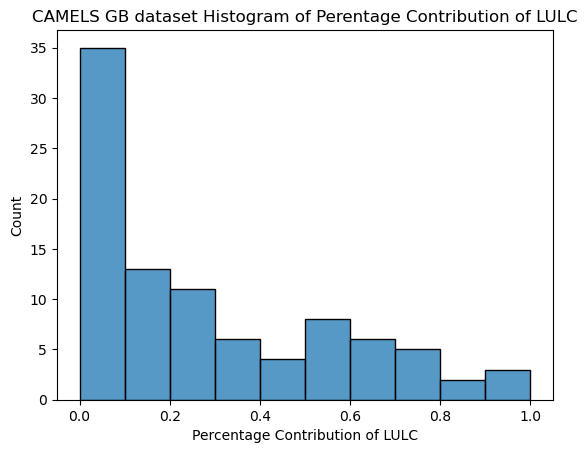

In [168]:
x=[]
bins = np.linspace(0, 1, num=10)
print(bins)

for i, (group, df) in enumerate(table.groupby('country_code')):
    if group=='GB':
        x.append(df)
        # df.lulc_pct_con.plot(kind='hist', label=group)
y = pd.concat(x)

sns.histplot(y.lulc_pct_con, binwidth=0.1)
plt.title('CAMELS GB dataset Histogram of Perentage Contribution of LULC')
plt.xlabel('Percentage Contribution of LULC')
y.describe()

In [335]:
y[y['lulc_pct_con'] >0.5]

d_BRIGHTNESS                            catchment_name  \
system_index                                                                   
00000000000000000019      7.290045                              Membre Pont    
00000000000000000013     70.692639                                  Jemelle    
00000000000000000015   -143.427344                                 Treignes    
00000000000000000014    -21.036251                                     Amay    
00000000000000000020    -35.112012                                    Chooz    
0000000000000000001c    -16.968891                 La Vence la Francheville    
0000000000000000001c   -111.963434                 La Vence la Francheville    
00000000000000000026    -40.170761               Le Loison Han-lÃ©s-Juvigny    
0000000000000000002a     30.218358  Le Mouzon Circourt-sur-Mouzon [Villars]    
00000000000000000029     14.475972      Le Vair Soulosse-sous-Saint-Ã‰lophe    

                       d_omega      d_AI   d_gndvi     d_nbr       d_B3  \
system_index                                                              
00000000000000000019 -3.077244  0.063636  0.011025 -0.016131 -25.832310   
00000000000000000013 -2.411332  0.077097  0.008731 -0.007520  -5.752010   
00000000000000000015 -0.815998  0.035799  0.028952 -0.000400 -88.622353   
00000000000000000014 -2.034204  0.063127  0.006334 -0.003324 -20.871905   
00000000000000000020 -0.659802  0.058738  0.010674 -0.008974 -26.538751   
0000000000000000001c -0.855523  0.039790  0.004589 -0.000564 -21.840459   
0000000000000000001c  1.186772  0.010515  0.019455 -0.009462 -52.846803   
00000000000000000026 -2.041064  0.073676  0.004480 -0.000515 -13.488678   
0000000000000000002a -0.517155  0.049425  0.014428  0.019507 -24.842373   
00000000000000000029 -0.482178  0.072286  0.025059  0.026559 -43.520751   

                            d_B4       d_B7       d_B1  ...    d_ndmi  \
system_index                                            ...             
00000000000000000019   23.680863  39.710945 -36.877573  ... -0.013931   
00000000000000000013   95.748893  36.261305  -8.747723  ... -0.000637   
00000000000000000015  -41.199944 -16.234281 -92.071585  ...  0.002302   
00000000000000000014    2.590975   4.612884  -8.121163  ...  0.001848   
00000000000000000020  -12.580280  18.109277 -33.845526  ... -0.003793   
0000000000000000001c   15.944182   3.427829 -10.220331  ...  0.007175   
0000000000000000001c  -78.160509   7.917196 -67.121833  ... -0.011811   
00000000000000000026  -14.007450  -7.989813 -28.232828  ...  0.004159   
0000000000000000002a  127.111928 -25.454021 -24.597435  ...  0.024277   
00000000000000000029  149.838051 -39.362005 -41.428873  ...  0.029348   

                      country_code      d_EI  Unnamed: 0  d_WETNESS  d_is_dur  \
system_index                                                                    
00000000000000000019            BE -0.031819          18 -72.324609 -0.074189   
00000000000000000013            BE -0.048433          23 -39.127157 -0.141550   
00000000000000000015            BE -0.018932          16 -22.969625 -0.147700   
00000000000000000014            BE -0.031317          24  -3.937850  0.013506   
00000000000000000020            BE -0.023269          19 -30.436230  0.035647   
0000000000000000001c            FR -0.028251           9   9.871595 -0.157813   
0000000000000000001c            FR  0.096567           1 -59.899820 -0.351503   
00000000000000000026            FR -0.035405          11  16.909042  0.033054   
0000000000000000002a            FR -0.034474          14  52.413686  0.050403   
00000000000000000029            FR -0.030585          15  60.158458  0.138944   

                           d_T  AI_group_narrow  clim_pct_con  lulc_pct_con  
system_index                                                                 
00000000000000000019  0.413976          0.4-0.6      0.387222      0.612778  
00000000000000000013  0.359267          0.6-0.8      0.332488      0.667512 

[0.         0.11111111 0.22222222 0.33333333 0.44444444 0.55555556
 0.66666667 0.77777778 0.88888889 1.        ]


d_BRIGHTNESS     d_omega        d_AI     d_gndvi       d_nbr  \
count    114.000000  114.000000  114.000000  114.000000  114.000000   
mean    -248.466931    0.653910    0.025699    0.041175    0.017490   
std      297.640324    0.722640    0.059462    0.026444    0.029470   
min    -1475.758422   -1.562124   -0.124895   -0.008086   -0.033319   
25%     -337.854860    0.247357   -0.021045    0.019335    0.000012   
50%     -153.878093    0.568547    0.031877    0.036073    0.009182   
75%      -65.595788    0.919324    0.074109    0.059380    0.026640   
max      137.524060    3.023078    0.167379    0.105514    0.110550   

             d_B3        d_B4        d_B7         d_B1        d_B2  ...  \
count  114.000000  114.000000  114.000000   114.000000  114.000000  ...   
mean  -151.384157  -32.940843  -80.051513  -192.884786 -146.512488  ...   
std    159.259759  133.350760  103.512176   248.385091  136.320958  ...   
min   -837.738090 -450.402942 -399.720491 -1187.159932 -661.281180  ...   
25%   -208.005327 -113.316476 -132.907184  -231.427330 -211.232549  ...   
50%    -98.935903  -20.385712  -52.134628  -103.219784 -102.945240  ...   
75%    -48.813729   63.855676   -2.595878   -42.763804  -52.443314  ...   
max      8.221041  300.619168   65.144349    38.081227   25.827688  ...   

            LT_AI       LT_EI      d_ndmi        d_EI  Unnamed: 0   d_WETNESS  \
count  114.000000  114.000000  114.000000  114.000000  114.000000  114.000000   
mean     0.800026    0.660311    0.010315    0.052465   57.052632   20.197849   
std      0.120550    0.088481    0.022214    0.047497   33.699043   91.981912   
min      0.466685    0.358407   -0.035447   -0.074780    0.000000 -132.126482   
25%      0.752687    0.615376   -0.002918    0.023856   28.250000  -36.413909   
50%      0.813679    0.667164    0.005088    0.059964   56.500000   -5.209434   
75%      0.856441    0.714980    0.016912    0.086199   85.750000   48.021372   
max      1.146249    0.857161    0.078509    0.175202  116.000000  316.244007   

         d_is_dur         d_T  clim_pct_con  lulc_pct_con  
count  114.000000  114.000000    114.000000    114.000000  
mean     0.279100    0.037661      0.647279      0.352721  
std      0.265688    0.180216      0.276628      0.276628  
min     -0.385012   -0.346616      0.018845      0.000000  
25%      0.108420   -0.083241      0.443117      0.134343  
50%      0.293739    0.030997      0.716304      0.283696  
75%      0.438916    0.138408      0.865657      0.556883  
max      1.166623    0.904567      1.000000      0.981155  

[8 rows x 29 columns]

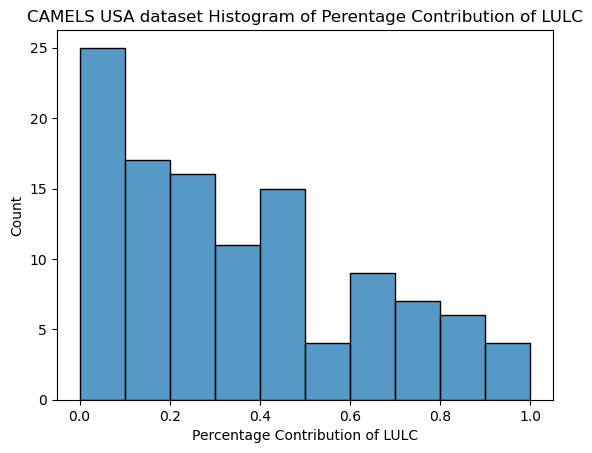

In [169]:
x=[]
bins = np.linspace(0, 1, num=10)
print(bins)

for i, (group, df) in enumerate(table.groupby('country_code')):
    if group=='USA':
        x.append(df)
        # df.lulc_pct_con.plot(kind='hist', label=group)
y = pd.concat(x)

sns.histplot(y.lulc_pct_con, binwidth=0.1)
plt.title('CAMELS USA dataset Histogram of Perentage Contribution of LULC')
plt.xlabel('Percentage Contribution of LULC')
y.describe()

# Corine Land Classes




In [ ]:
files = os.listdir('../Outputs/Meuse/RF_classification/')[:5]
files

In [286]:
meuse_catchment_table = pd.read_excel('../Outputs/Meuse/Meuse_catchment_table.xlsx', index_col='system_index')
mct = meuse_catchment_table
names = ['Membre Pont', 'Straimont', 'Treignes', 'Chooz', 'Daverdisse', 'Jemelle', 'Hastiere', 'Warnant', 'Ortho', 'Wiheries', 'Salzinnes', 'Huccorgne', 'Amay', 'La Meuse Goncourt', 'Le Mouzon Circourt-sur-Mouzon [Villars]', 'Le Vair Soulosse-sous-Saint-Élophe', 'La Meuse Saint-Mihiel', 'La Meuse Stenay', 'La Chiers Longlaville', 'La Chiers Carignan', 'La Bar Cheveuges', 'La Vence la Francheville']
mct = mct.loc[mct['station_re'].isin(names)]

In [238]:
# mti = ([('area_CORINE',            '1'),
#             ('area_CORINE',            '2'),
#             ('area_CORINE',            '3'),
#             ('area_CORINE',            '4'),
#             ('area_CORINE',            '5'),
#             (    'area_RF',            '1'),
#             (    'area_RF',            '2'),
#             (    'area_RF',            '3'),
#             (    'area_RF',            '4'),
#             (    'area_RF',            '5'),
#             (   'training', 'year_trained'),
#             ('area_CORINE',            '6'),
#             (  'catchment',         'area'),
#             (    'area_RF',            '6'),
#             (  'catchment',        'name '),
#             (    'testing',     'accuracy'),
#             (        'ind',             '')], names=[None, 'class'])

mti = [('area_CORINE',            '1'),
        ('area_CORINE',            '2'),
        ('area_CORINE',            '3'),
        ('area_CORINE',            '4'),
        ('area_CORINE',            '5'),
        (    'area_RF',            '1'),
        (    'area_RF',            '2'),
        (    'area_RF',            '3'),
        (    'area_RF',            '4'),
        (    'area_RF',            '5'),
        (   'training', 'year_trained'),
        ('area_CORINE',            '6'),
        (  'catchment',         'area'),
        (    'area_RF',            '6'),
        (  'catchment',        'name '),
        (    'testing',     'accuracy'),
        (        'ind',             '')]

df = pd.read_csv(f'../Outputs/Meuse/RF_classification/0000000000000000000b_1984_classes.csv', header=[0,1])
df

Unnamed: 0_level_0 area_CORINE                         area_RF             \
                 class           1          2          3         1          2   
0           image_date         NaN        NaN        NaN       NaN        NaN   
1  1984-08-31 22:00:00    3.802052  88.491984  32.617763  2.183608  99.948801   

                 training area_CORINE   catchment area_RF  \
           3 year_trained           6        area       6   
0        NaN          NaN         NaN         NaN     NaN   
1  21.593772       1990.0         0.0  124.878635 -1990.0   

                  catchment   testing                 ind  
                      name   accuracy Unnamed: 13_level_1  
0                       NaN       NaN                 NaN  
1  La Vence la Francheville  0.617005                 1_0

In [289]:
year_classified = [1984,1985,1986, 1994,1995,1996,2004,2005,2006,2014,2015,2016]


dfs = []

for index in mct.index.values:
    for year in year_classified:
        df = pd.read_csv(f'../Outputs/Meuse/RF_classification/{index}_{year}_classes.csv', header=[0,1], index_col=[0], parse_dates=True)
        dfs.append(df)


cat = pd.concat(dfs)

cat


#My Drive/Delft/TUDELFT/Thesis/Git/MikeThesis/Outputs/Meuse/RF_classification/00000000000000000017_1984_classes.csv

area_CORINE                              area_RF  \
class                         1            2           3           1   
image_date                                                             
1984-08-31 22:00:00   12.805606    86.628865   24.453819    8.843876   
1985-08-31 22:00:00   12.805606    86.628865   24.453819    3.436793   
1986-08-31 22:00:00   12.805606    86.628865   24.453819    5.008303   
1994-08-31 22:00:00   12.805606    86.628865   24.453819    7.297896   
1995-08-31 22:00:00   12.805606    86.628865   24.453819    5.880230   
...                         ...          ...         ...         ...   
2005-08-31 22:00:00  470.649541  1721.990067  476.968047  488.622981   
2006-08-31 22:00:00  470.649541  1721.990067  476.968047  468.005760   
2014-08-31 22:00:00  476.842932  1715.953986  476.797917  666.876435   
2015-08-31 22:00:00  478.020651  1714.329218  477.244965  569.528224   
2016-08-31 22:00:00  478.020651  1714.329218  477.244965  590.225713   

                                                 training area_CORINE  \
class                          2           3 year_trained           6   
image_date                                                              
1984-08-31 22:00:00    91.871616   22.108096         1990           0   
1985-08-31 22:00:00    81.759985   36.675675         1990           0   
1986-08-31 22:00:00    79.638033   37.756415         1990           0   
1994-08-31 22:00:00    75.854203   29.764023         1990           0   
1995-08-31 22:00:00    49.175675   66.320235         1990           0   
...                          ...         ...          ...         ...   
2005-08-31 22:00:00  1369.615309  558.182898         2006           0   
2006-08-31 22:00:00  1563.828933  458.924663         2006           0   
2014-08-31 22:00:00  1591.805172  301.580572         2012           0   
2015-08-31 22:00:00  1253.800683  672.632620         2018           0   
2016-08-31 22:00:00  1162.668899  757.320587         2018           0   

                       catchment      area_RF  catchment   testing  \
class                       area            6      name   accuracy   
image_date                                                           
1984-08-31 22:00:00   123.921347 -1990.000000    Warnant  0.583204   
1985-08-31 22:00:00   123.921347 -1990.000000    Warnant  0.713064   
1986-08-31 22:00:00   123.921347 -1990.000000    Warnant  0.737170   
1994-08-31 22:00:00   123.921347 -1990.000000    Warnant  0.685855   
1995-08-31 22:00:00   123.921347 -1990.000000    Warnant  0.736392   
...                          ...          ...        ...       ...   
2005-08-31 22:00:00  2681.514071   495.477778  Salzinnes  0.691909   
2006-08-31 22:00:00  2681.514071   475.685935  Salzinnes  0.698834   
2014-08-31 22:00:00  2681.514071   673.531781  Salzinnes  0.576923   
2015-08-31 22:00:00  2681.514071   575.943182  Salzinnes  0.753979   
2016-08-31 22:00:00  2681.514071   596.744427  Salzinnes  0.765252   

                                    ind area_CORINE     area_RF  \
class               Unnamed: 13_level_1           5           5   
image_date                                                        
1984-08-31 22:00:00                 0_0         NaN         NaN   
1985-08-31 22:00:00                 0_1         NaN         NaN   
1986-08-31 22:00:00                 0_2         NaN         NaN   
1994-08-31 22:00:00                 0_3         NaN         NaN   
1995-08-31 22:00:00                 0_4         NaN         NaN   
...                                 ...         ...         ...   
2005-08-31 22:00:00                 NaN    9.539207  188.091646   
2006-08-31 22:00:00                 NaN    9.539207  149.216697   
2014-08-31 22:00:00                 NaN    9.552028   93.744631   
2015-08-31 22:00:00                 NaN    9.552028  139.311794   
2016-08-31 22:00:00                 NaN    9.552028  131.211878   

                                    ind area_CORINE    area_RF  \
cl

1984-12-31 00:00:00
1985-12-31 00:00:00
1986-12-31 00:00:00
1987-12-31 00:00:00
1988-12-31 00:00:00
1989-12-31 00:00:00
1990-12-31 00:00:00
1991-12-31 00:00:00
1992-12-31 00:00:00
1993-12-31 00:00:00
1994-12-31 00:00:00
1995-12-31 00:00:00
1996-12-31 00:00:00
1997-12-31 00:00:00
1998-12-31 00:00:00
1999-12-31 00:00:00
2000-12-31 00:00:00
2001-12-31 00:00:00
2002-12-31 00:00:00
2003-12-31 00:00:00
2004-12-31 00:00:00
2005-12-31 00:00:00
2006-12-31 00:00:00
2007-12-31 00:00:00
2008-12-31 00:00:00
2009-12-31 00:00:00
2010-12-31 00:00:00
2011-12-31 00:00:00
2012-12-31 00:00:00
2013-12-31 00:00:00
2014-12-31 00:00:00
2015-12-31 00:00:00
2016-12-31 00:00:00


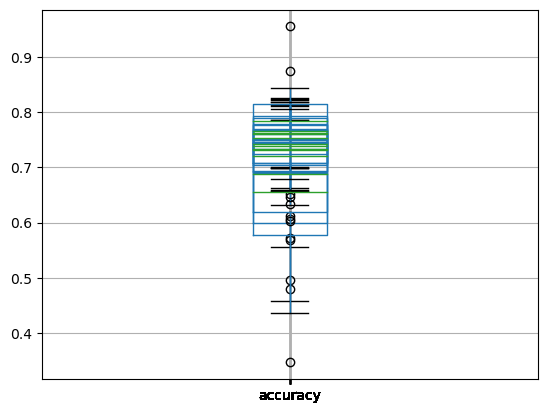

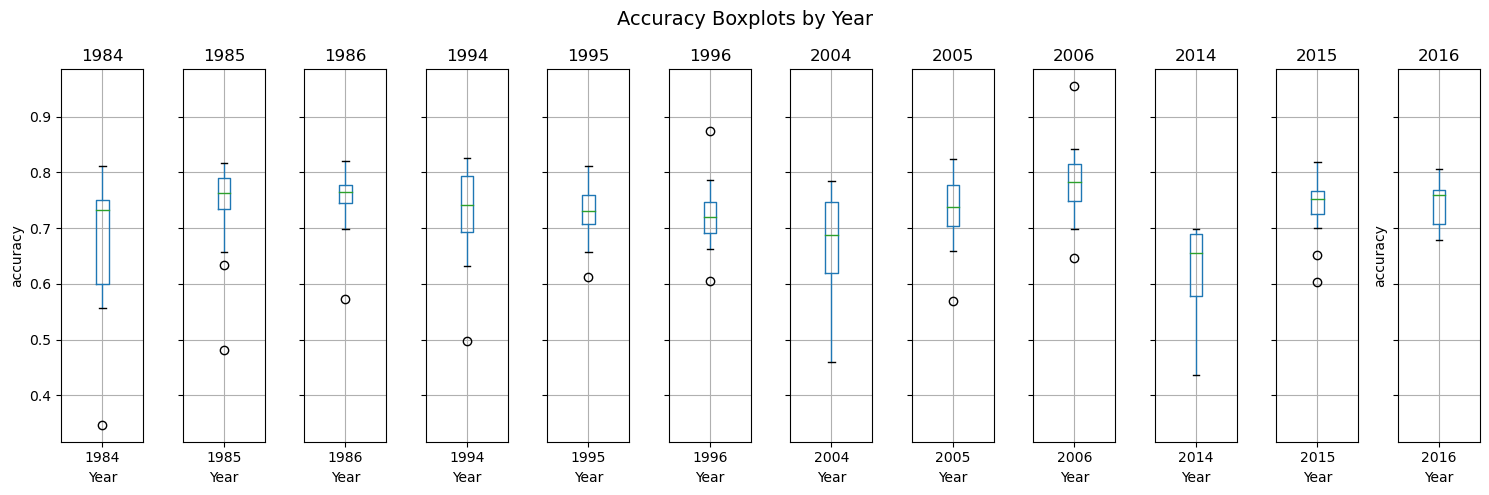

In [241]:
cat.area_RF[str(1)]
gp = cat.groupby(pd.Grouper(freq='Y'))

for i , (group, df) in enumerate(gp):
    print(group)
    df.testing.boxplot(column='accuracy')

# The number of FixedLocator locations (2), usually from a call to set_ticks, does not match the number of ticklabels (1).
year_classified = [1984,1985,1986, 1994,1995,1996,2004,2005,2006,2014,2015,2016]
fig, axes = plt.subplots(1, len(year_classified), figsize=(15, 5), sharey=True)

a = 0
axes[0].set_ylabel('accuracy')
for i , (group, df) in enumerate(gp):
    
    if group.year in year_classified:
        df.testing.boxplot(column='accuracy', by=df.index.year, ax=axes[a])
        axes[a].set_title(group.year)
        axes[a].set_xlabel('Year')
        a += 1
        #axes[i].set_ylabel('Accuracy')

plt.suptitle('Accuracy Boxplots by Year', fontsize=14)
plt.ylabel('accuracy')
plt.tight_layout()


In [242]:
import seaborn as sns


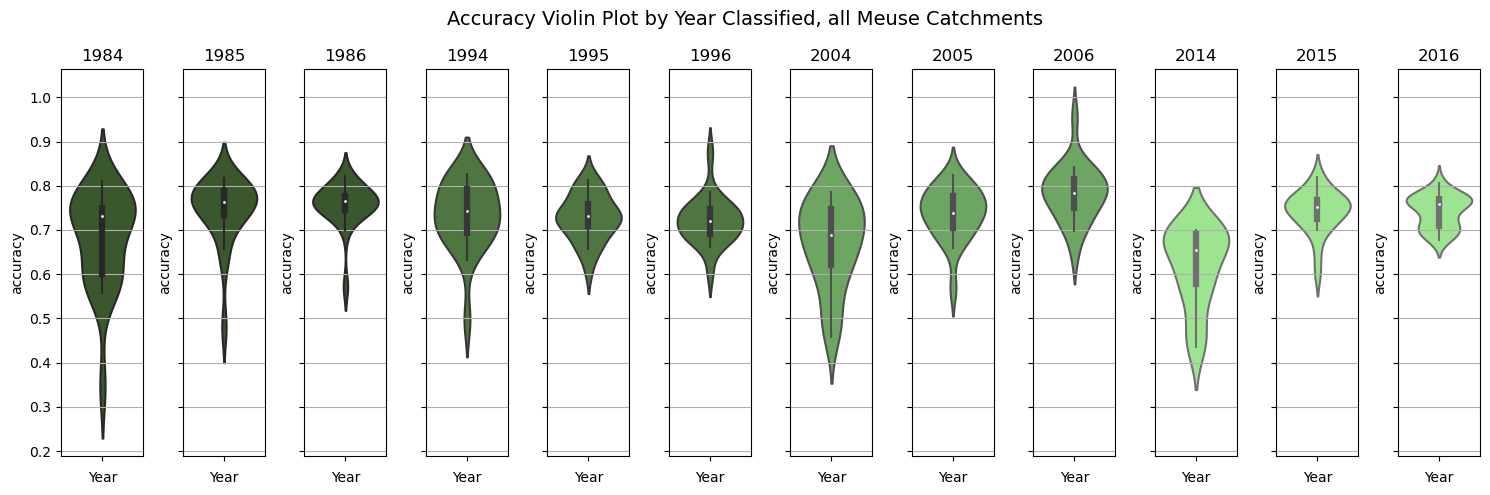

In [331]:
year_classified = [1984,1985,1986, 1994,1995,1996,2004,2005,2006,2014,2015,2016]
palette = ['#395e26', '#395e26', '#395e26', '#4b7f38', '#4b7f38', '#4b7f38', '#66b057', '#66b057', '#66b057', '#93f282', '#93f282', '#93f282']

#fig, axes = plt.subplots(1, len(year_classified), figsize=(15, 5), sharey=True)

a = 0
fig, axes = plt.subplots(1, len(year_classified), figsize=(15, 5), sharey=True)


for i, (group, df) in enumerate(gp):
    if group.year in year_classified:
        axes[a].grid()
        sns.violinplot(y=df.testing.accuracy, ax=axes[a], color=palette[a])
        axes[a].set_title(group.year)
        axes[a].set_xlabel('Year')
        
        #axes[a].set_ylabel('Accuracy')
        a += 1

plt.suptitle('Accuracy Violin Plot by Year Classified, all Meuse Catchments', fontsize=14)
plt.tight_layout()


In [314]:
cat = cat.fillna(0)
fix_area = cat.area_RF.loc[:, '1']+cat.area_RF.loc[:, '2']+cat.area_RF.loc[:, '3']+cat.area_RF.loc[:, '4']+cat.area_RF.loc[:, '5']

area = cat.loc[:,('catchment', 'area')] - fix_area
cat[('area_RF', '6_fix')] = area

In [322]:
cat.index


DatetimeIndex(['1984-08-31 22:00:00', '1985-08-31 22:00:00',
               '1986-08-31 22:00:00', '1994-08-31 22:00:00',
               '1995-08-31 22:00:00', '1996-08-31 22:00:00',
               '2004-08-31 22:00:00', '2005-08-31 22:00:00',
               '2006-08-31 22:00:00', '2014-08-31 22:00:00',
               ...
               '1986-08-31 22:00:00', '1994-08-31 22:00:00',
               '1995-08-31 22:00:00', '1996-08-31 22:00:00',
               '2004-08-31 22:00:00', '2005-08-31 22:00:00',
               '2006-08-31 22:00:00', '2014-08-31 22:00:00',
               '2015-08-31 22:00:00', '2016-08-31 22:00:00'],
              dtype='datetime64[ns]', name='image_date', length=264, freq=None)

In [325]:
def compute_rmse(y_true: pd.Series, y_pred: pd.Series) -> float:
    """
    Computes the root mean squared error (RMSE) of two pandas Series.
    """
    # Ensure both Series have the same length
    assert len(y_true) == len(y_pred), "Input Series must have the same length"
    
    # Compute the difference between the true and predicted values
    error = y_true - y_pred
    
    # Compute the mean squared error (MSE)
    mse = np.mean(error**2)
    
    # Compute the RMSE
    rmse = np.sqrt(mse)
    
    return rmse

C:\Users\creeb\AppData\Local\Temp\ipykernel_27144\470501743.py:12: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  grouped = rdx.groupby('image_date').sum()
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argu

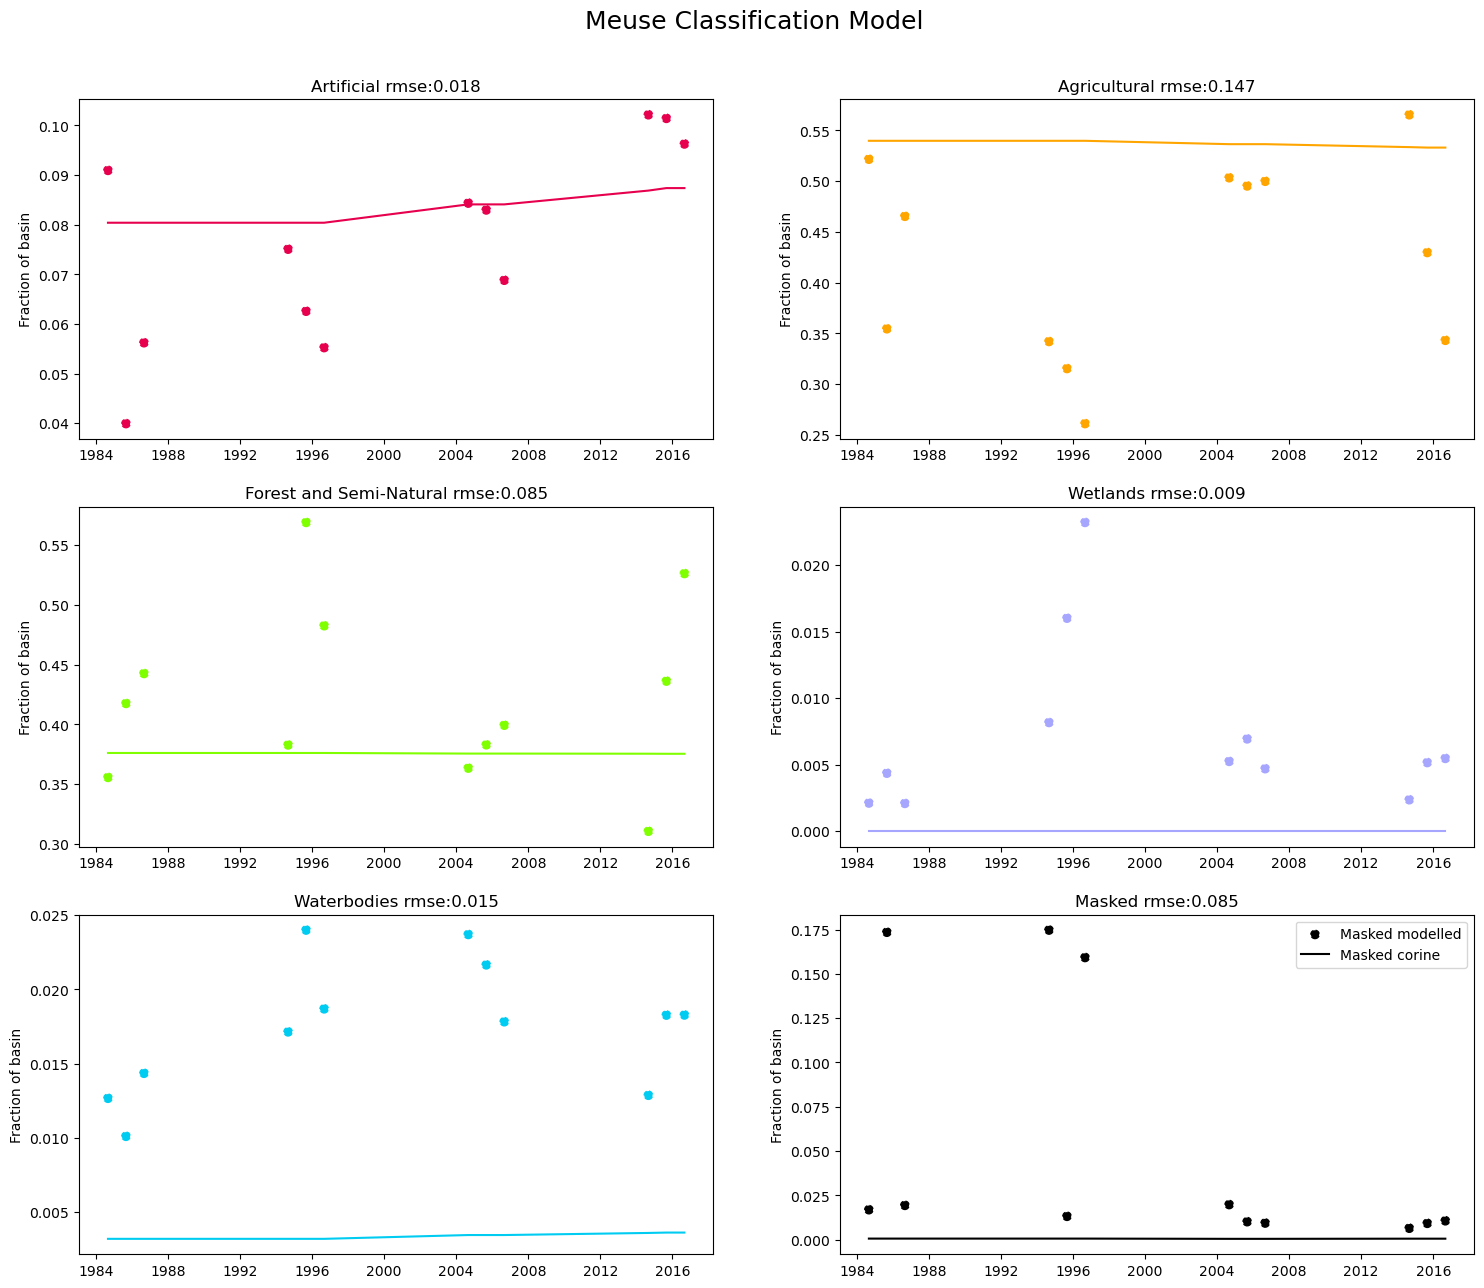

In [330]:
class_name = ['Artificial', 'Agricultural', 'Forest and Semi-Natural', 'Wetlands', 'Waterbodies', 'Masked']
rdx = cat.reset_index().fillna(0)
# rdx.area_RF.iloc[:, 5] = rdx.area_RF.iloc[:,0:4].sum(axis=1) - rdx.catchment.area
rdx[('area_RF', 'masked')] = rdx.area_RF.loc[:, '6_fix']

# for i in range(6):
#     print(class_name[i], np.mean(rdx.area_RF.iloc[:,i]/rdx.catchment.area))

# print('Fixed Mask', np.mean(rdx.area_RF.masked/rdx.catchment.area))


grouped = rdx.groupby('image_date').sum()

colors = ['#E6004D', 'orange', '#80FF00', '#A6A6FF', '#00CCF2', 'black']

fig, axes = plt.subplots(3,2, figsize = (18,15))

tit = plt.suptitle('Meuse Classification Model', y=0.94, size=18)

keys = [str(1), str(2), str(3), str(4), str(5), '6_fix']

for i in range(6):
    if i == 0:
        col=0
        row=0
    elif i==1:
        col=1
        row=0
    elif i==2:
        col=0
        row=1
    elif i==3:
        col=1
        row=1
    elif i==4:
        col=0
        row=2
    else:
        col=1
        row=2
    
    
    
    y_pred = grouped.area_RF.loc[:,keys[i]]/grouped.catchment.area
    
    y_true = grouped.area_CORINE.iloc[:,i]/grouped.catchment.area
    
    rmse = compute_rmse(y_true, y_pred)
    
    ax = axes[row, col]
    
    ax.set_title(f'{class_name[i]}, rmse:{rmse:.3f}')
    
    ax.scatter(grouped.index, grouped.area_RF.loc[:,keys[i]]/grouped.catchment.area, linestyle='dashed', c=colors[i], label=f'{class_name[i]} modelled')
    
    ax.plot(grouped.index, grouped.area_CORINE.iloc[:,i]/grouped.catchment.area, c=colors[i], label=f'{class_name[i]} corine')
    
    ax.set_ylabel('Fraction of basin')
    
    
    plt.legend()
    

In [281]:
year_brackets = [[1984,1985,1986], [1994,1995,1996], [2004,2005,2006], [2014,2015,2016]]

artificial RF, 1326.087
artificial corine, 1172.105
artificial RF, 582.133
artificial corine, 1172.105
artificial RF, 819.682
artificial corine, 1172.105
artificial RF, 1094.591
artificial corine, 1172.105
artificial RF, 912.311
artificial corine, 1172.105
artificial RF, 805.386
artificial corine, 1172.105
artificial RF, 1229.963
artificial corine, 1225.997
artificial RF, 1209.784
artificial corine, 1225.997
artificial RF, 1003.340
artificial corine, 1225.997
artificial RF, 1489.434
artificial corine, 1266.524
artificial RF, 1478.859
artificial corine, 1273.855
artificial RF, 1403.668
artificial corine, 1273.855


In [261]:
def meuse_class_table(classes, periods, sys_ind):
    '''
    For each land class table append the value to a combined table 
    '''
    combined_classes = pd.DataFrame(columns=classes)#, classes.Description, classes.loc[:,'Color Value']])#.insert(1, 'system_index', meuse_sysind[:])
    combined_classes.insert(0, 'period', np.nan, True)
    combined_classes.insert(0, 'system_index', 'a', True)
    combined_classes.set_index('system_index')
   
    #combined_classes.rename(columns={'Value':'system_index'})
    combined_classes.index.name = None
    

    row = 1

    for i, year in enumerate(periods):

        for j,  sys in enumerate(sys_ind[:]):
            
            filepath = f'../Ouputs/Meuse/RF_classification/{sys}_{year}_classes.csv'
            

            df = pd.read_csv(filepath, converters={'system_index':str}, index_col='system_index')
            
            
            
            combined_classes.loc[row, 'period'] = int(year)
            combined_classes.loc[row, 'system_index'] = str(sys)
            combined_classes.set_index('system_index')
            
            df_set = list(df.keys()[:])
            cc_set = set(combined_classes.keys()[-44:])
            intersection = list(cc_set.intersection(df_set))
            
            l = df.index.values[0]
            
            
            
            for k in df_set:
                #print(df.loc[l, k])
                combined_classes.loc[row, k] = float(df.loc[l, k])
            
            row +=1
    combined_classes['summed'] = combined_classes.iloc[2:-1].sum(axis=1)
            
    return combined_classes



In [262]:
classes = ['artificial', 'agricultural', 'forest', 'wetland', 'waterbodies']
periods = [1984,1985,1986, 1994,1995,1996,2004,2005,2006,2014,2015,2016]
meuse_sysind = ['00000000000000000017', '0000000000000000000b', '0000000000000000001c', '0000000000000000000f', '00000000000000000015', '00000000000000000013', '0000000000000000001a', '00000000000000000008', '0000000000000000001f', '0000000000000000001d', '00000000000000000020', '0000000000000000000a', '0000000000000000001b', '00000000000000000021', '00000000000000000003', '00000000000000000002', '0000000000000000000e', '00000000000000000022', '0000000000000000000d', '00000000000000000000', '00000000000000000001', '00000000000000000004']


In [263]:
meuse_table = meuse_class_table(classes, periods, meuse_sysind)
meuse_table.summed = meuse_table.iloc[:, 2:-1].sum(axis=1)


FileNotFoundError: [Errno 2] No such file or directory: '../Ouputs/Meuse/RF_classification/00000000000000000017_1984_classes.csv'

In [ ]:
grouped = meuse_table.groupby('period')

dfs = []

for i, (group, data) in enumerate(grouped):
    
    summed = data.sum()
    to_pct = np.cumsum(summed[2:-1])[-1]
    
    dic = {'year' : group,
           'artificial': np.cumsum(summed[2:13])[-1],#/to_pct, 
           'agricultural' : np.cumsum(summed[14:24])[-1],#/to_pct,
           'for_s_natural' : np.cumsum(summed[24:36])[-1],#/to_pct,
           'wetland' : np.cumsum(summed[36:41])[-1],#/to_pct, 
           'waterbody' : np.cumsum(summed[41:-1])[-1],}#/to_pct}
    
    dfs.append(pd.DataFrame(dic, index=[0]))



In [ ]:
table_90 = meuse_table.iloc[:grouped[1990][-1]]
table_00 = meuse_table.iloc[grouped[2000][0]:grouped[2000][-1]]
table_06 = meuse_table.iloc[grouped[2006][0]:grouped[2006][-1]]
table_12 = meuse_table.iloc[grouped[2012][0]:grouped[2012][-1]]
table_18 = meuse_table.iloc[grouped[2018][0]:grouped[2018][-1]]

display(table_90)

artificial = [111, 142]
agricultural = [211, 244]
for_s_natural = [311, 335]
wetland = [411, 423]
waterbodies = [511, 523]

table_list = [table_90,table_00, table_06, table_12, table_18]

cols = ['year','artificial','agricultural','for_s_natural','wetland','waterbody']

full = pd.DataFrame(columns=cols)

fig, ax = plt.subplots(1, 5, figsize=(30, 5))
yr =[]
art = []
ag = []
fors = []
wet = []
wat = []

for i, table in enumerate(table_list):
    
    year = list(grouped)[i]
    display(summed_table)
    summed_table = table.sum()
    to_pct = summed_table.summed
    #display(summed_table[41:])
    
    
    dic = {'year' : year,
           'artificial': summed_table[2:13].sum()/to_pct, 
           'agricultural' : summed_table[14:24].sum()/to_pct,
           'for_s_natural' : summed_table[24:36].sum()/to_pct,
           'wetland' : summed_table[36:41].sum()/to_pct, 
           'waterbody' : summed_table[41:-1].sum()/to_pct}
    
    cat = pd.DataFrame(dic, index=[0])
    
    yr.append(cat.year)
    art.append(cat.artificial)
    
    
    cat.loc[0, 'artificial':'waterbody'].plot(kind='bar', ax=ax[i], title=f'CORINE mean percentage $/km^2$, {year}')
    
    
    

full

In [ ]:
meuse_table.iloc[0, :]